In [29]:
import numpy as np
output_keypoints_3d = np.load('./output_3D/output_keypoints_3d.npz') # 데이터 로드. @파일명
output_keypoints_3d = output_keypoints_3d['reconstruction']

In [30]:
import pickle
import numpy as np
import json, codecs
import numpy as np
import re  # 추가: 정규 표현식을 사용하기 위한 모듈
import os   # 추가: 파일 목록을 얻기 위한 모듈
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

falldown_time=0 # 몇초부터( 몇번째 프레임부터 넘어지는지 저장 )
falldown_angle=0

# pkl_path = '/media/piai/NewVolume/AI_PROJECT/SceneEgo_folder/EgocentricDepthEstimator_ALL_SUCCESS/data/out/'
# pkl_filename =  os.path.join(pkl_path,'screenshot_')
json_path = './'
json_point_filename = os.path.join(json_path, "output_skeleton.json")
json_line_filename = os.path.join(json_path, "output_skeleton_lines.json")

out_path = '/media/piai/NewVolume/CCTV_FINAL_VIDEO/'
out_filename = os.path.join(out_path, 'cctv_out_')

video_path = '/media/piai/NewVolume/CCTV_FINAL_VIDEO/'
video_filename = os.path.join(video_path, 'cctv_out_video.mp4')

In [31]:
def extract_number(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    return 0  # 숫자가 없는 경우 0으로 처리합니다.

def quaternion_to_matrix(q):
    """Convert a quaternion into a rotation matrix."""
    w, x, y, z = q
    return np.array([
        [1 - 2 * (y * y + z * z), 2 * (x * y - z * w), 2 * (x * z + y * w)],
        [2 * (x * y + z * w), 1 - 2 * (x * x + z * z), 2 * (y * z - x * w)],
        [2 * (x * z - y * w), 2 * (y * z + x * w), 1 - 2 * (x * x + y * y)]
    ])

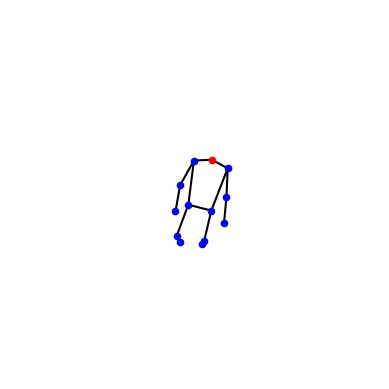

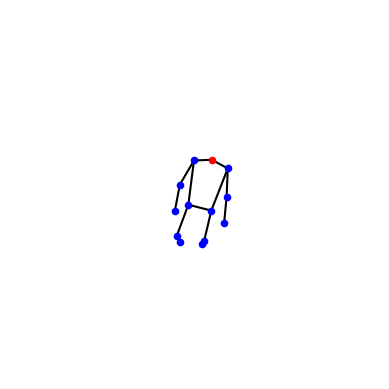

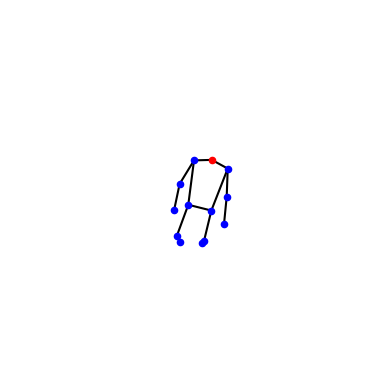

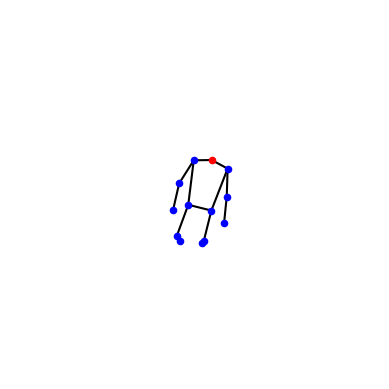

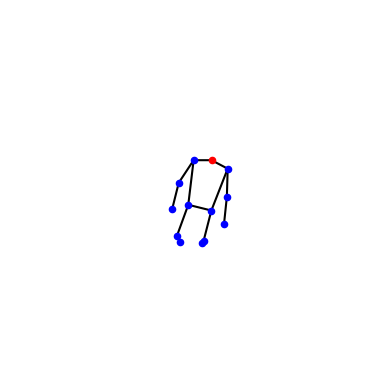

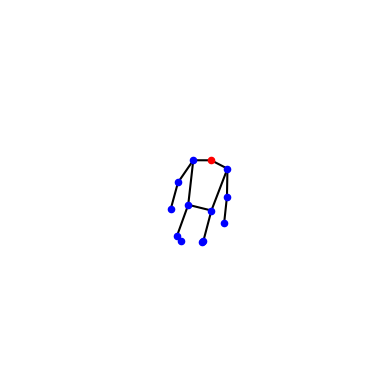

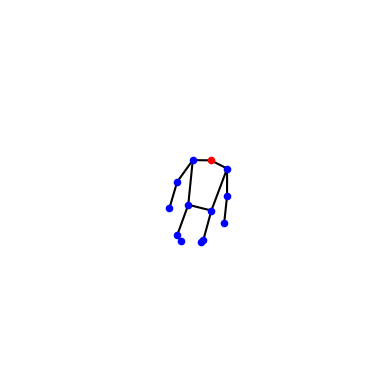

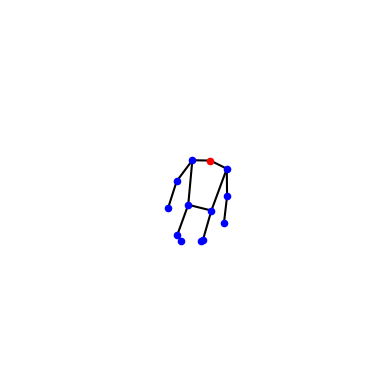

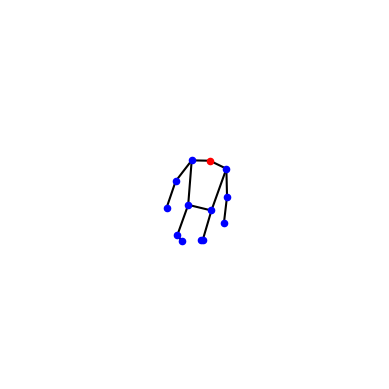

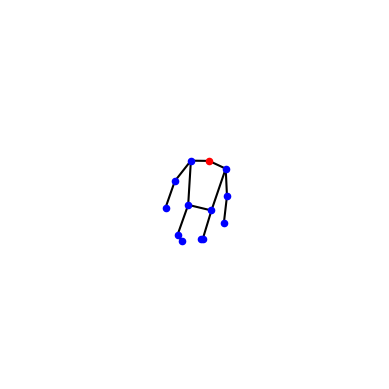

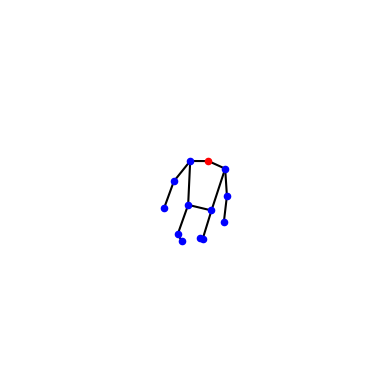

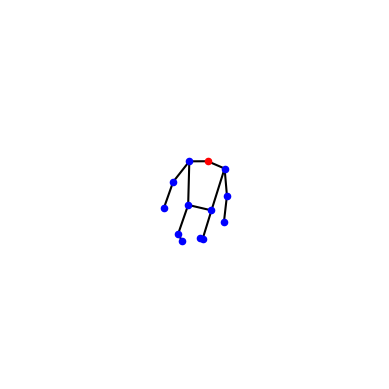

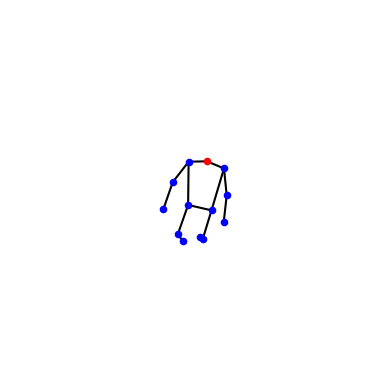

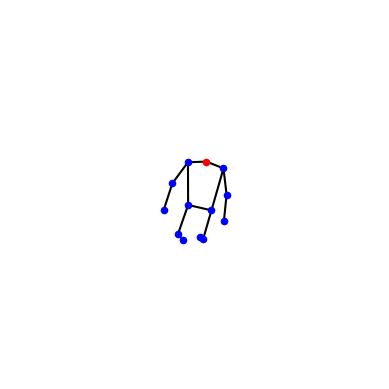

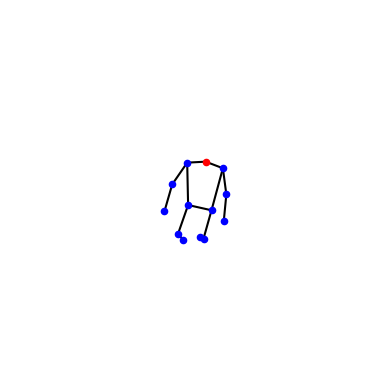

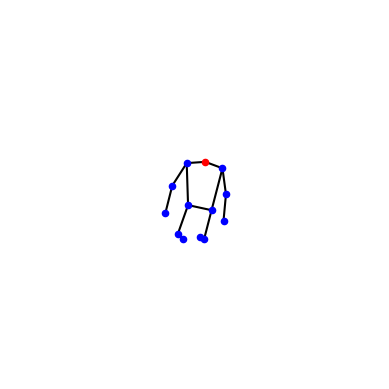

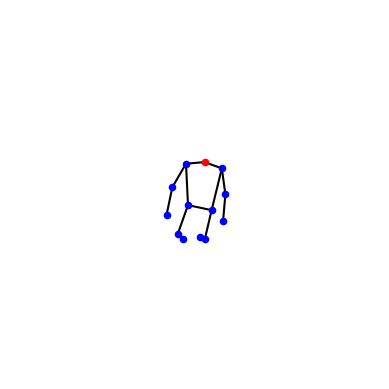

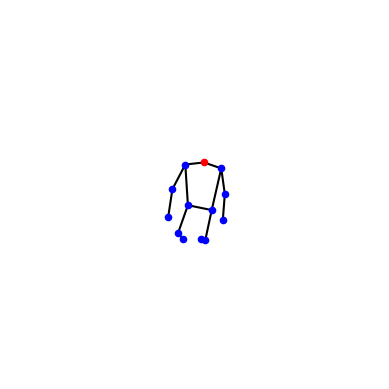

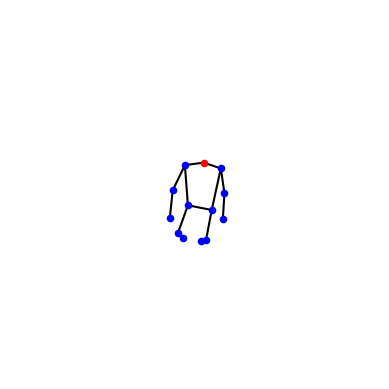

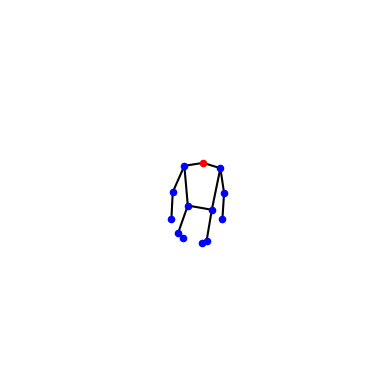

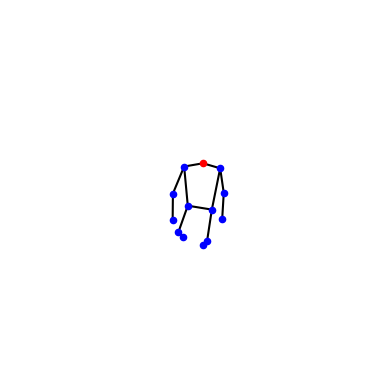

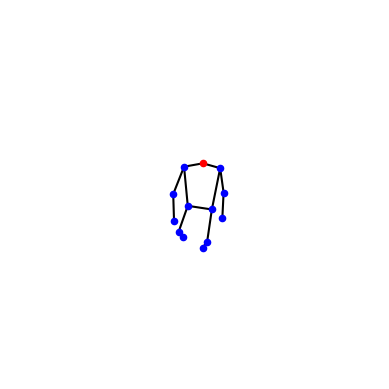

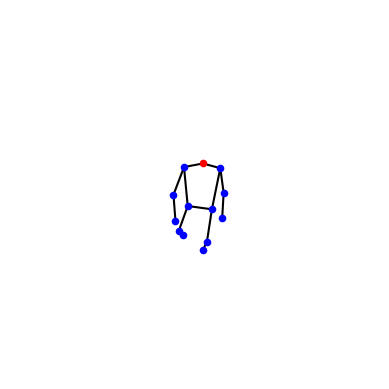

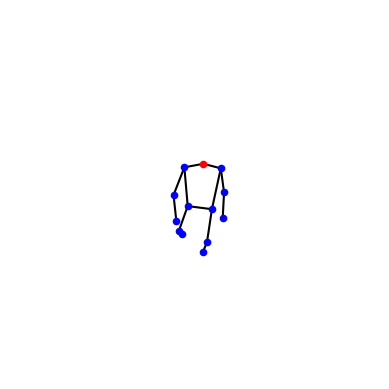

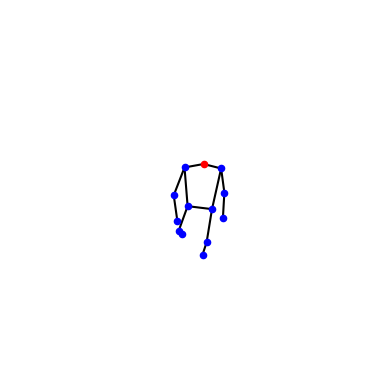

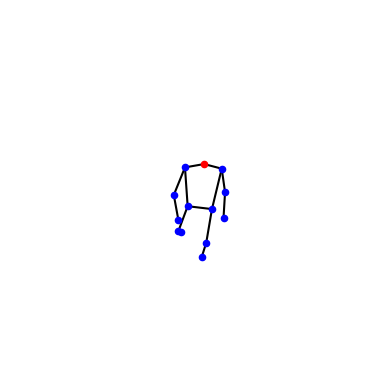

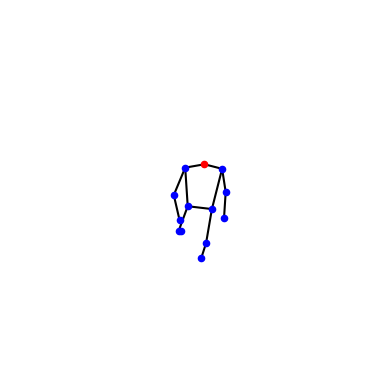

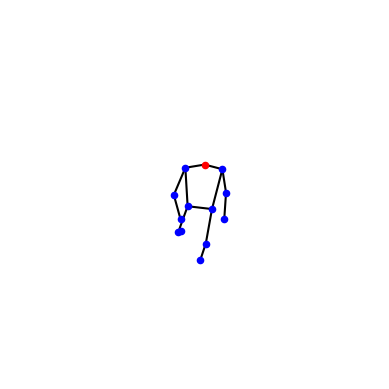

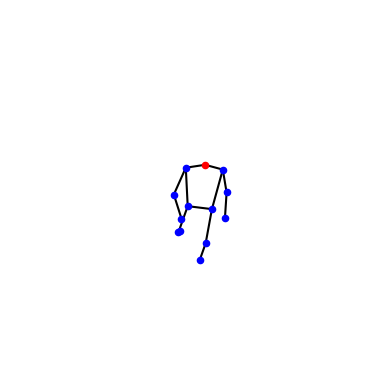

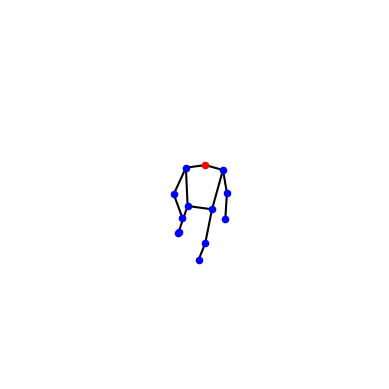

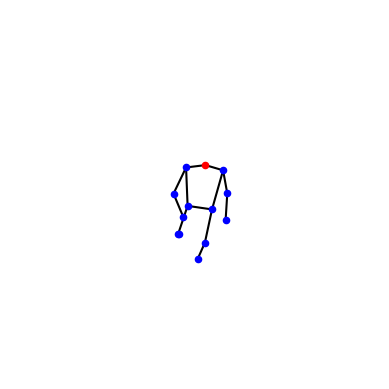

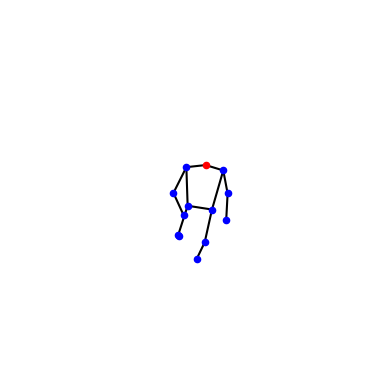

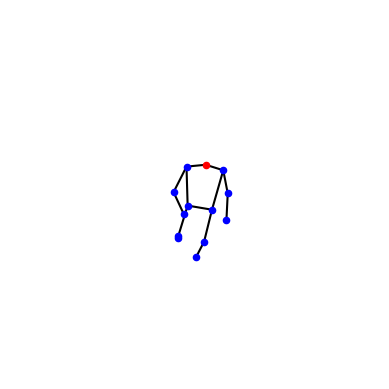

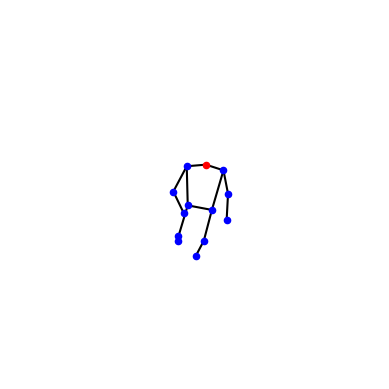

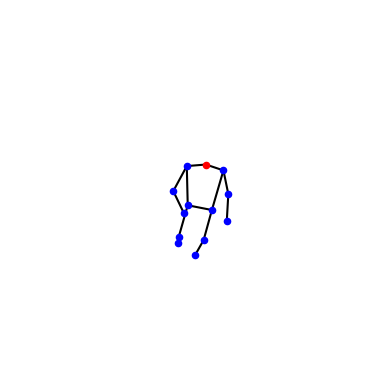

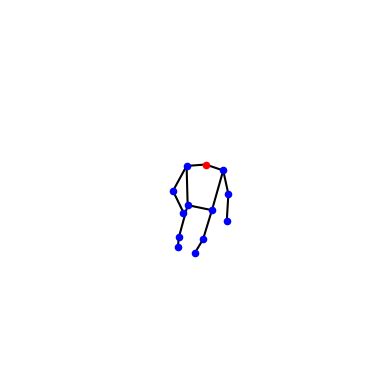

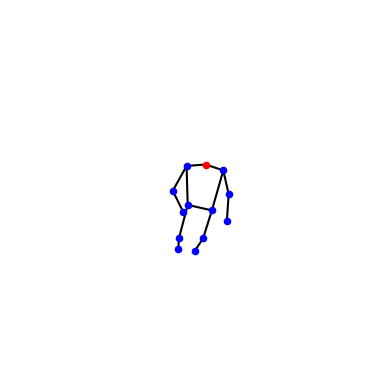

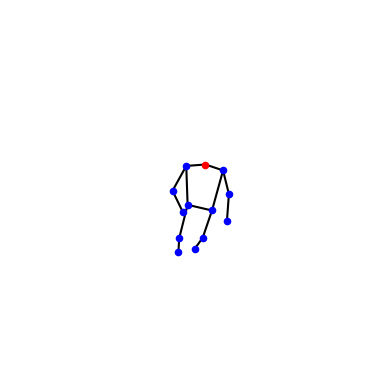

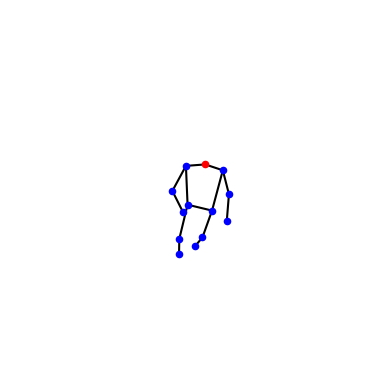

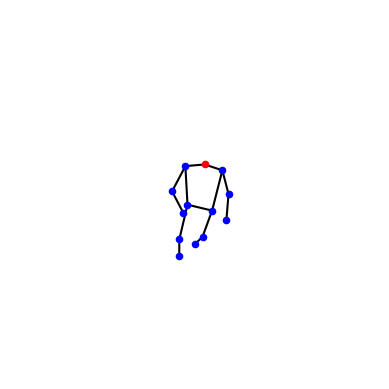

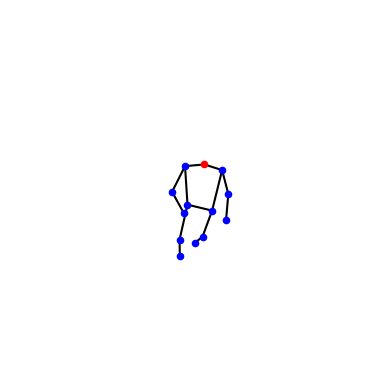

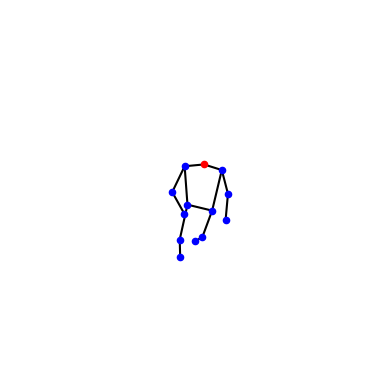

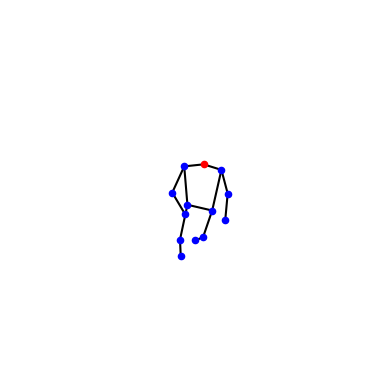

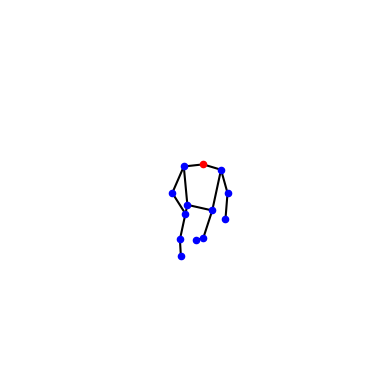

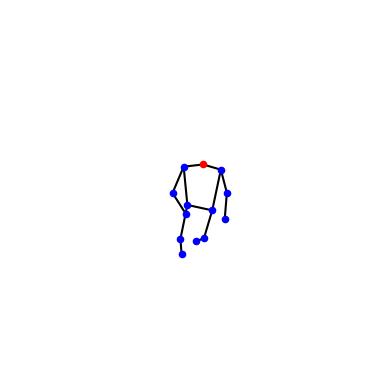

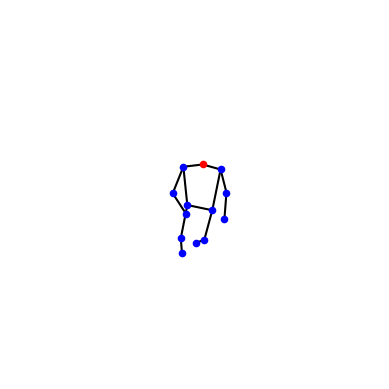

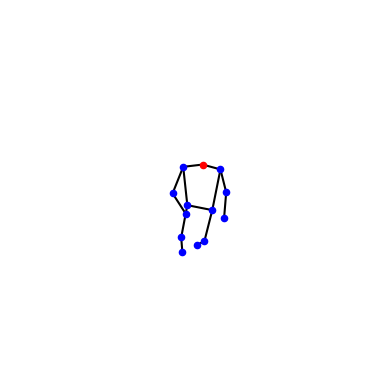

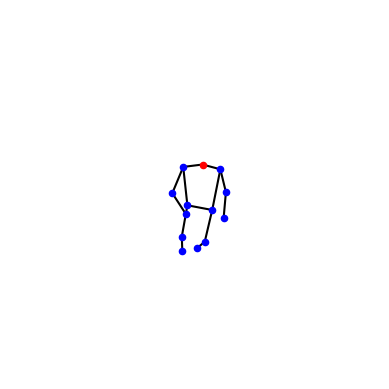

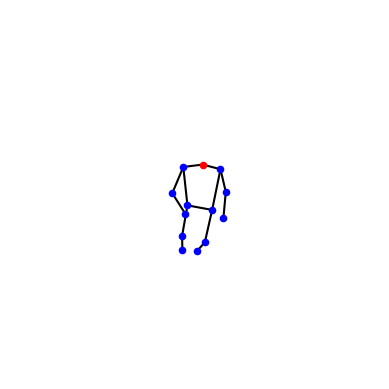

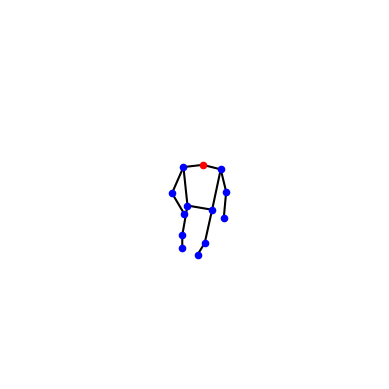

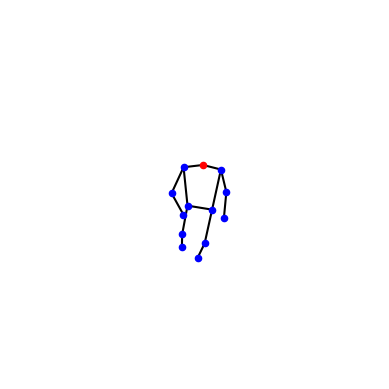

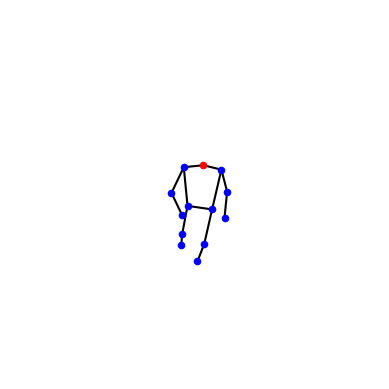

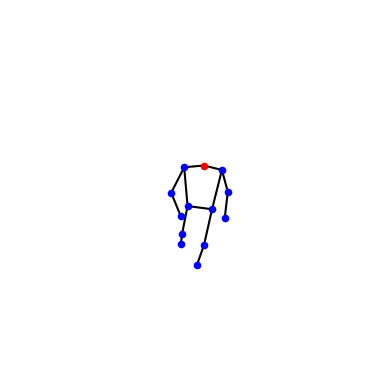

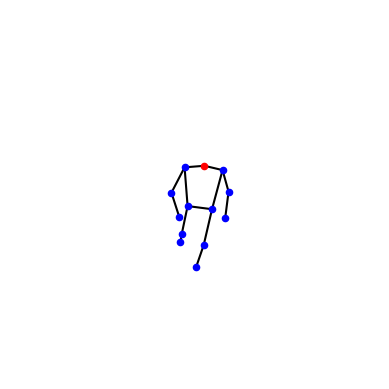

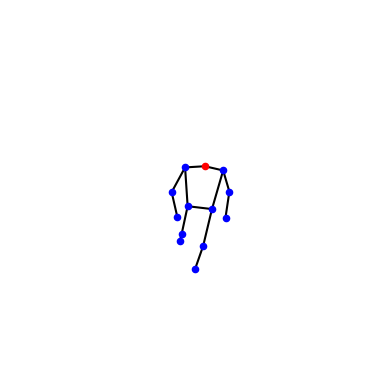

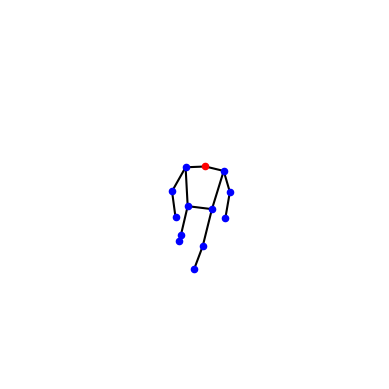

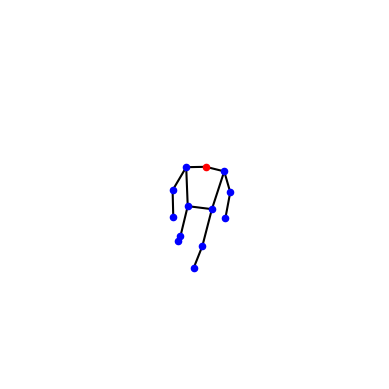

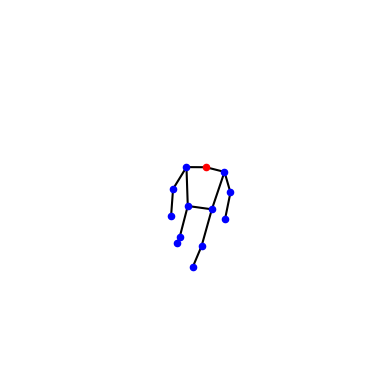

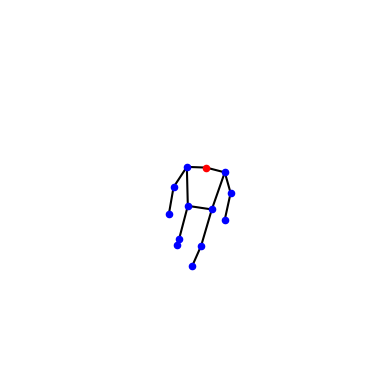

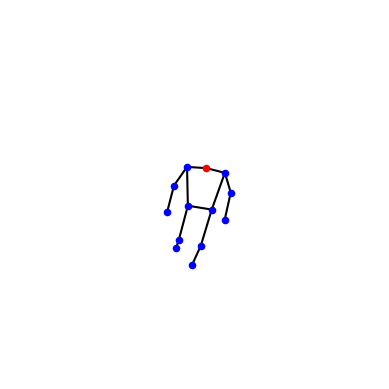

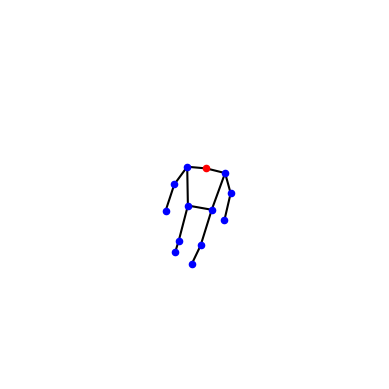

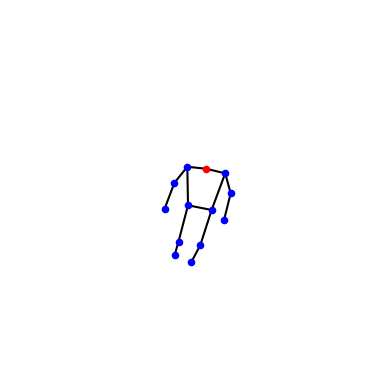

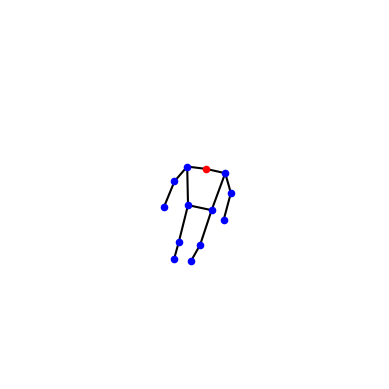

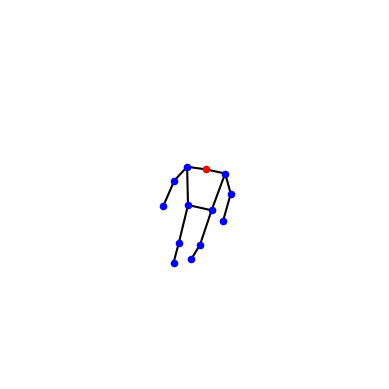

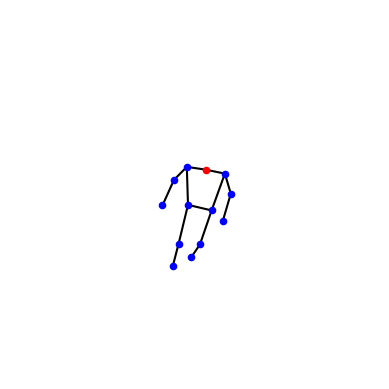

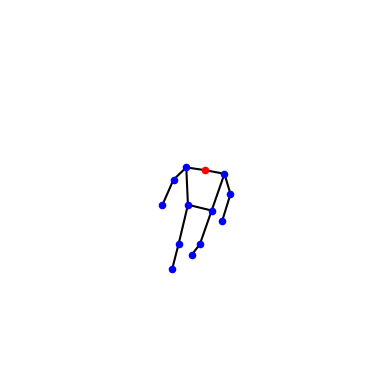

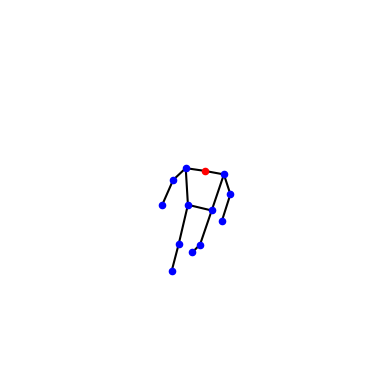

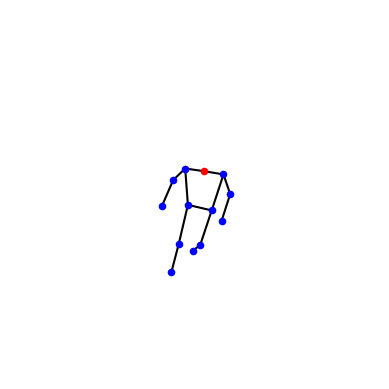

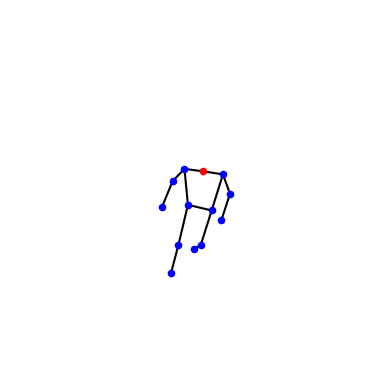

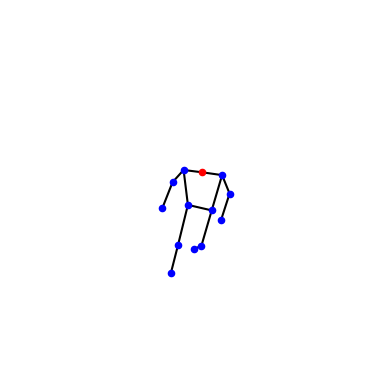

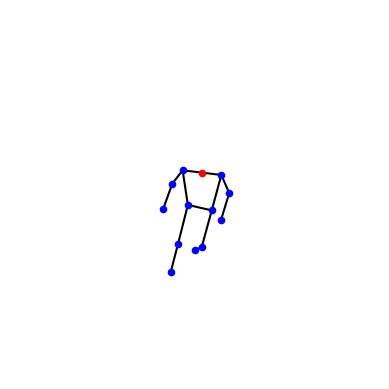

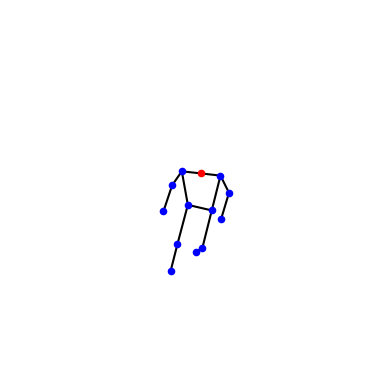

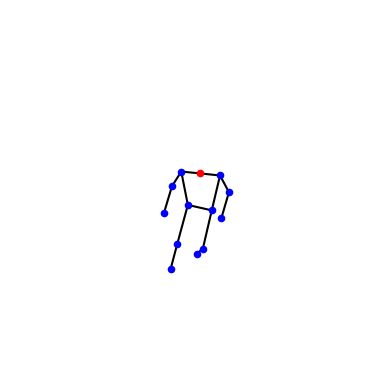

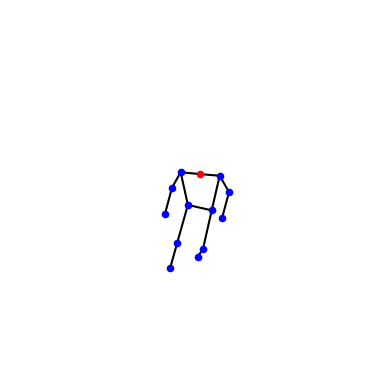

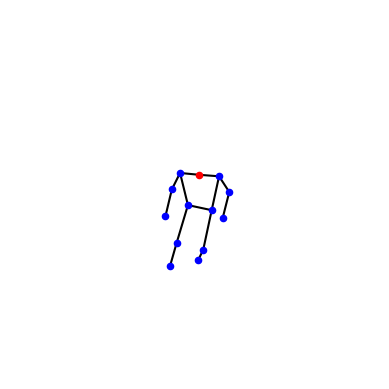

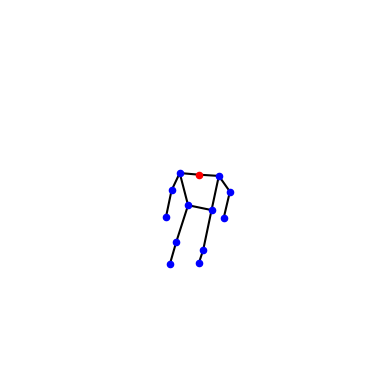

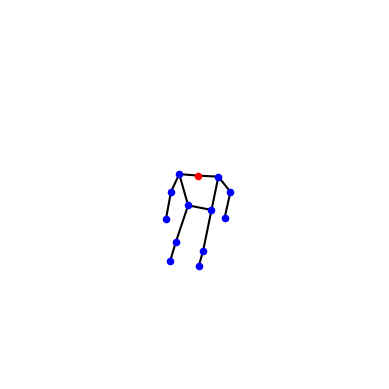

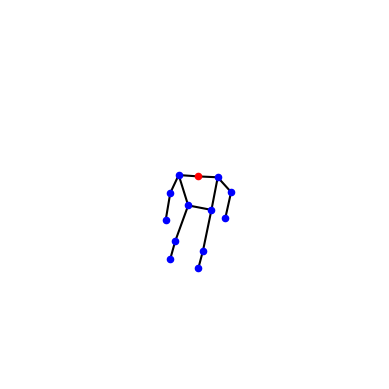

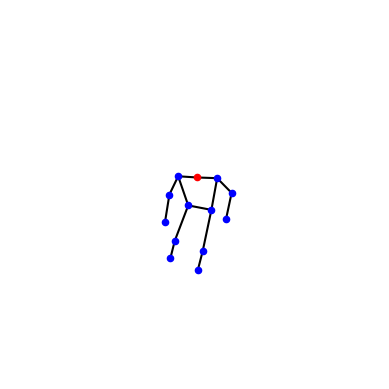

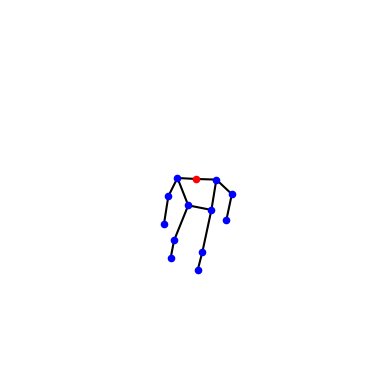

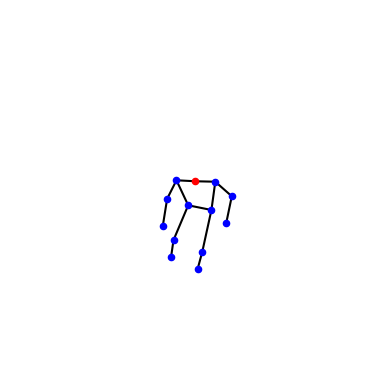

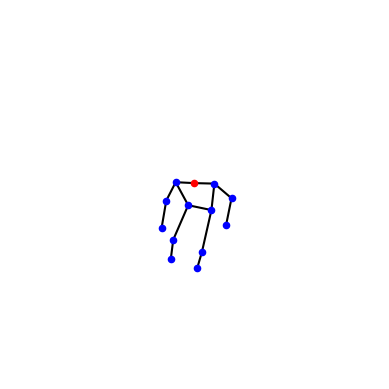

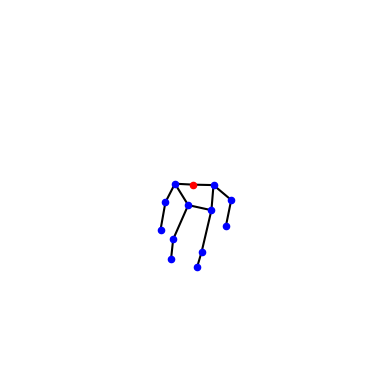

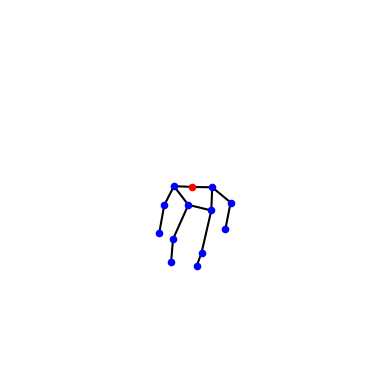

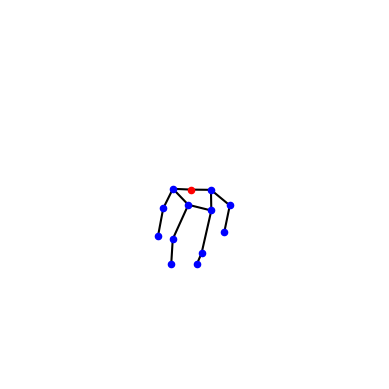

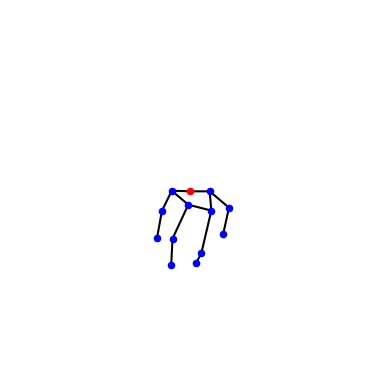

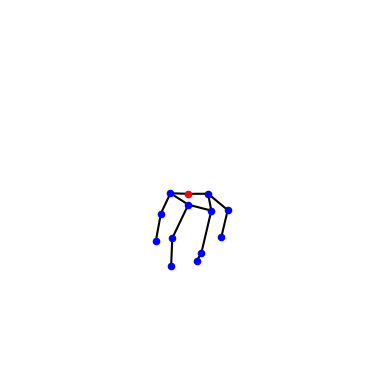

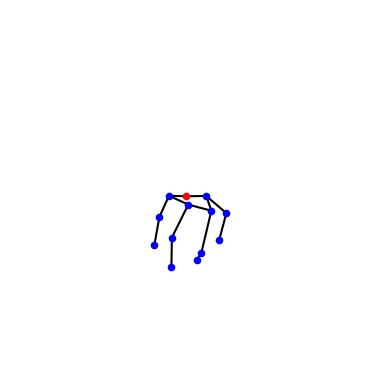

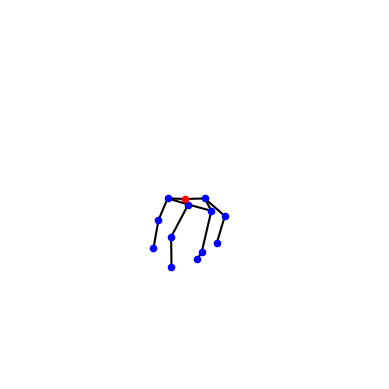

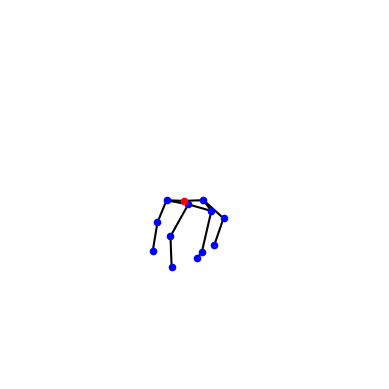

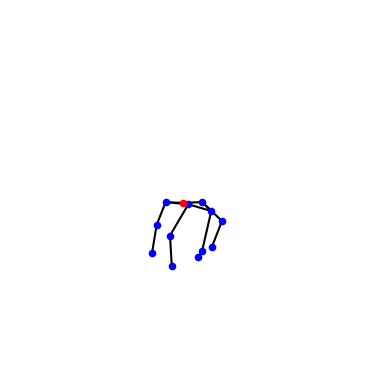

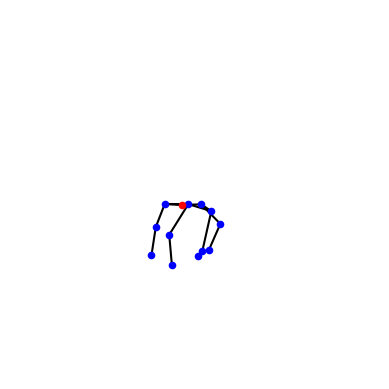

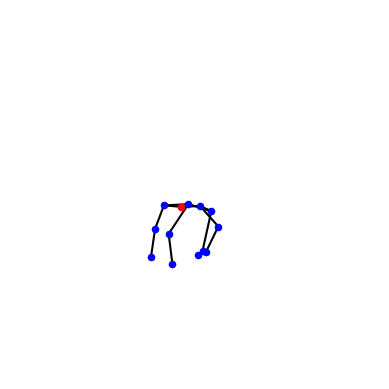

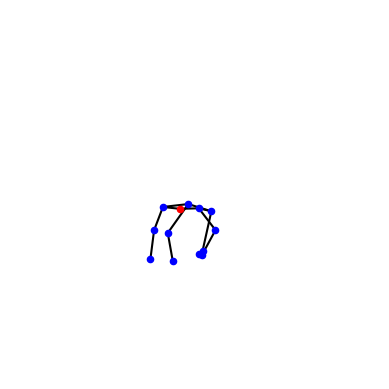

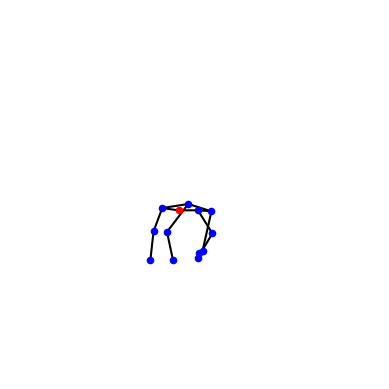

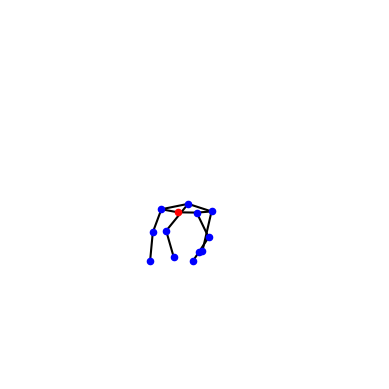

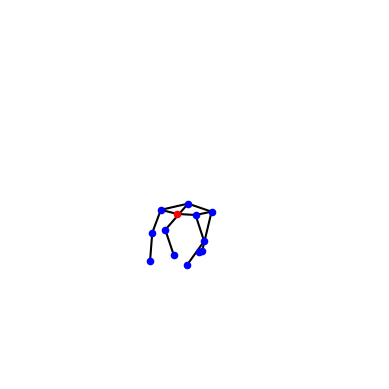

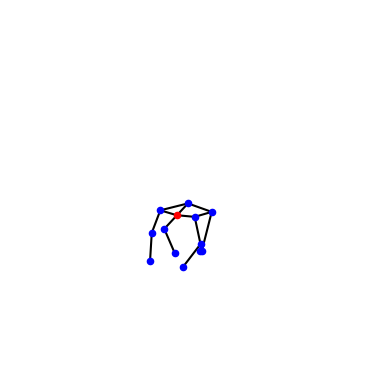

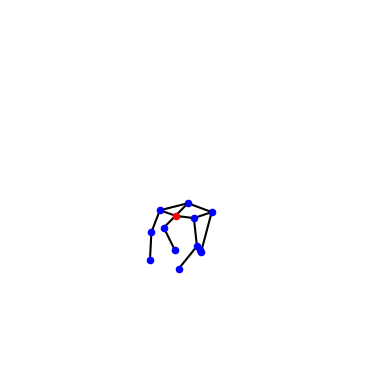

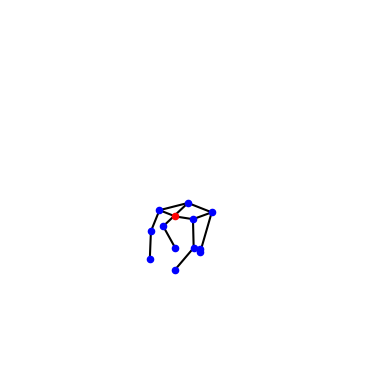

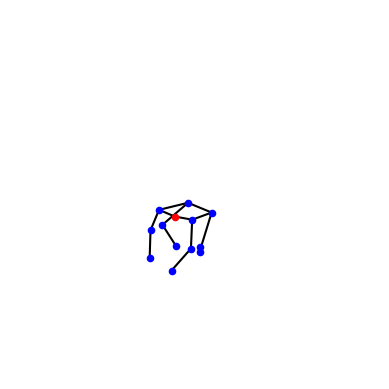

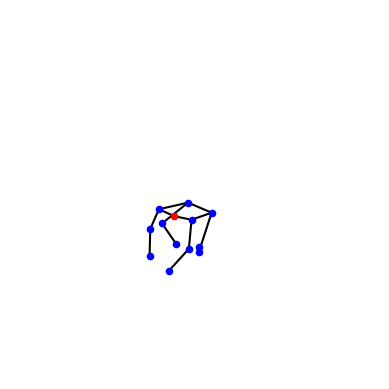

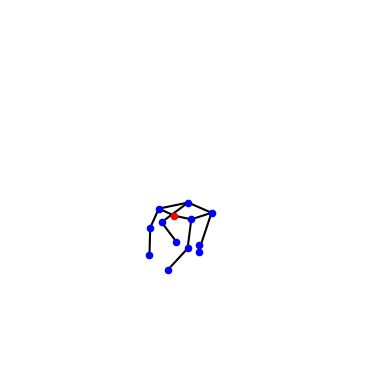

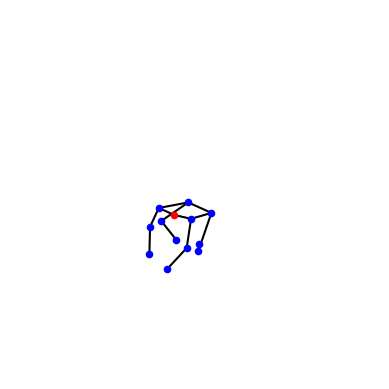

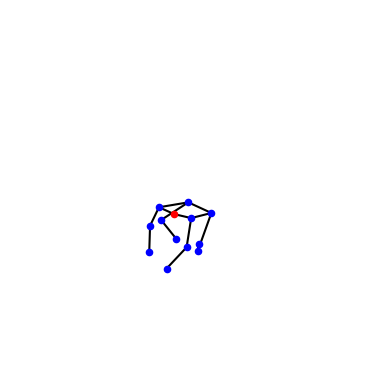

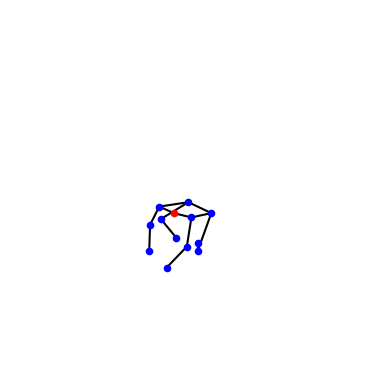

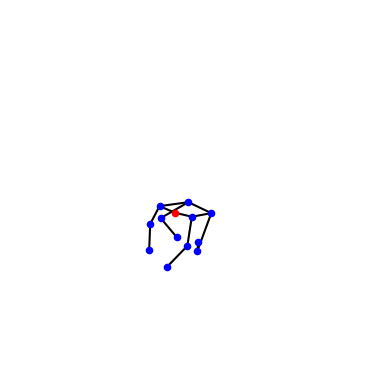

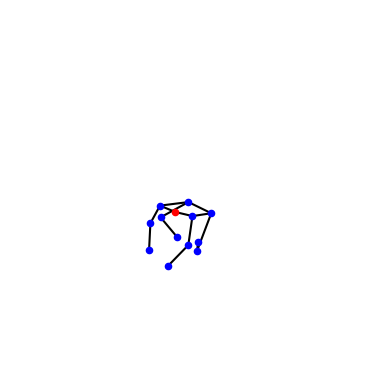

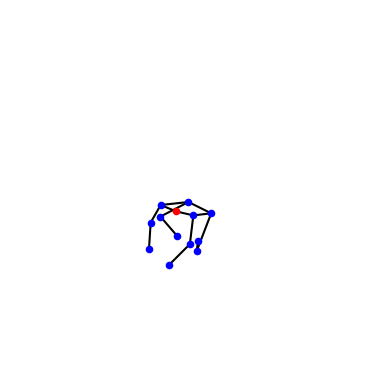

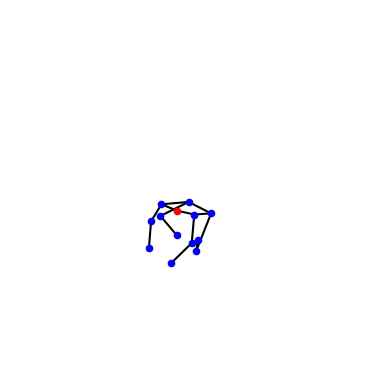

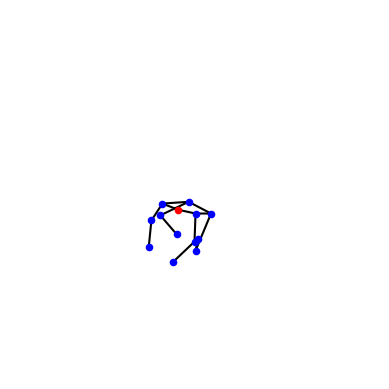

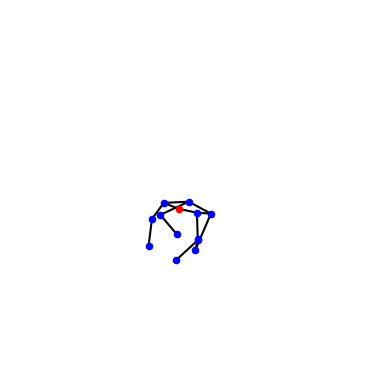

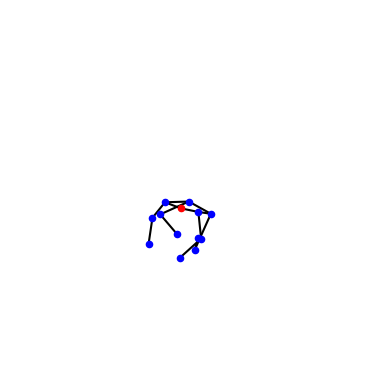

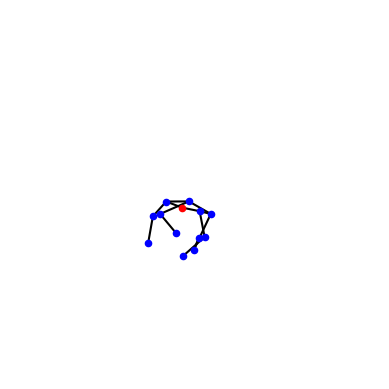

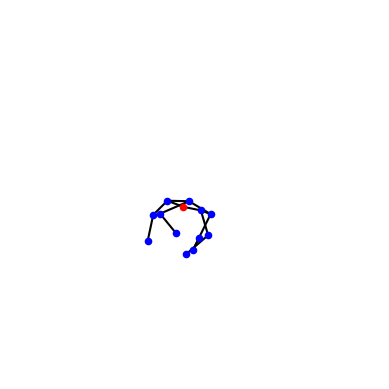

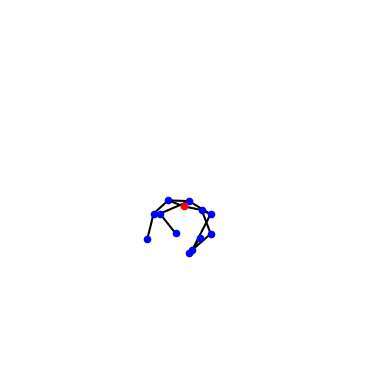

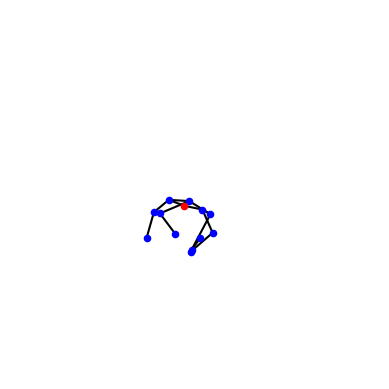

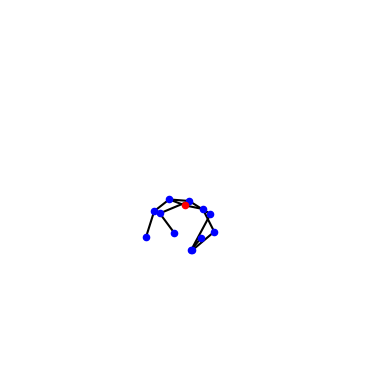

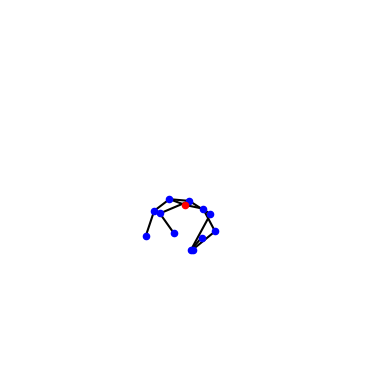

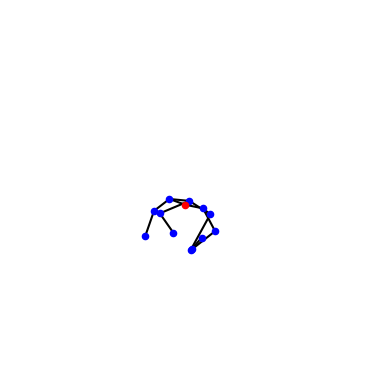

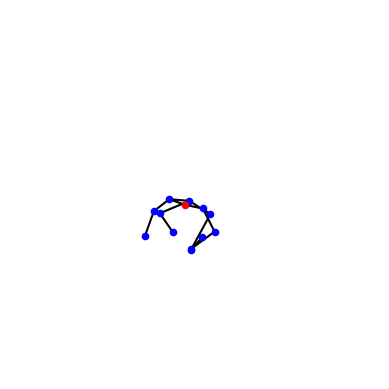

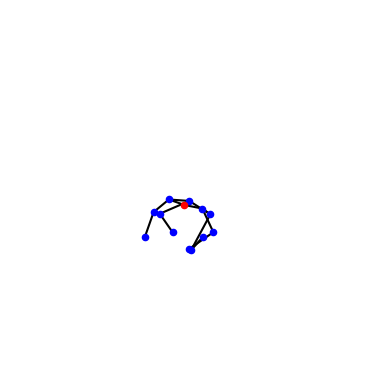

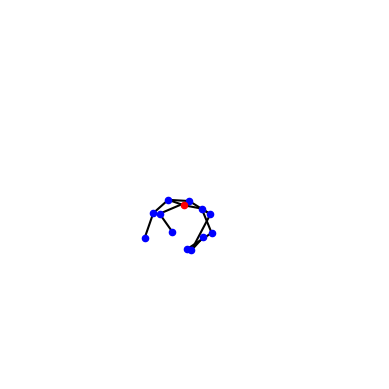

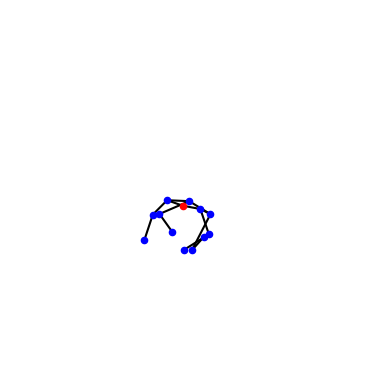

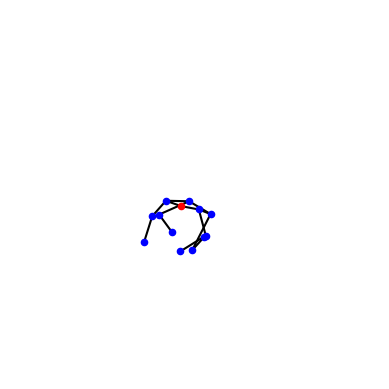

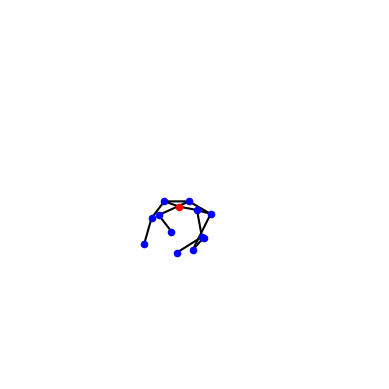

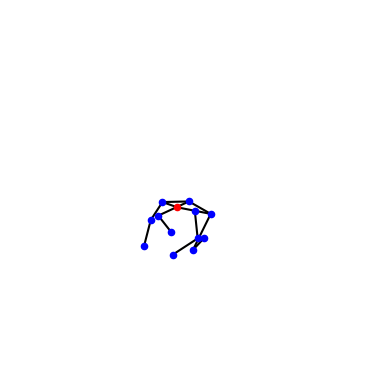

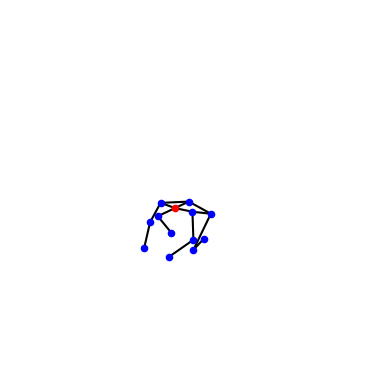

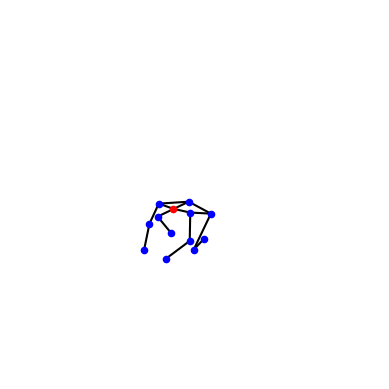

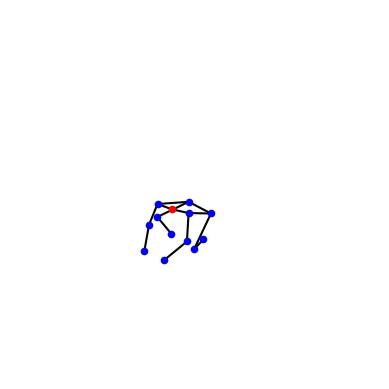

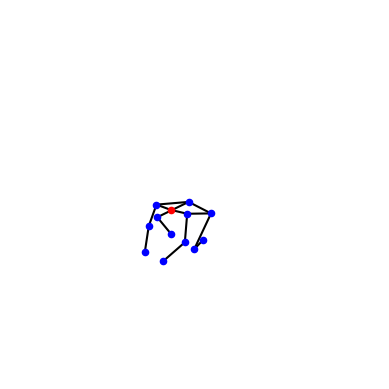

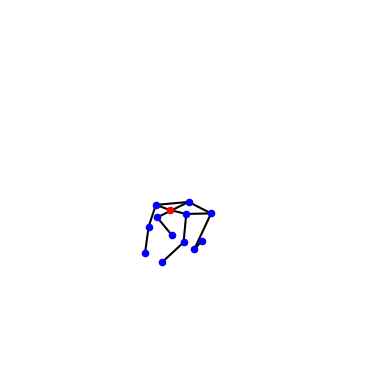

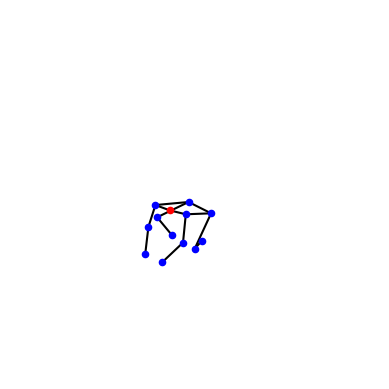

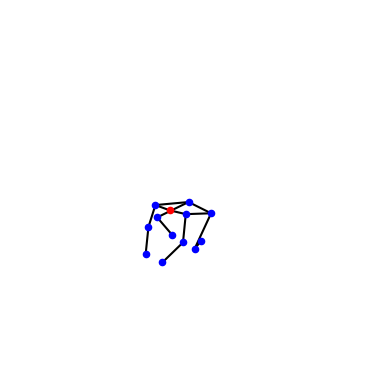

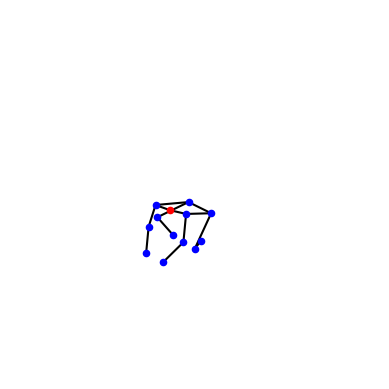

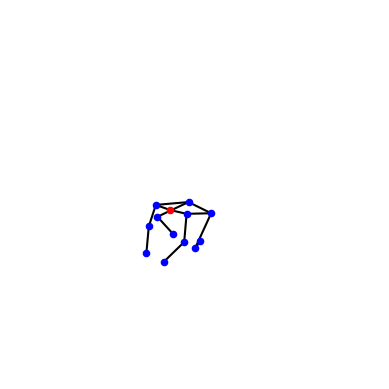

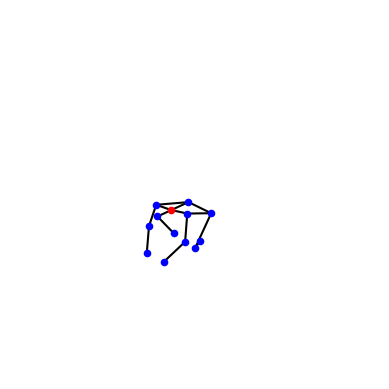

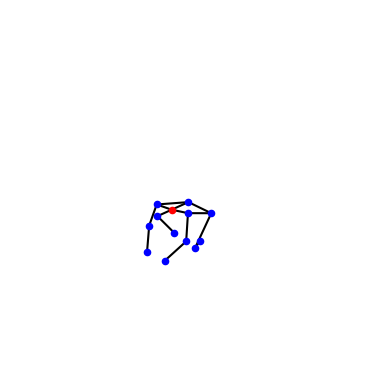

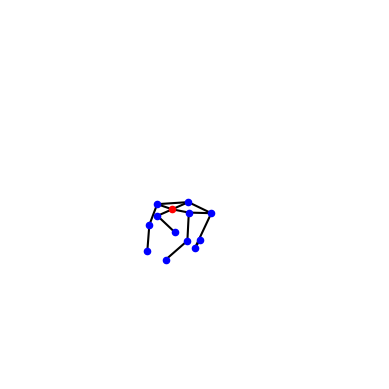

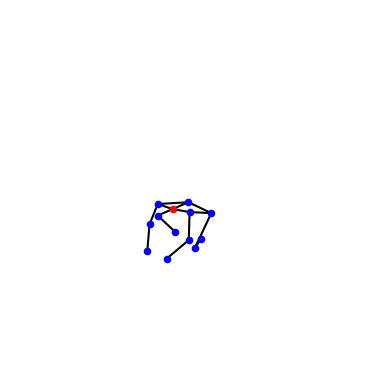

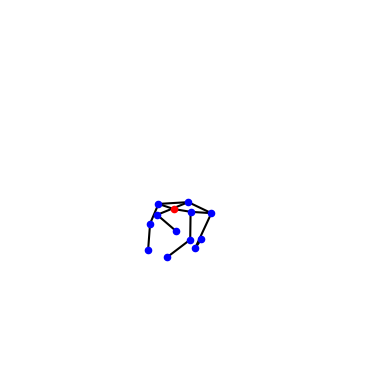

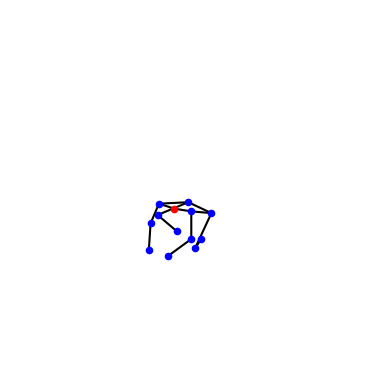

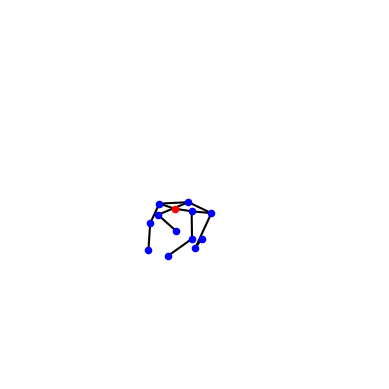

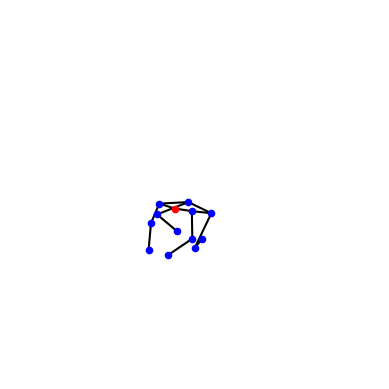

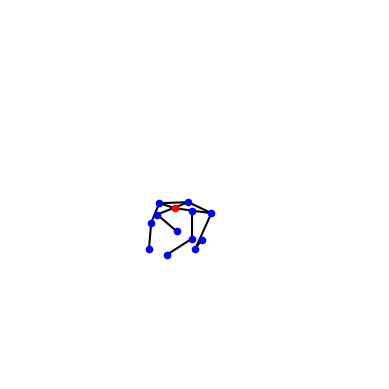

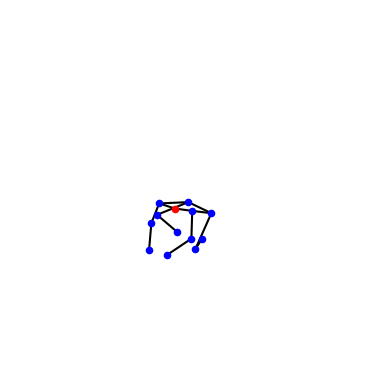

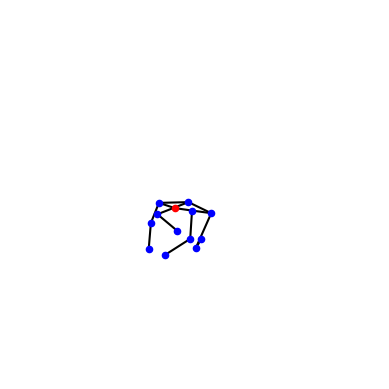

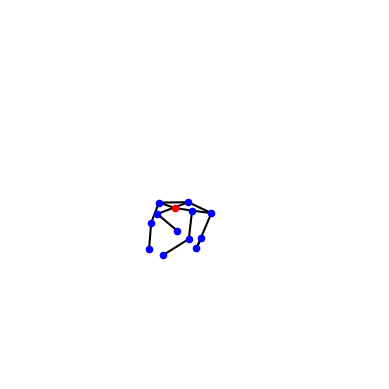

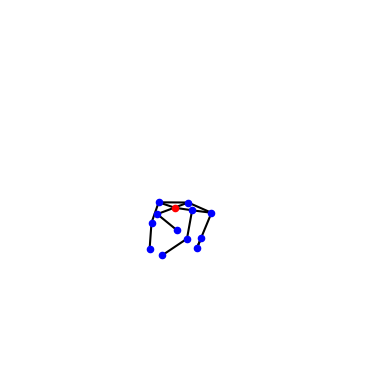

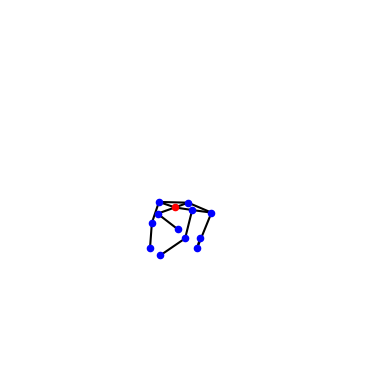

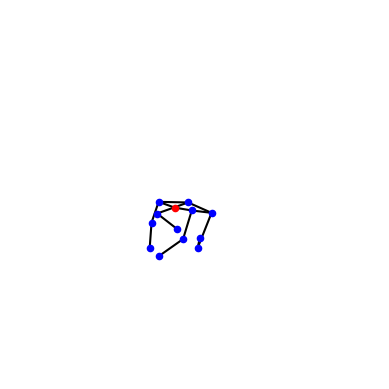

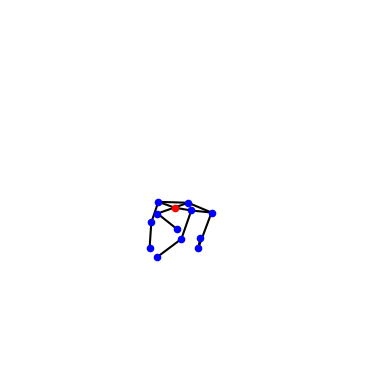

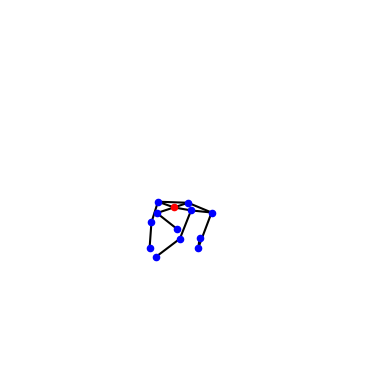

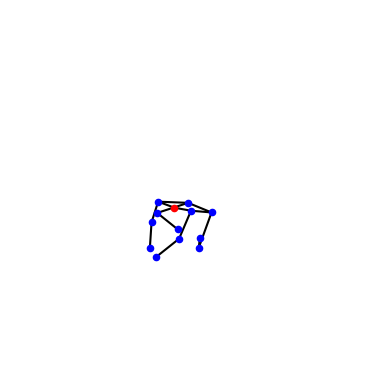

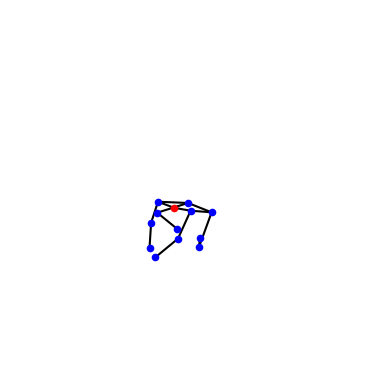

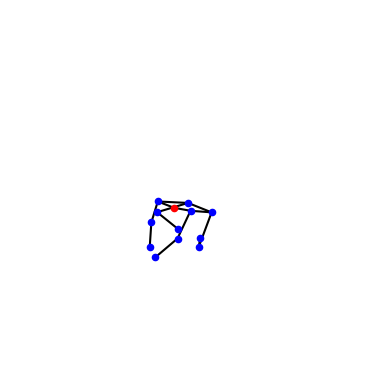

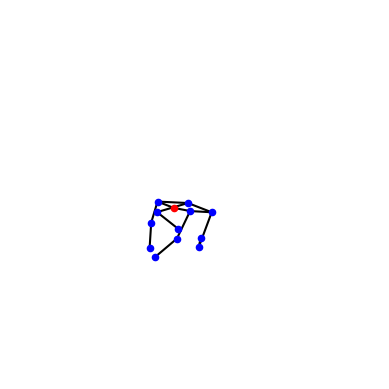

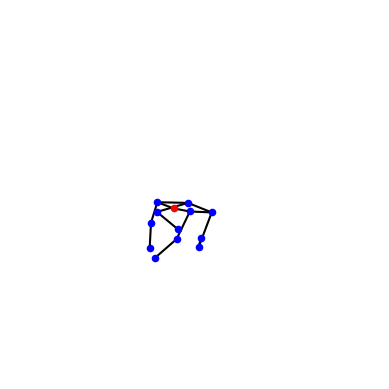

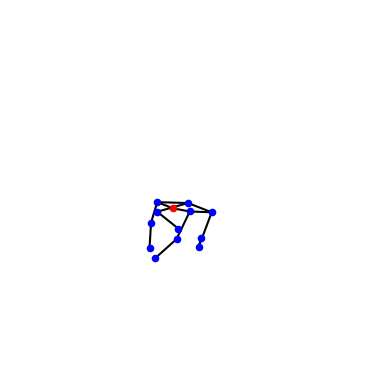

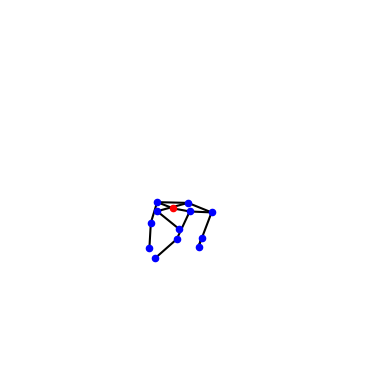

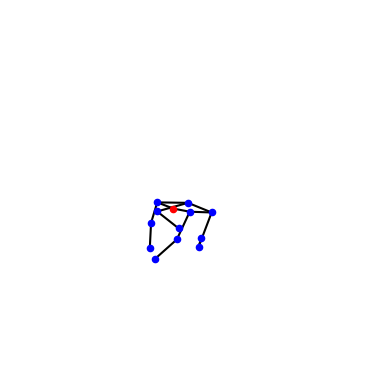

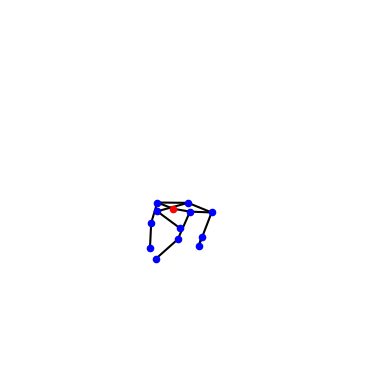

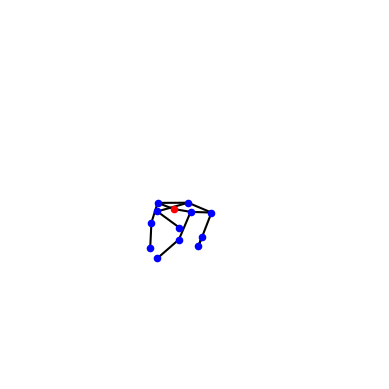

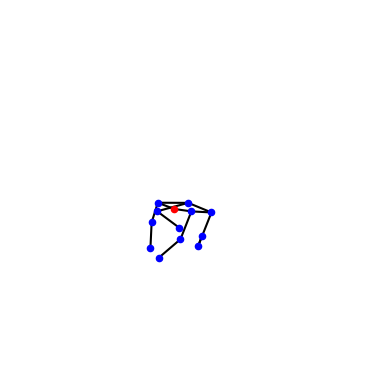

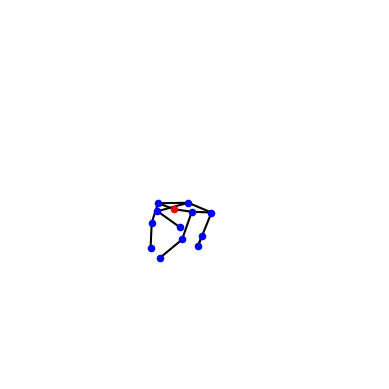

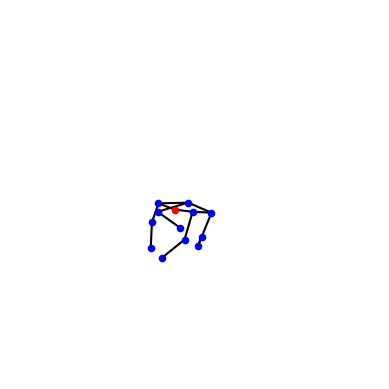

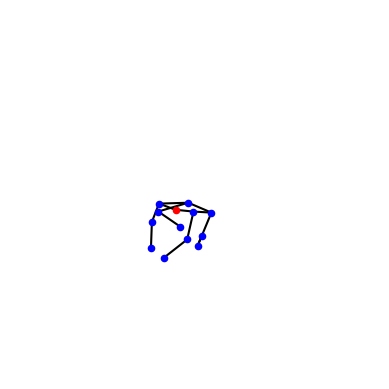

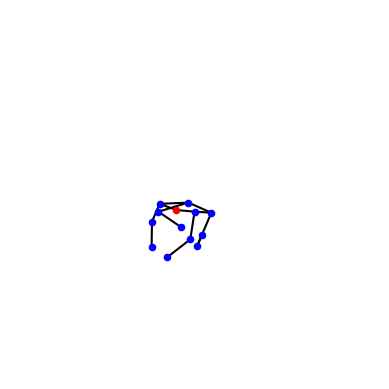

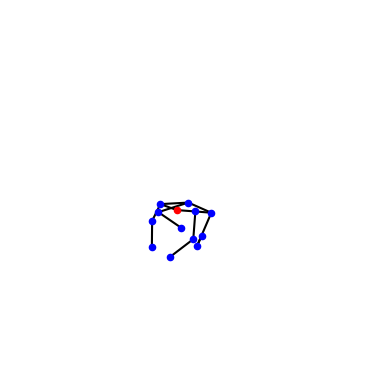

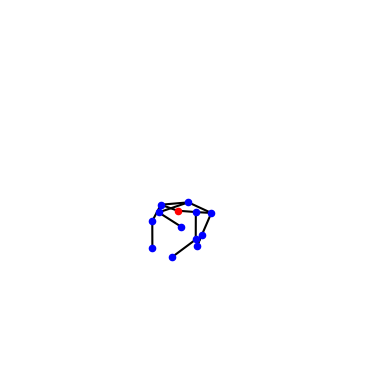

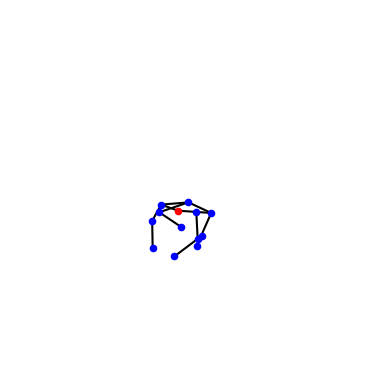

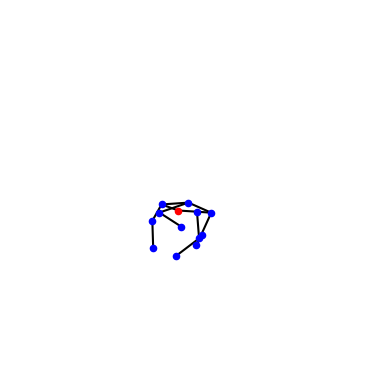

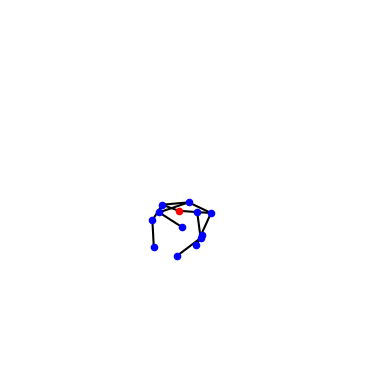

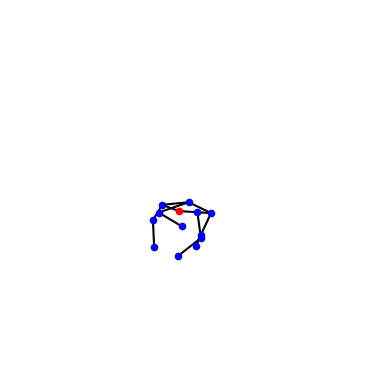

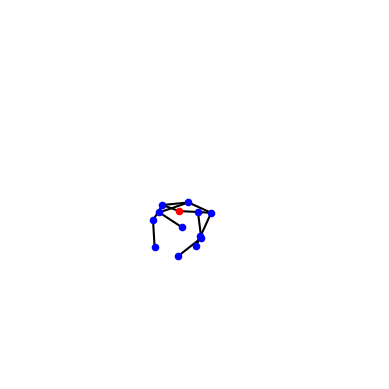

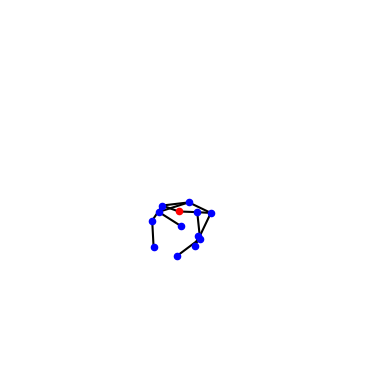

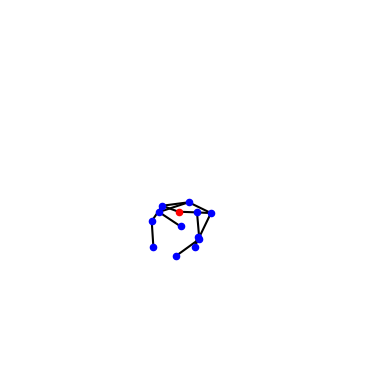

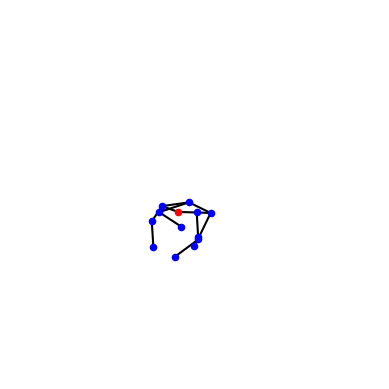

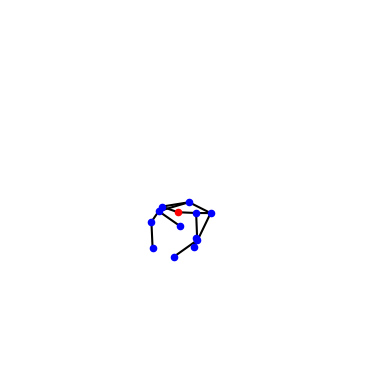

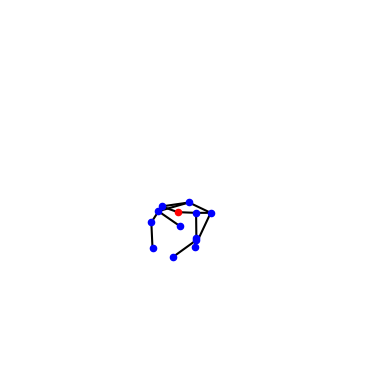

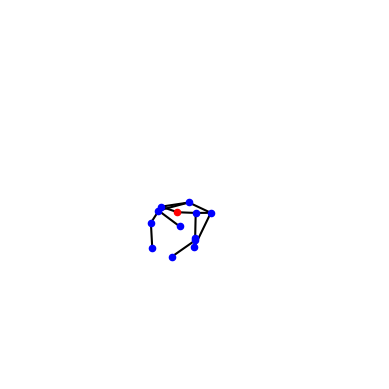

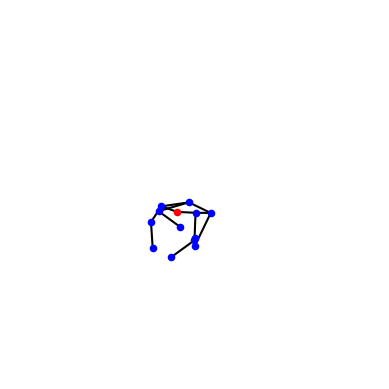

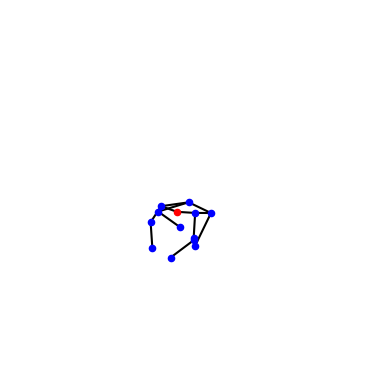

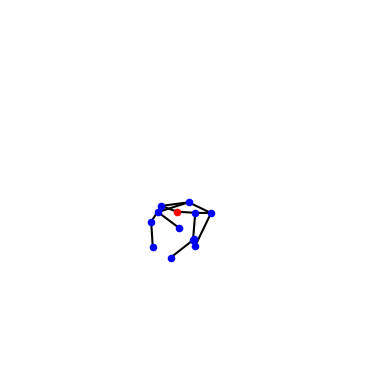

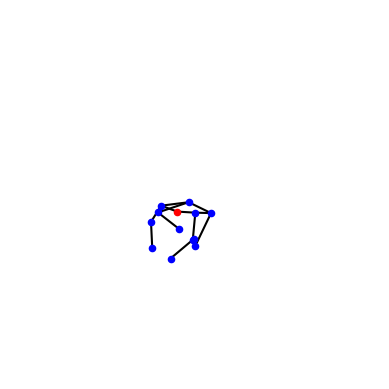

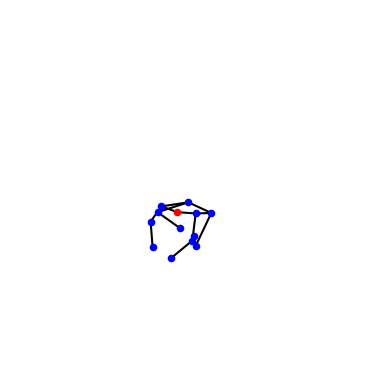

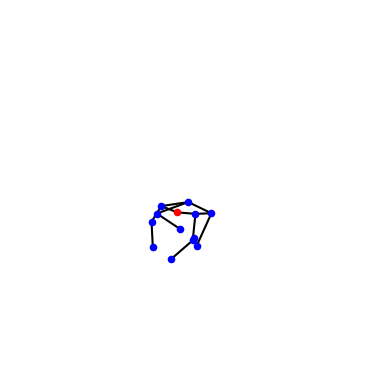

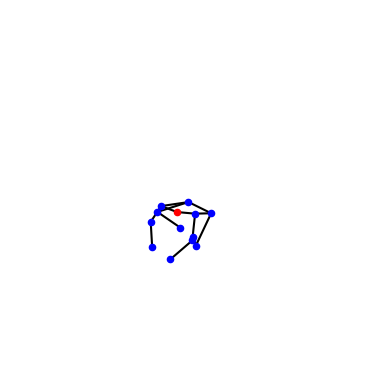

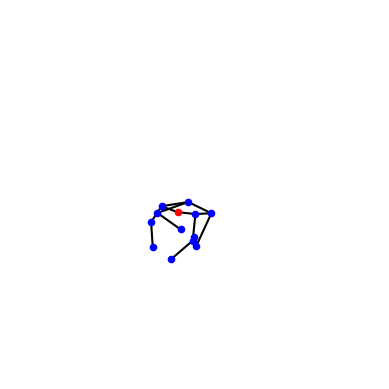

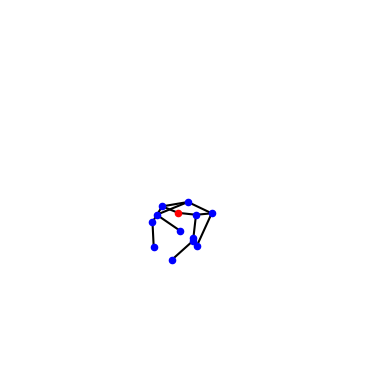

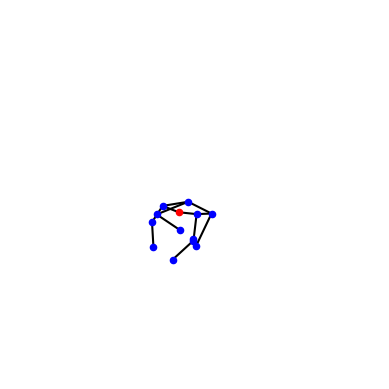

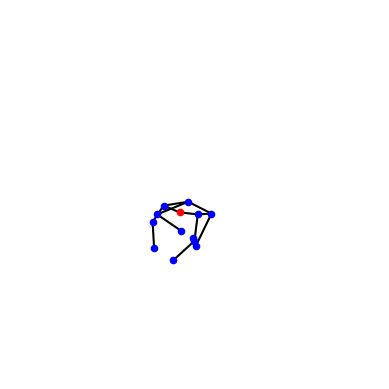

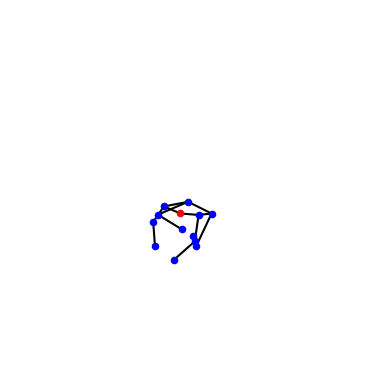

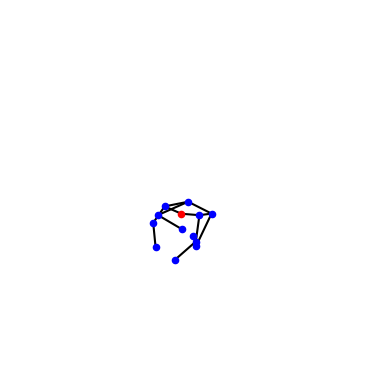

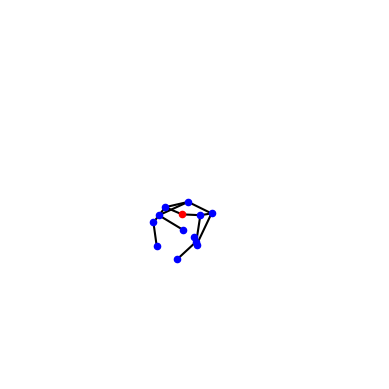

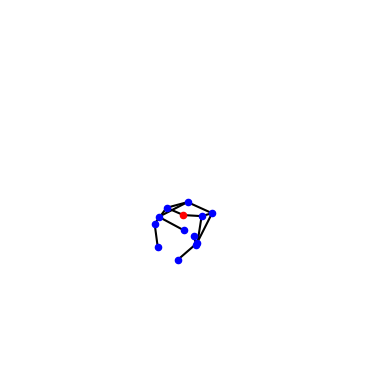

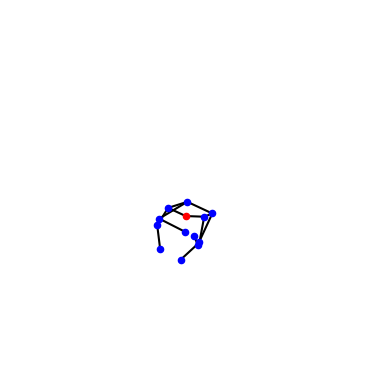

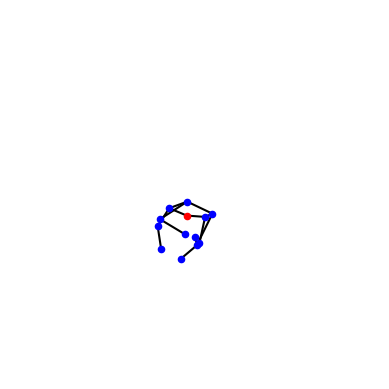

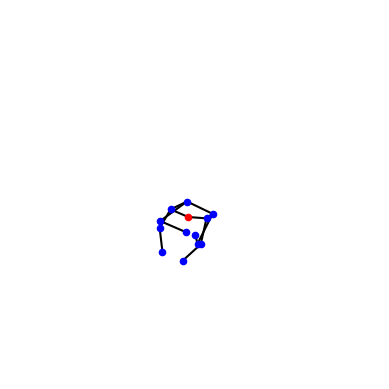

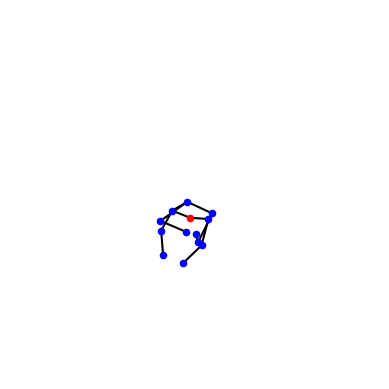

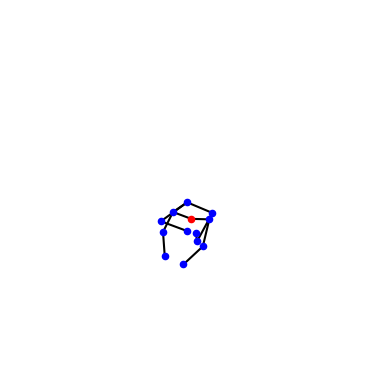

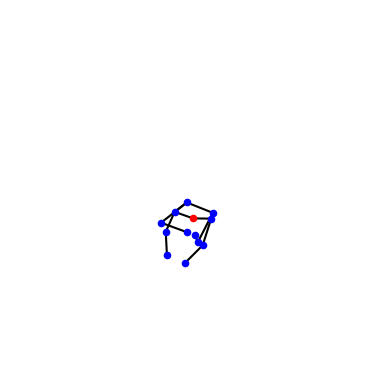

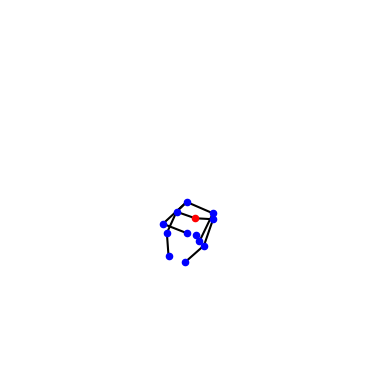

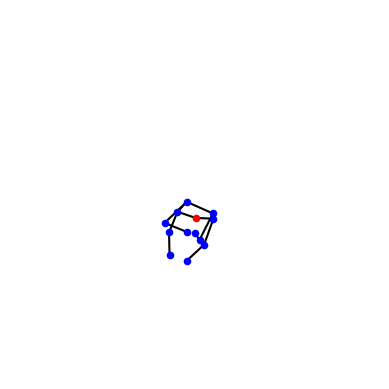

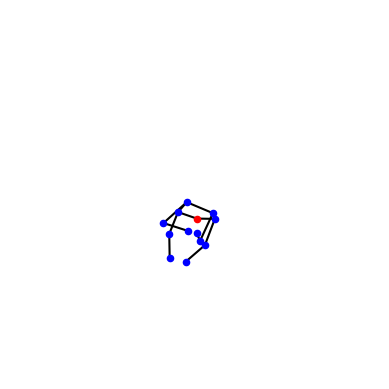

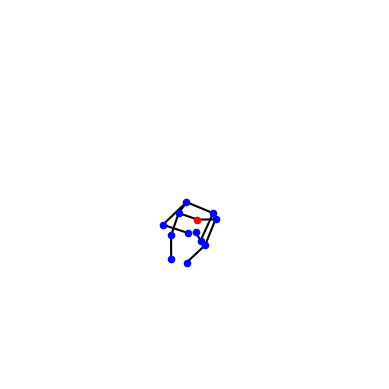

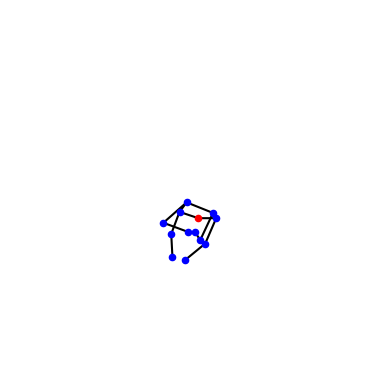

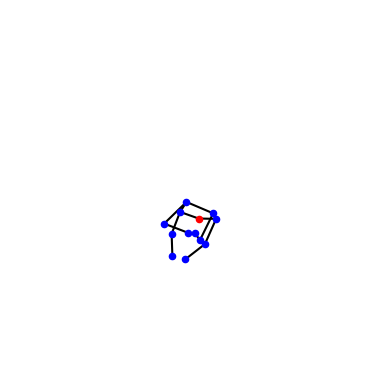

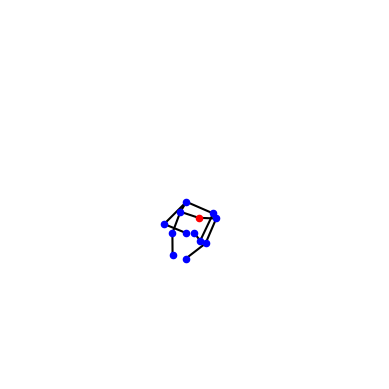

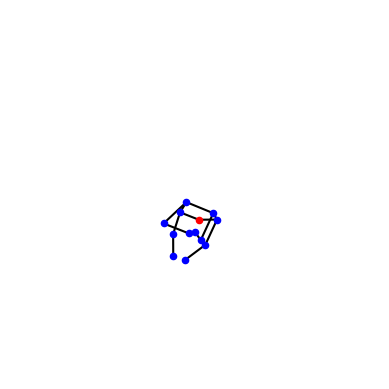

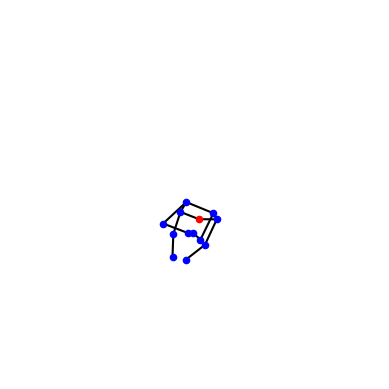

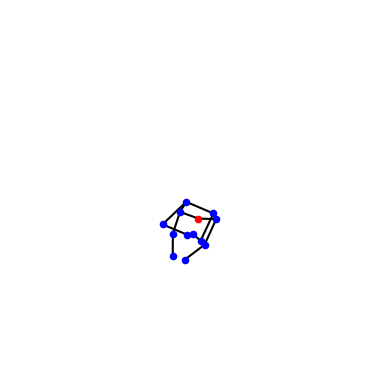

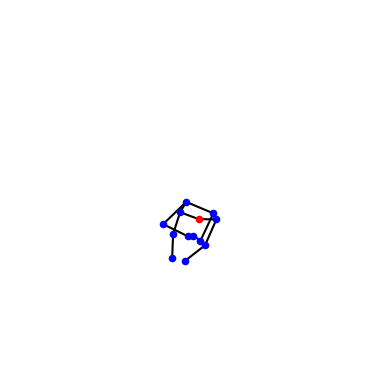

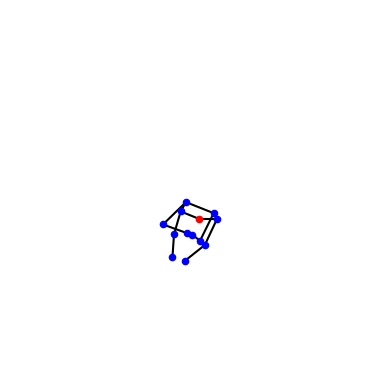

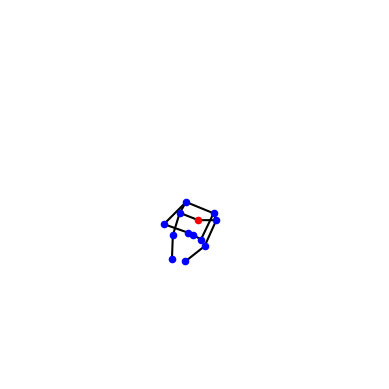

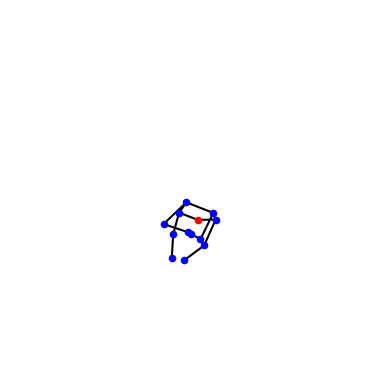

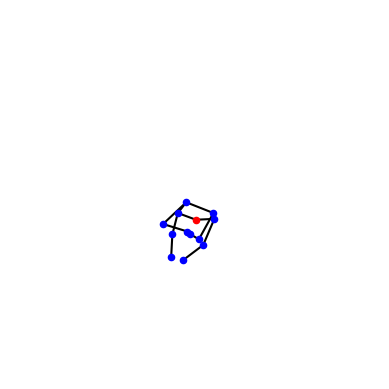

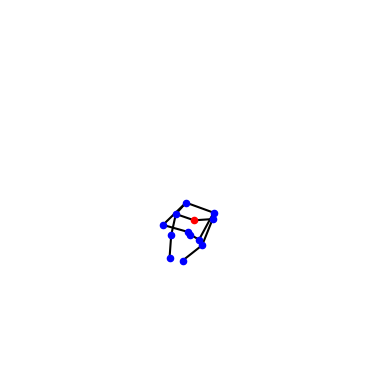

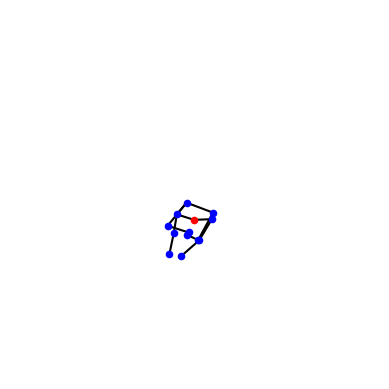

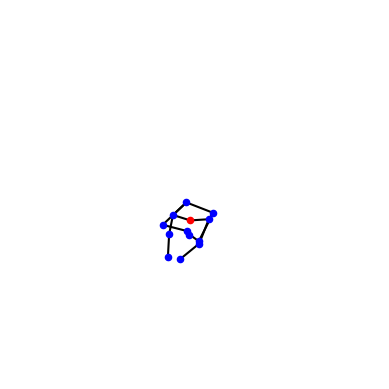

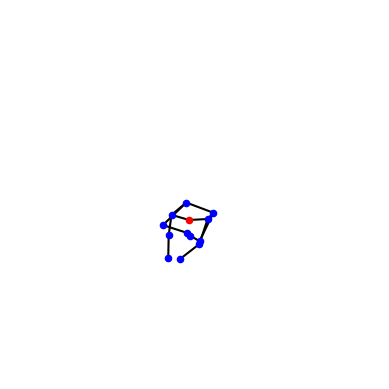

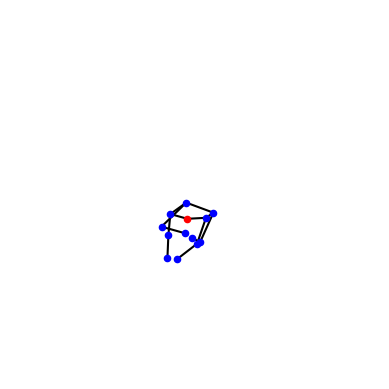

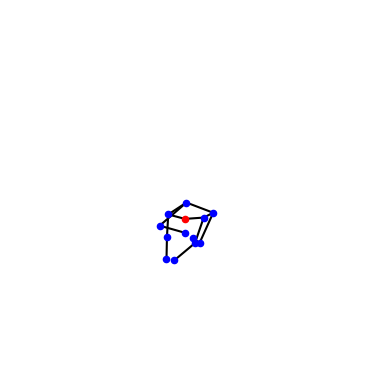

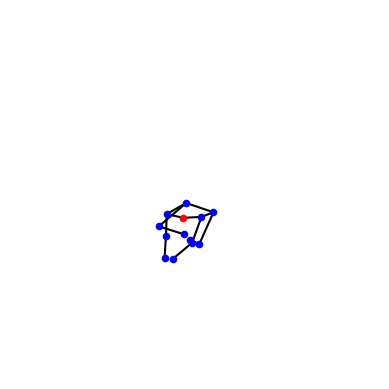

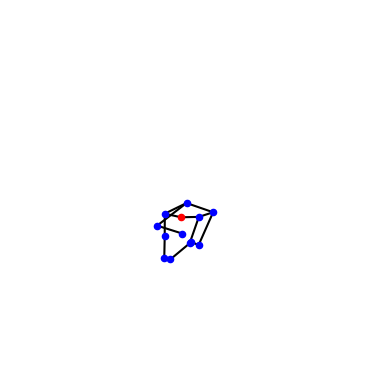

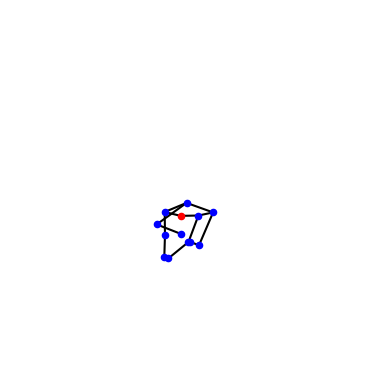

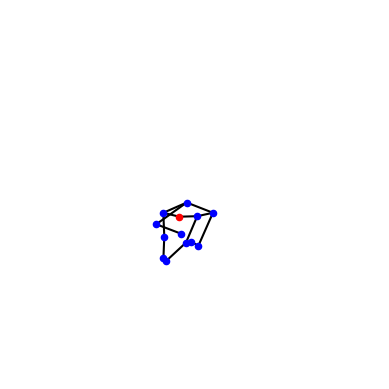

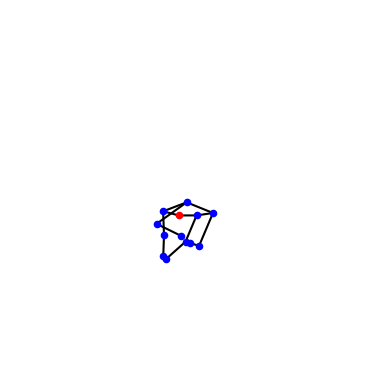

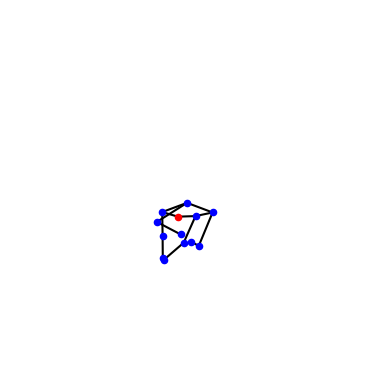

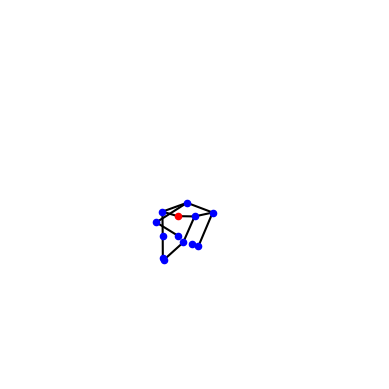

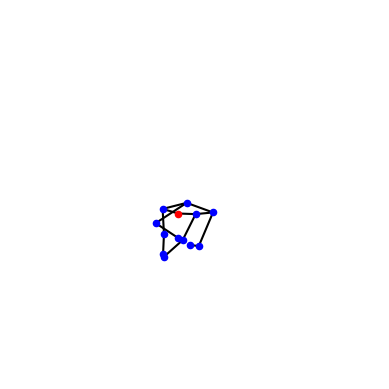

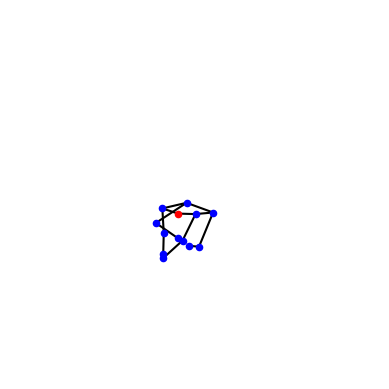

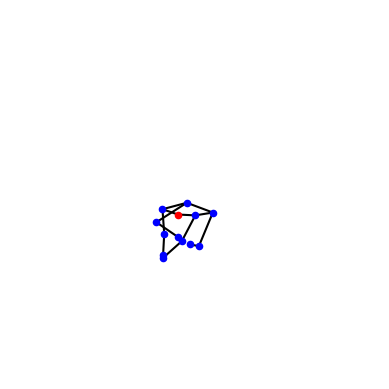

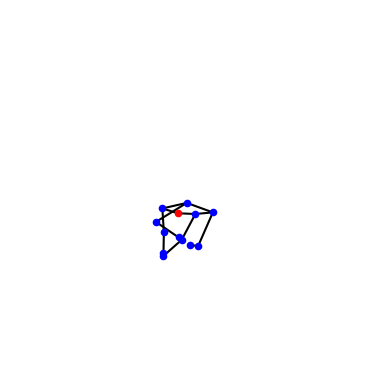

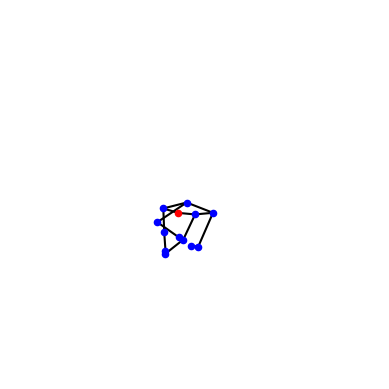

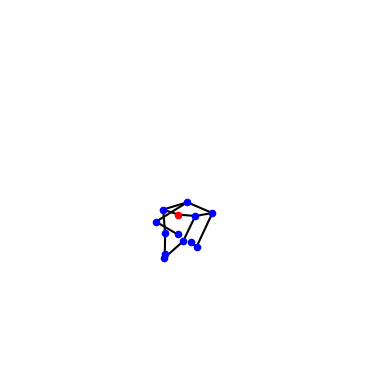

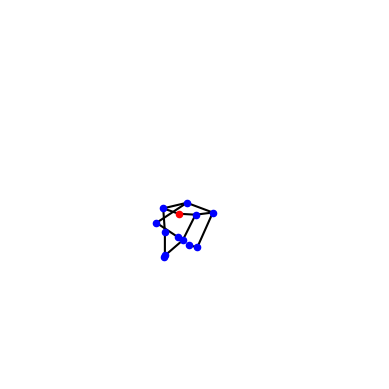

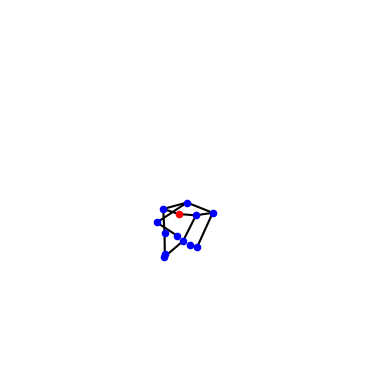

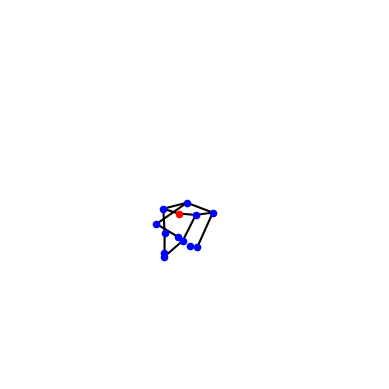

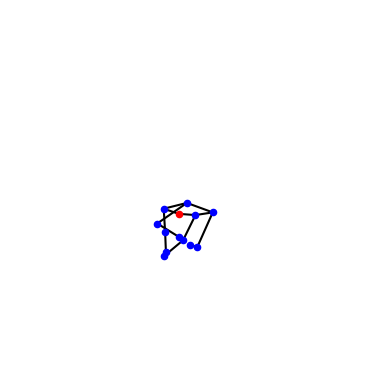

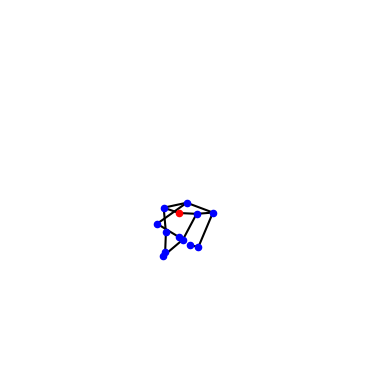

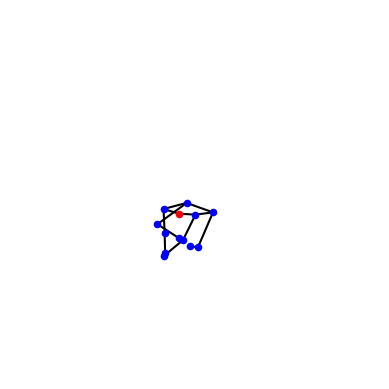

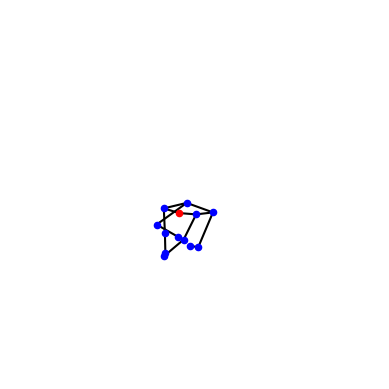

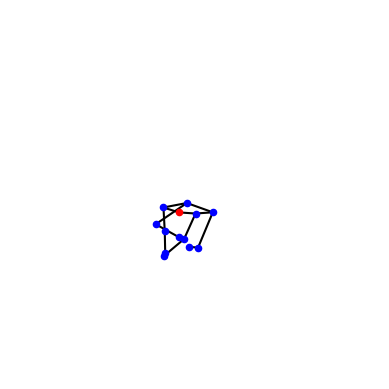

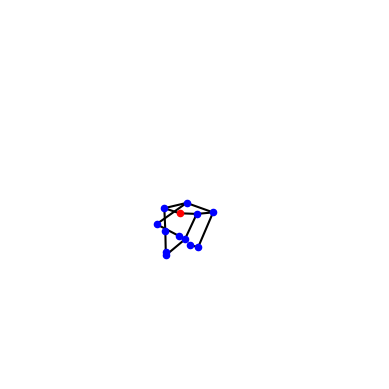

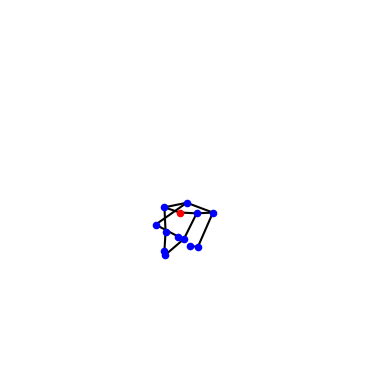

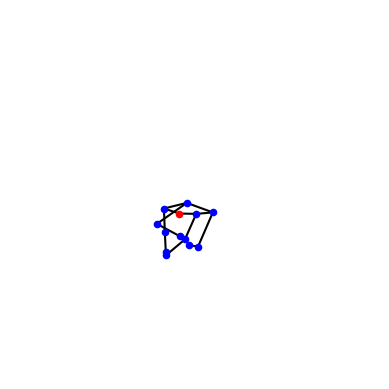

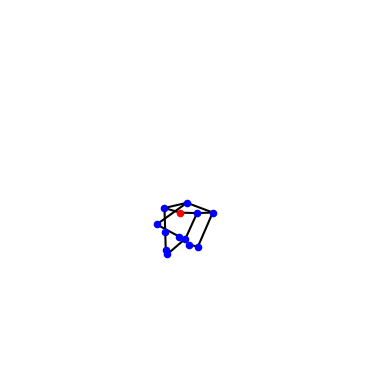

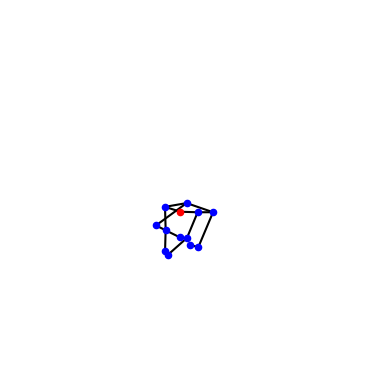

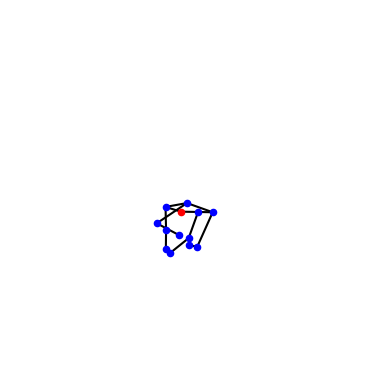

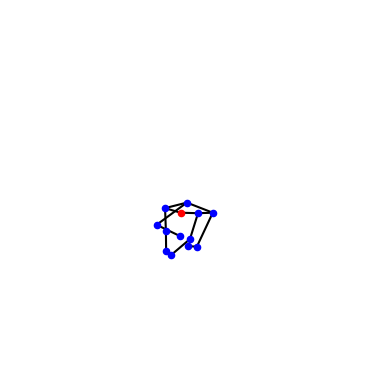

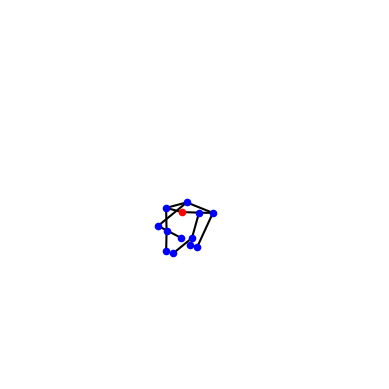

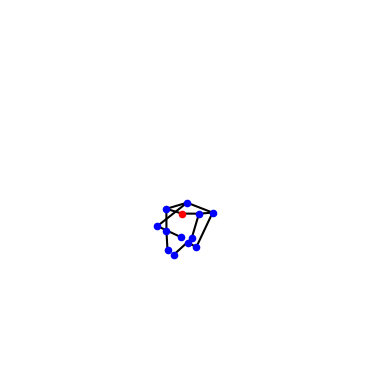

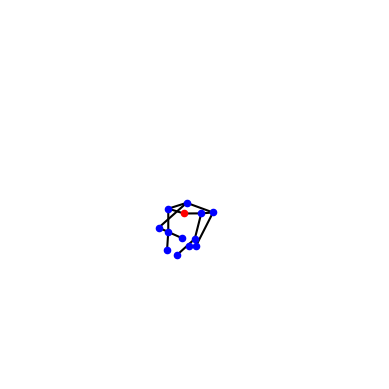

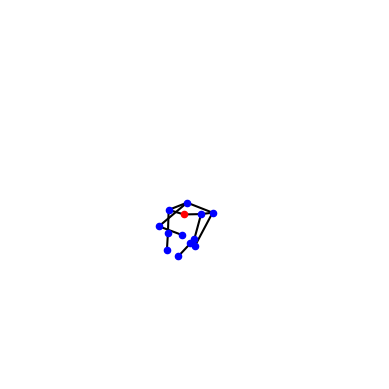

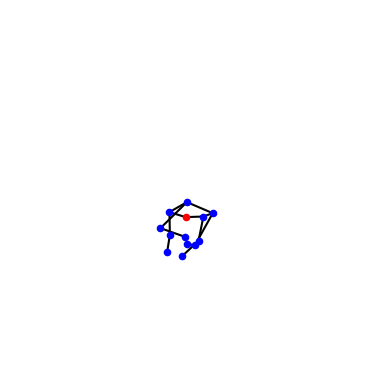

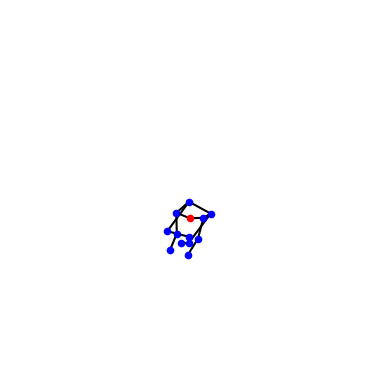

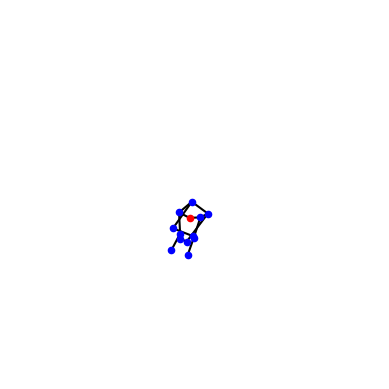

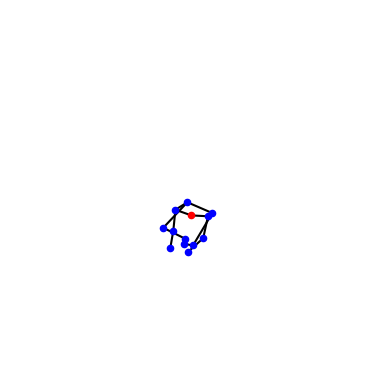

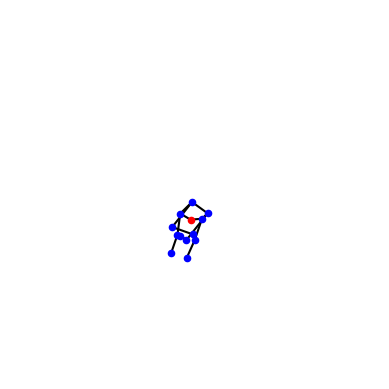

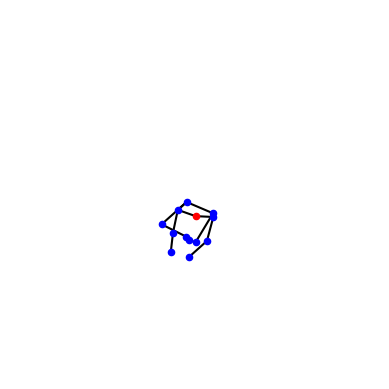

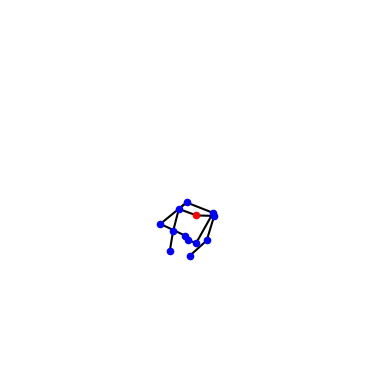

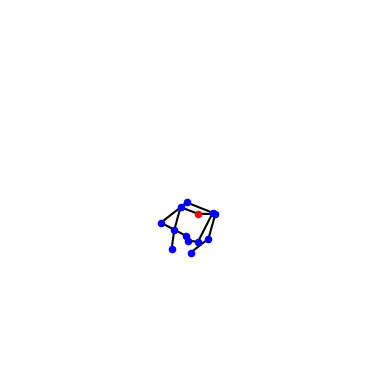

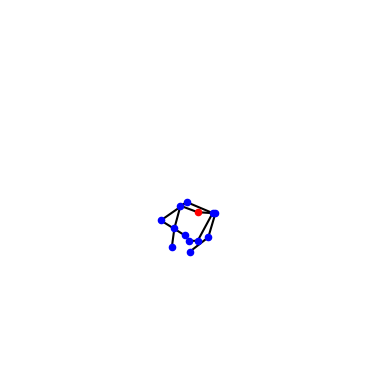

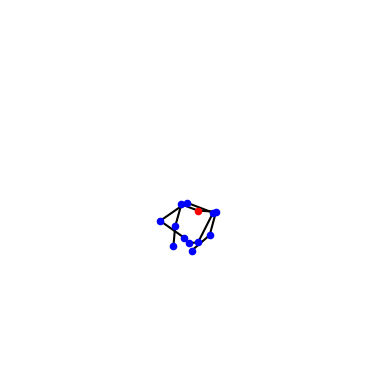

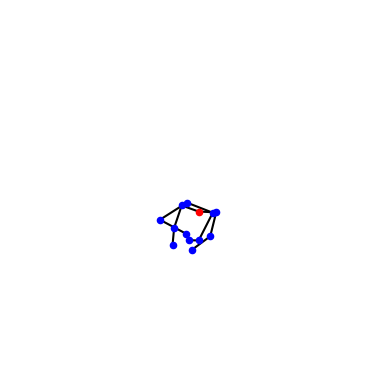

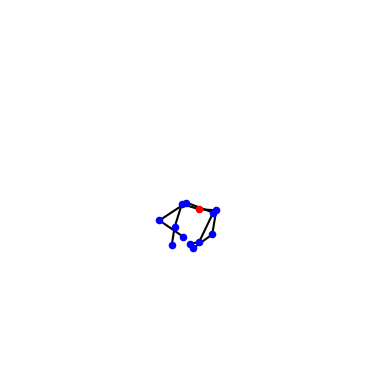

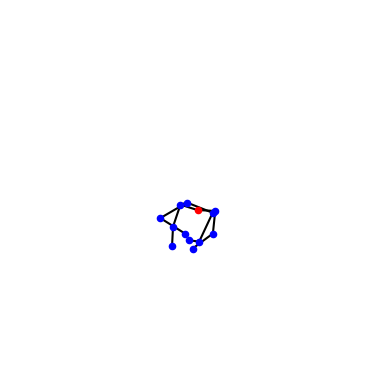

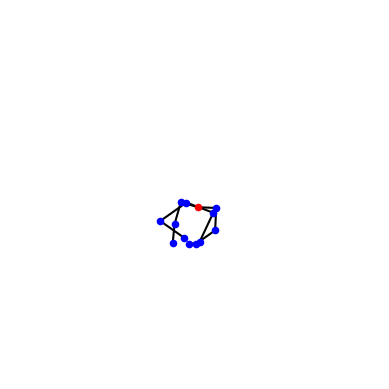

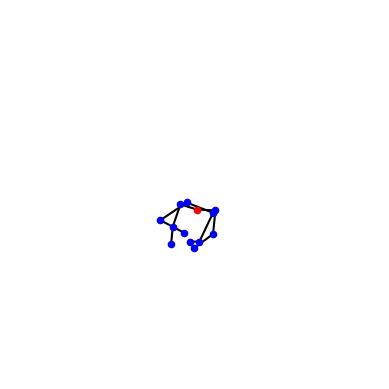

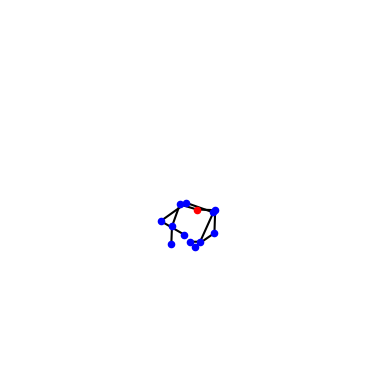

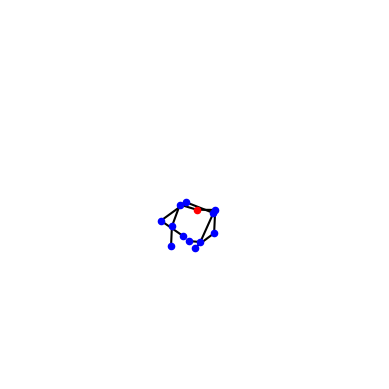

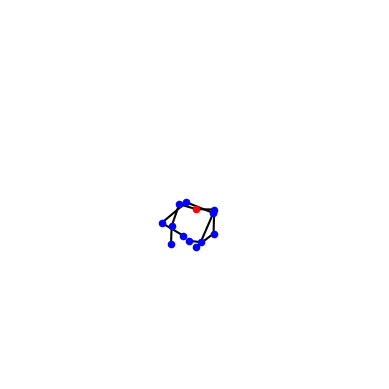

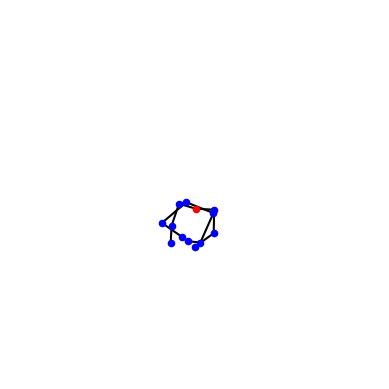

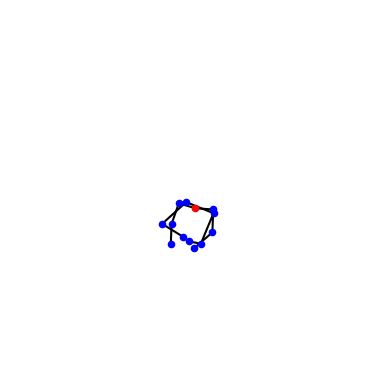

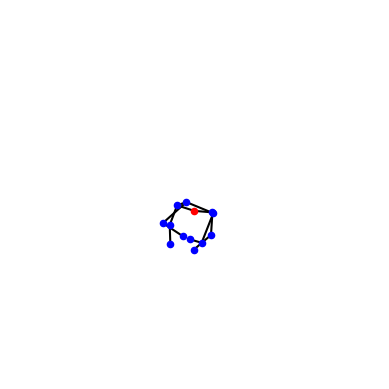

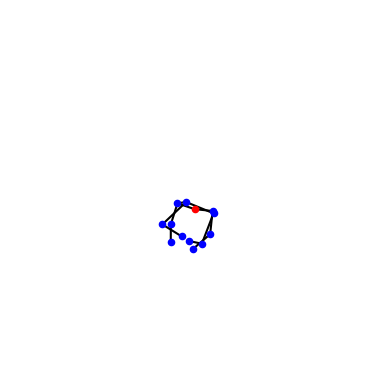

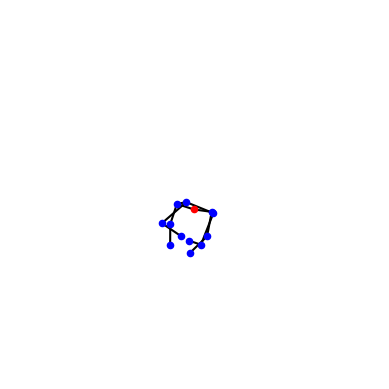

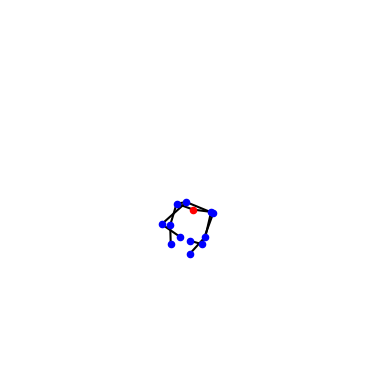

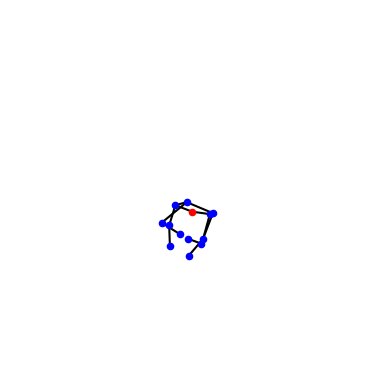

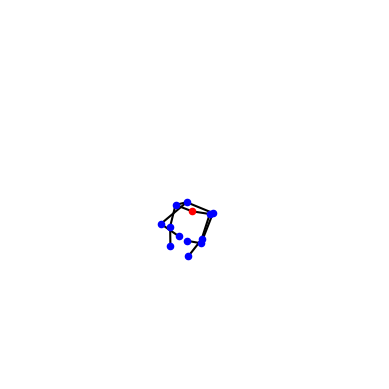

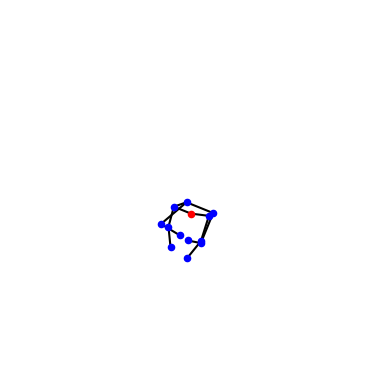

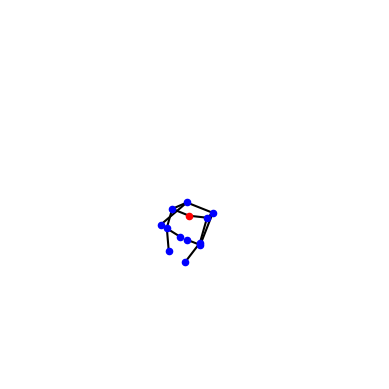

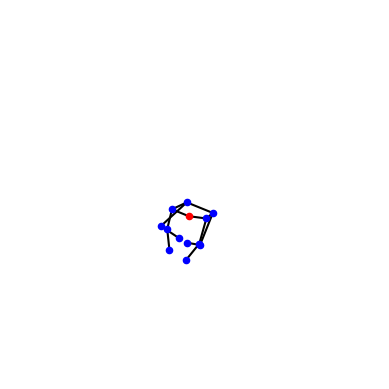

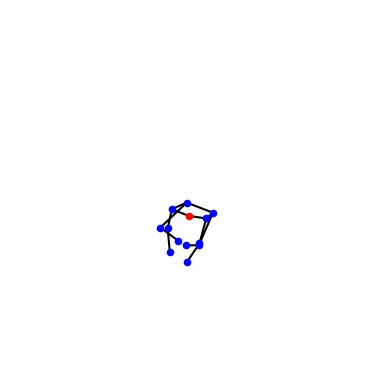

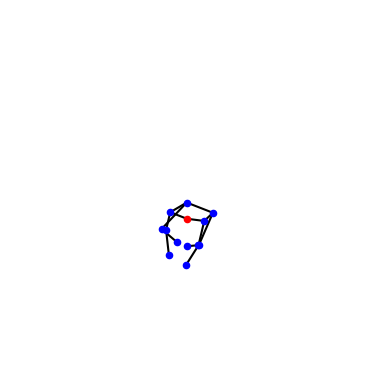

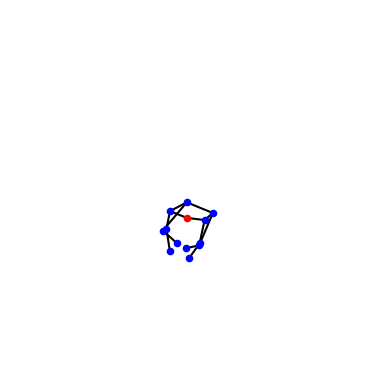

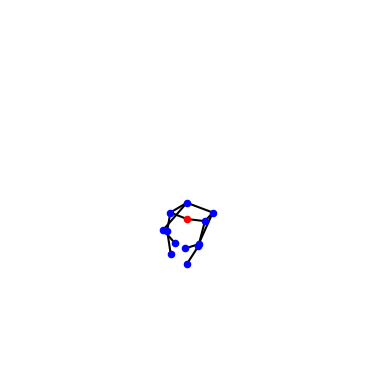

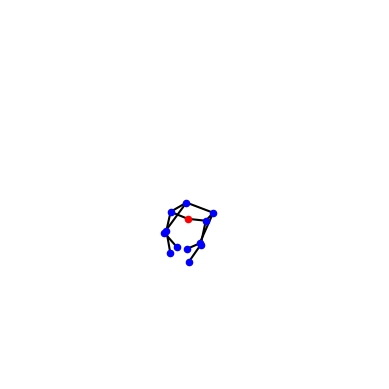

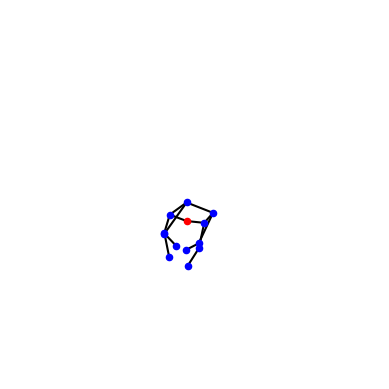

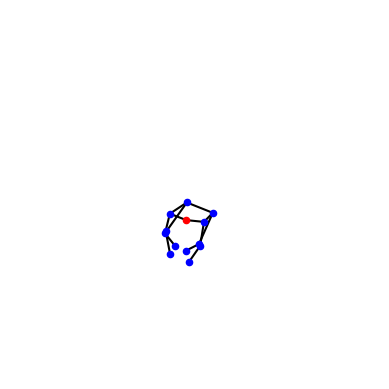

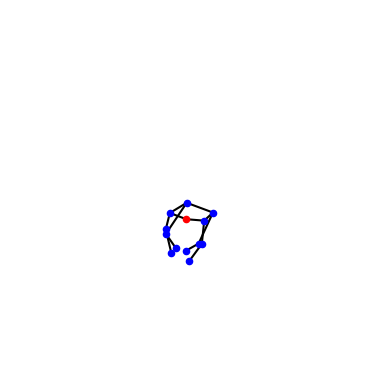

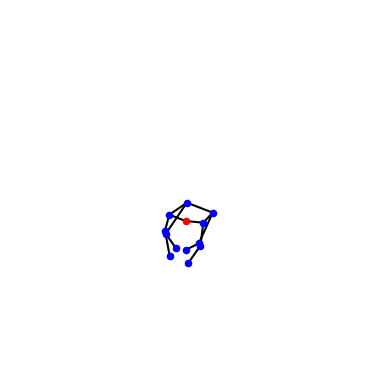

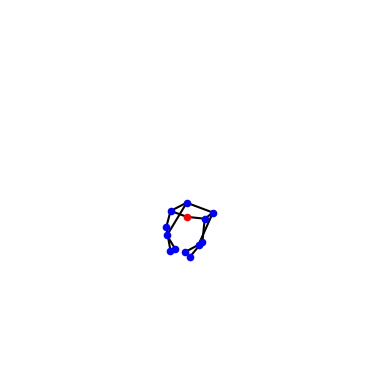

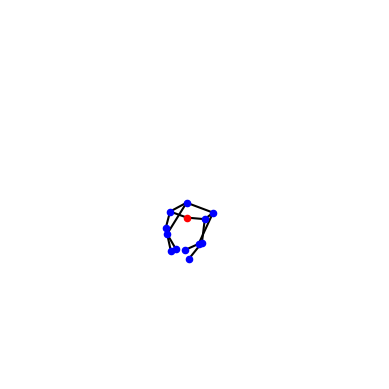

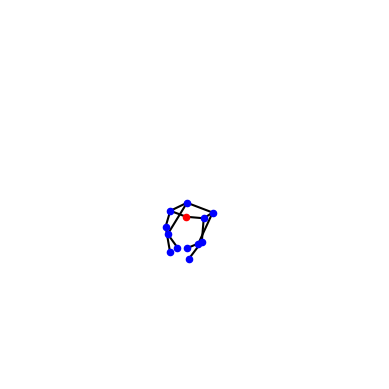

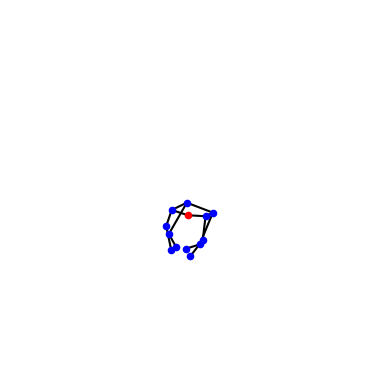

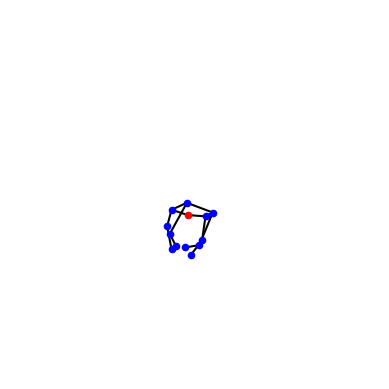

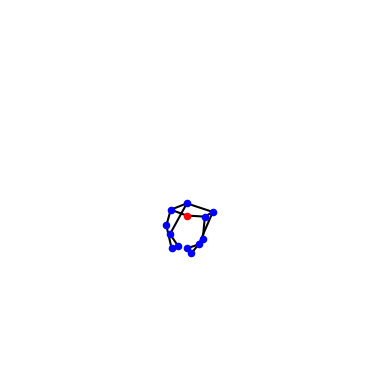

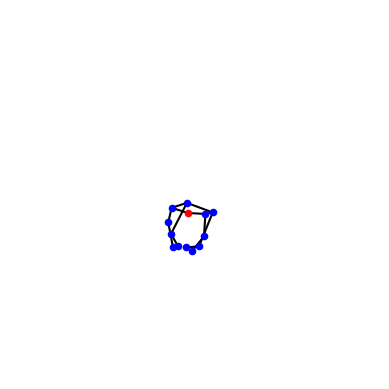

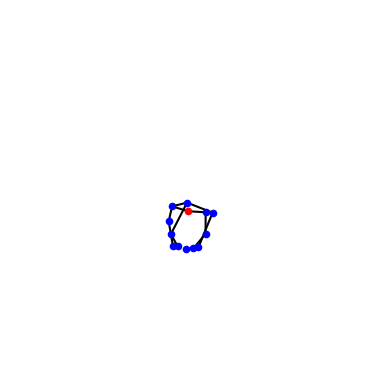

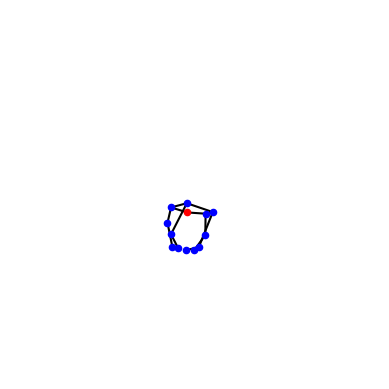

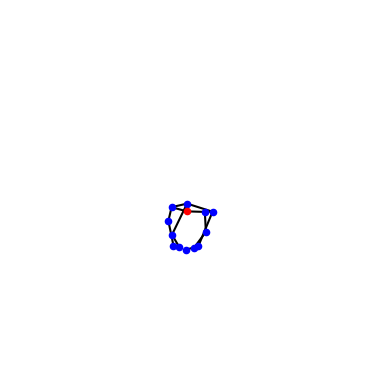

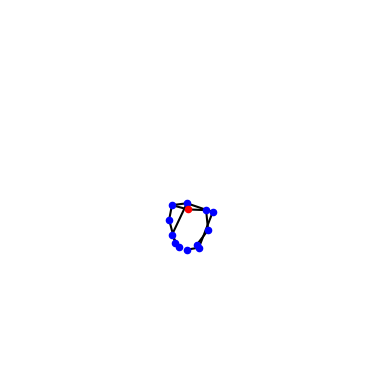

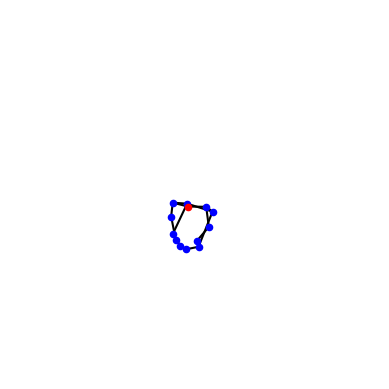

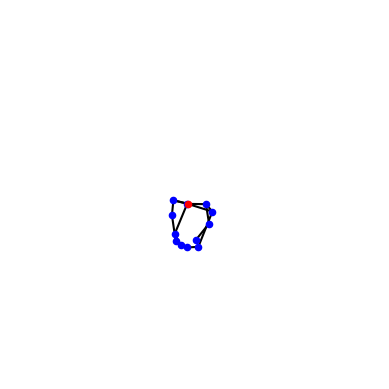

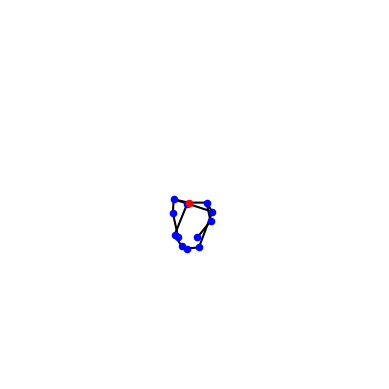

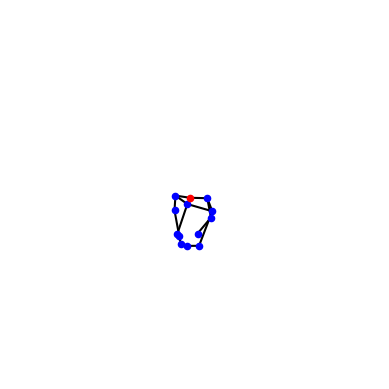

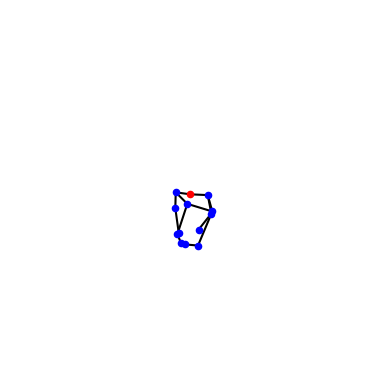

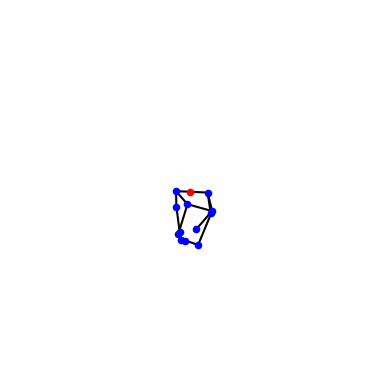

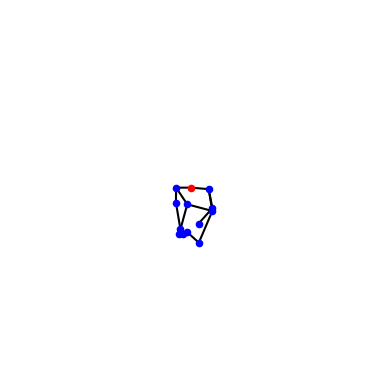

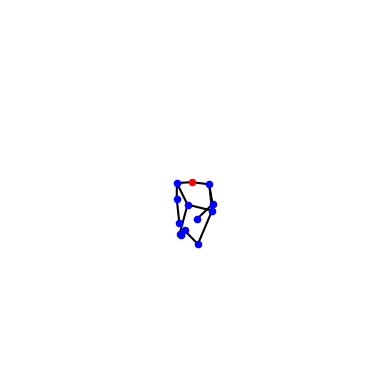

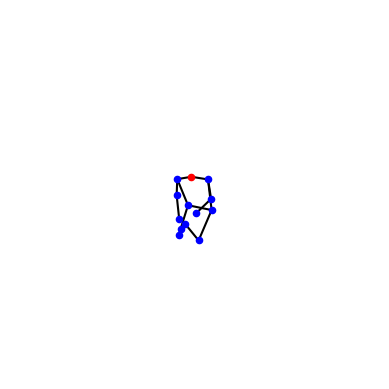

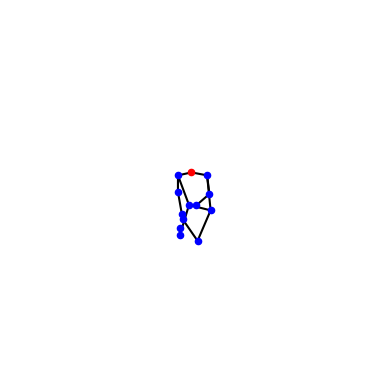

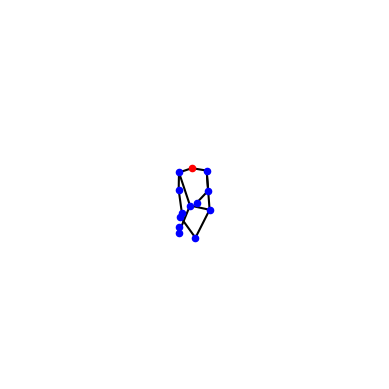

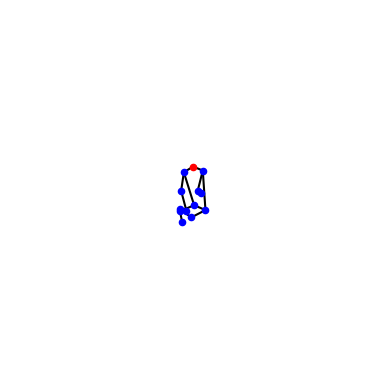

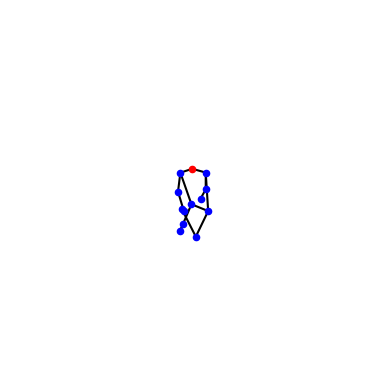

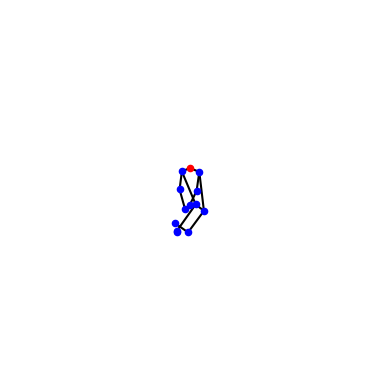

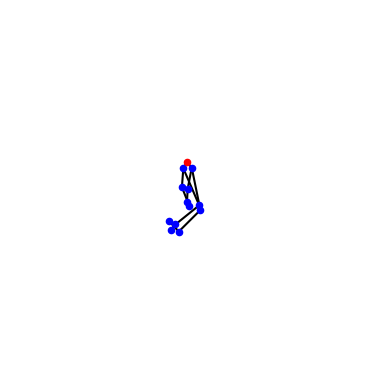

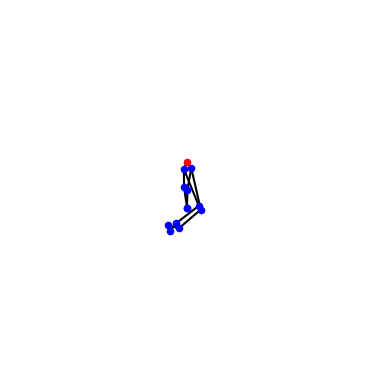

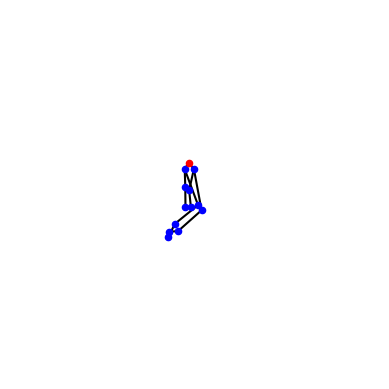

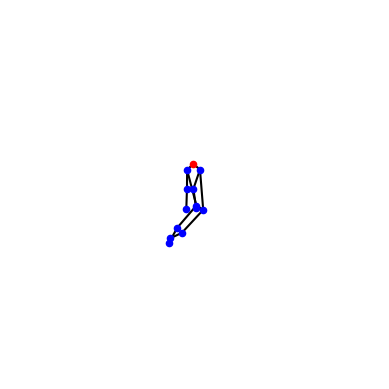

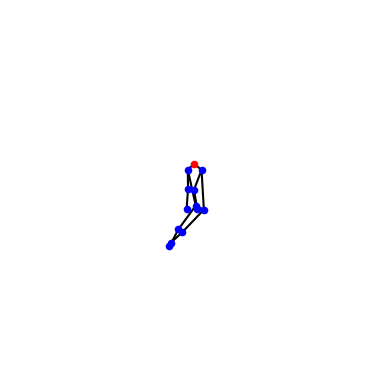

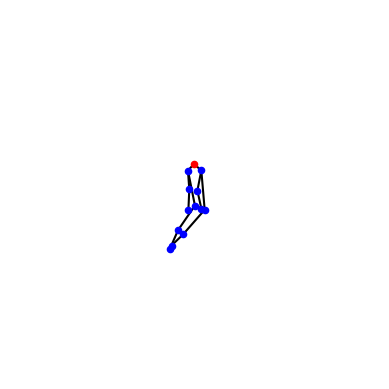

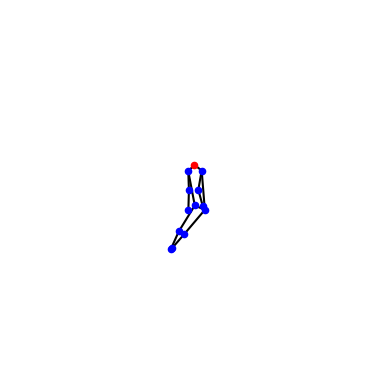

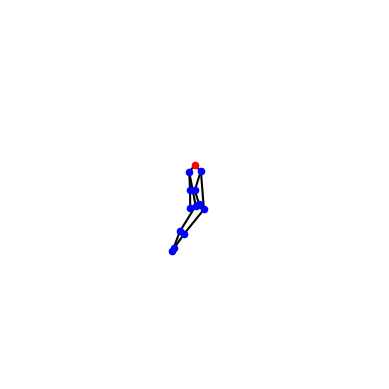

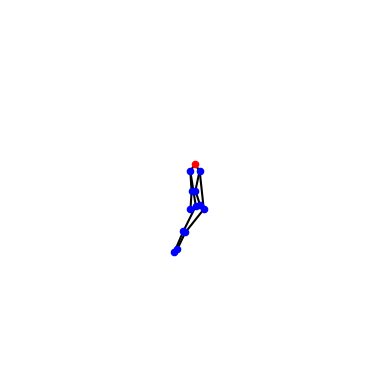

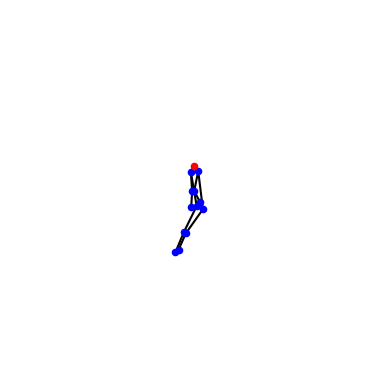

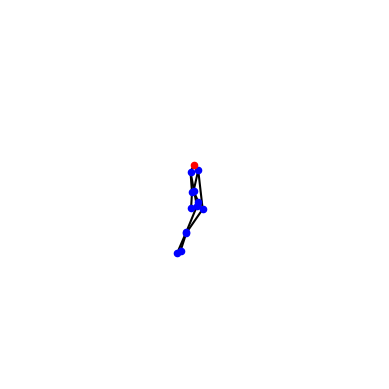

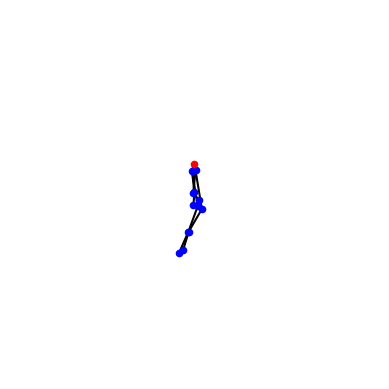

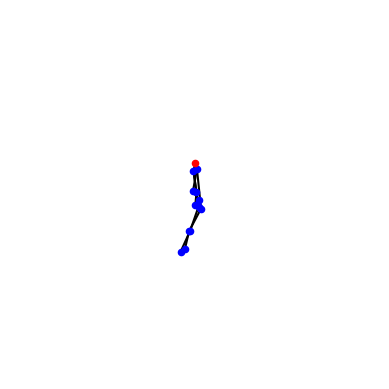

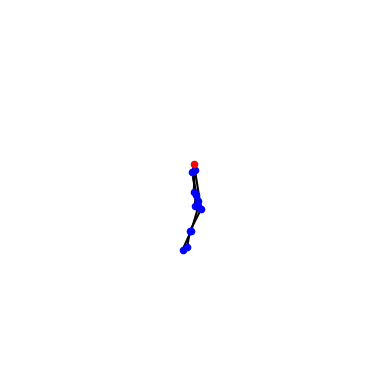

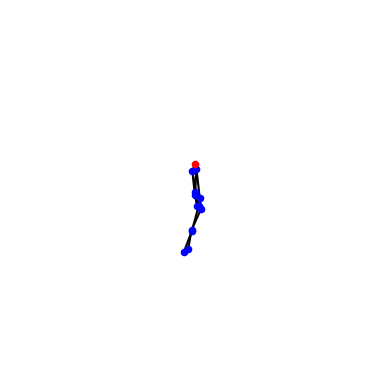

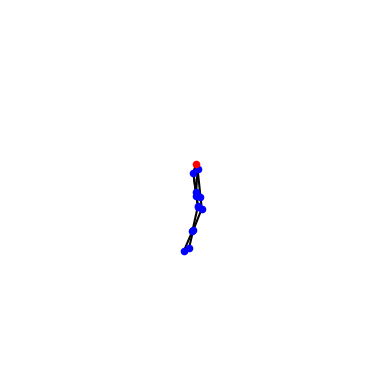

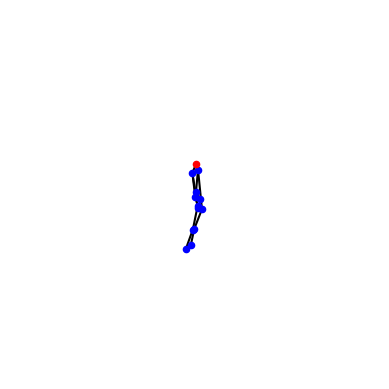

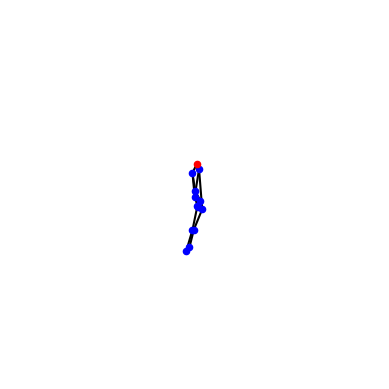

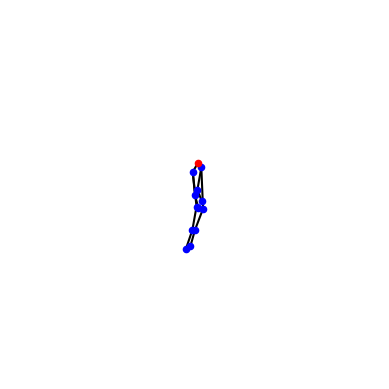

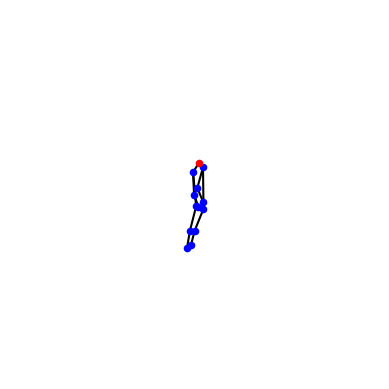

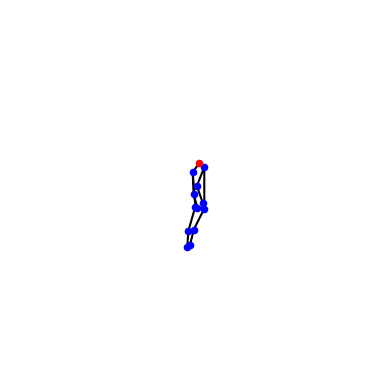

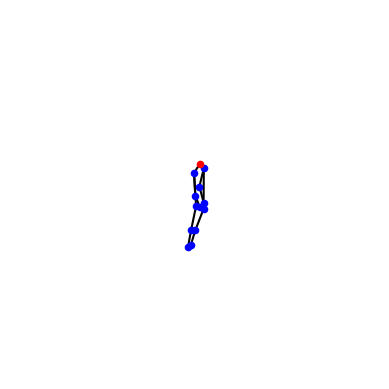

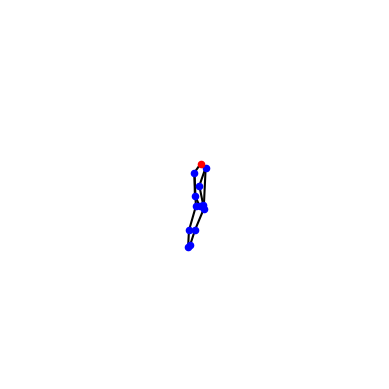

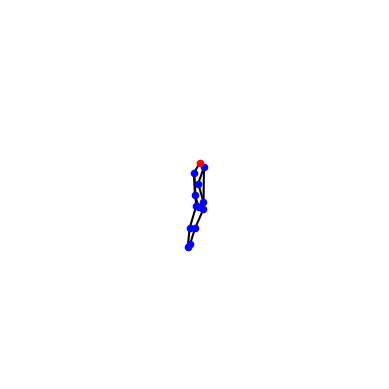

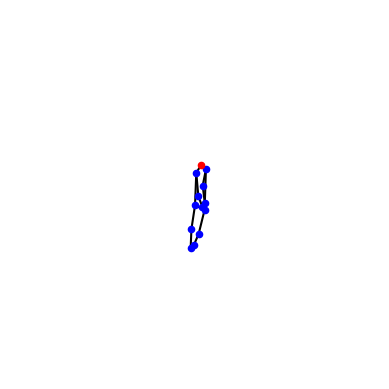

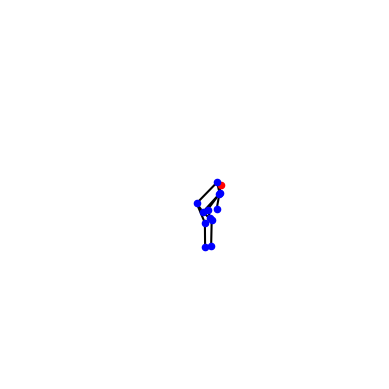

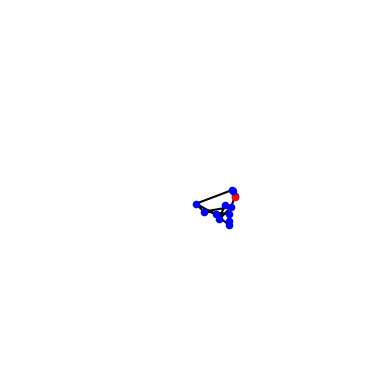

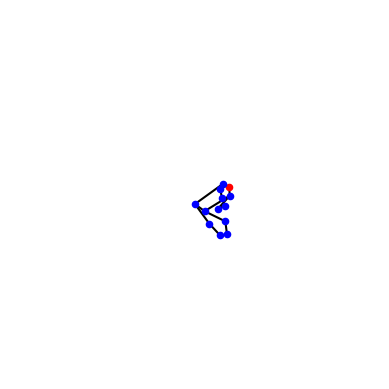

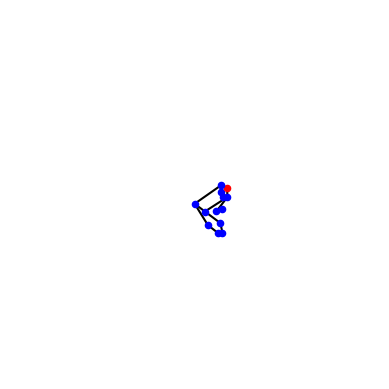

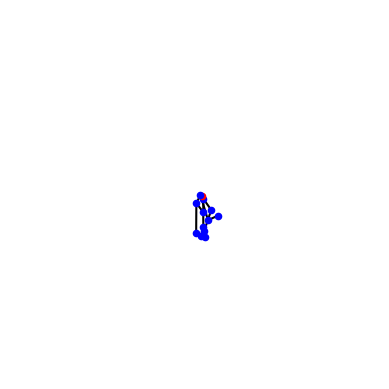

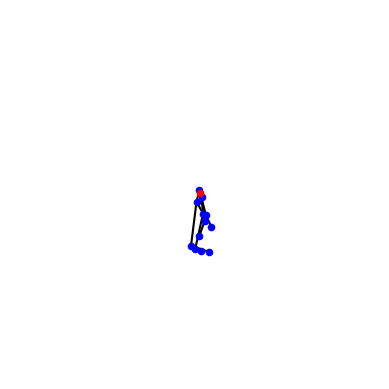

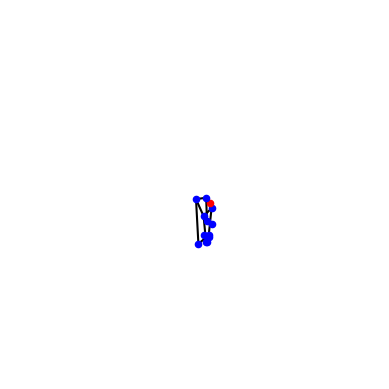

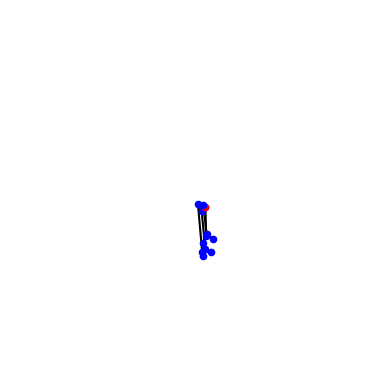

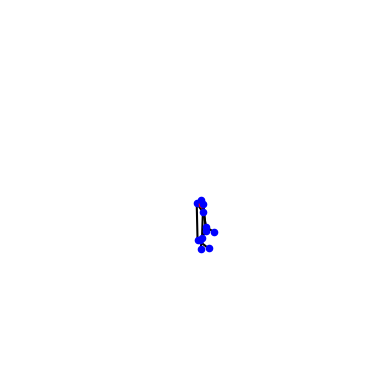

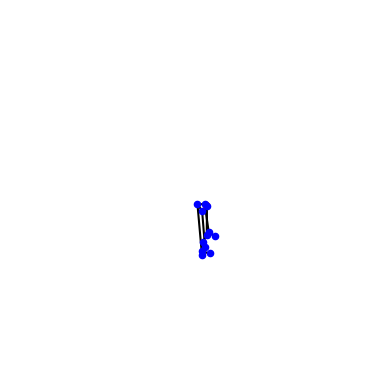

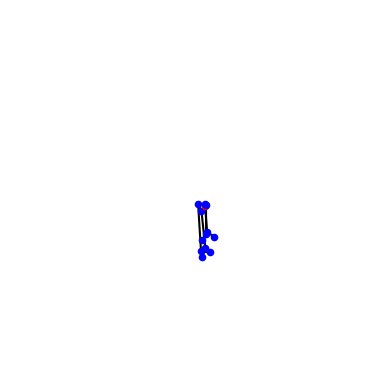

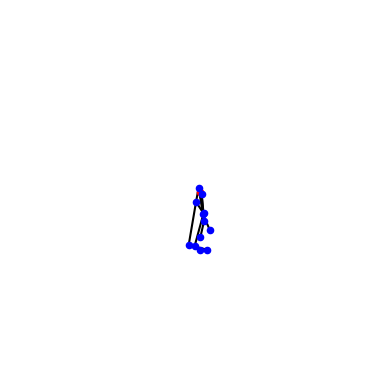

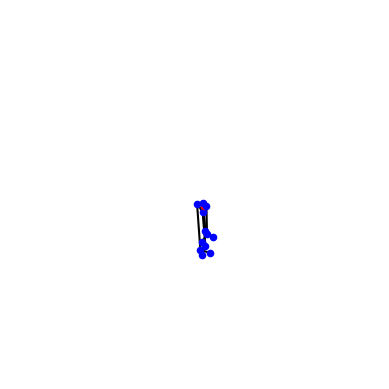

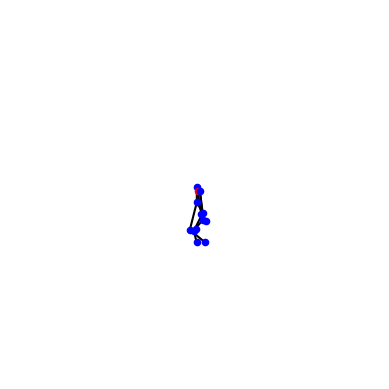

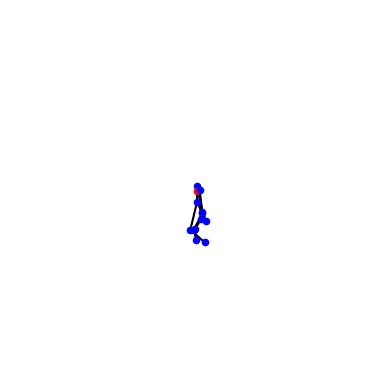

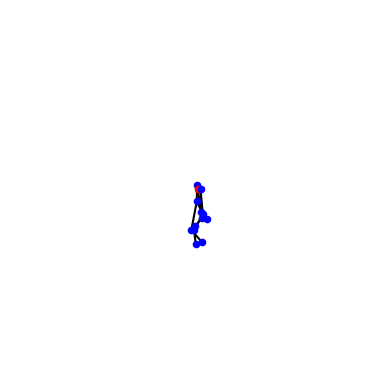

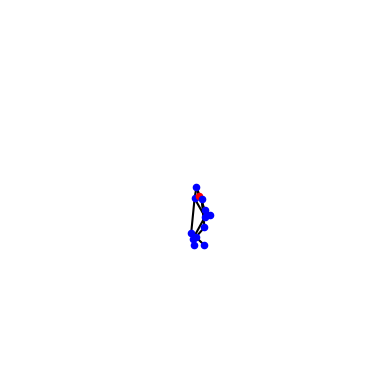

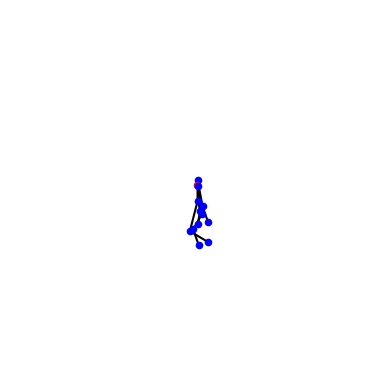

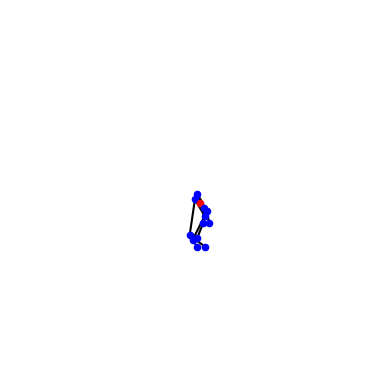

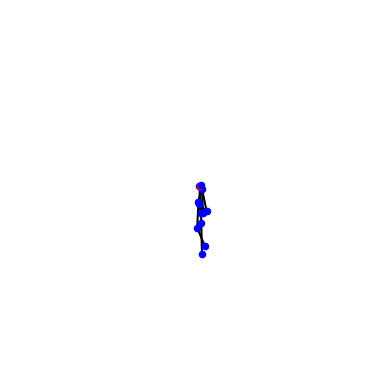

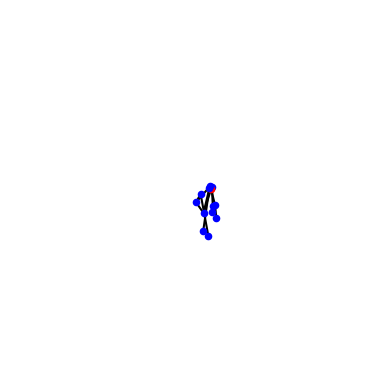

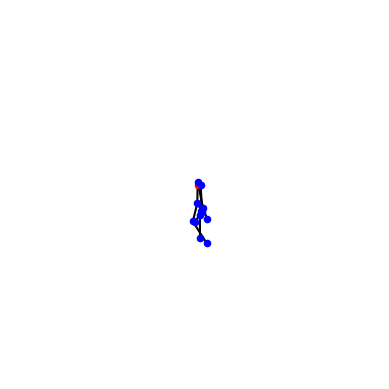

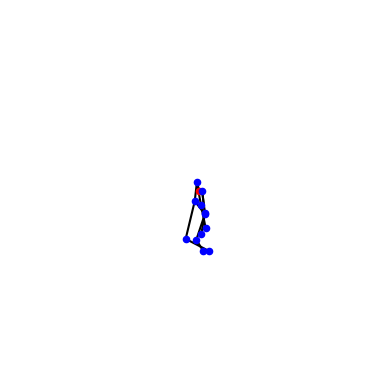

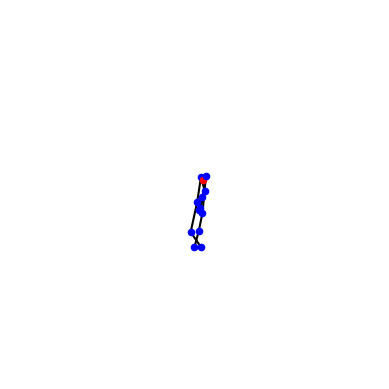

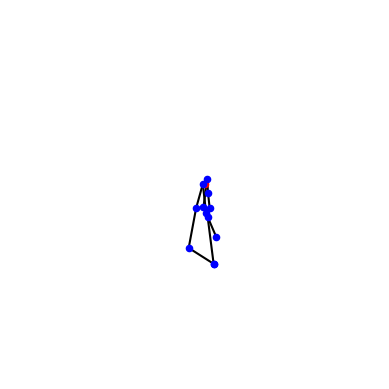

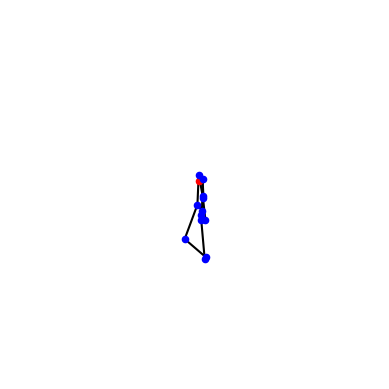

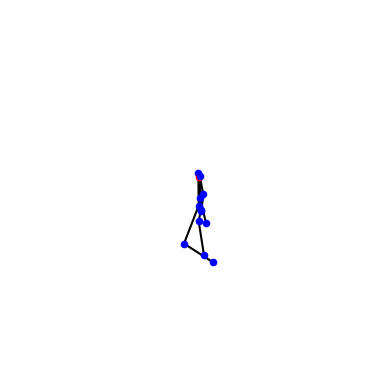

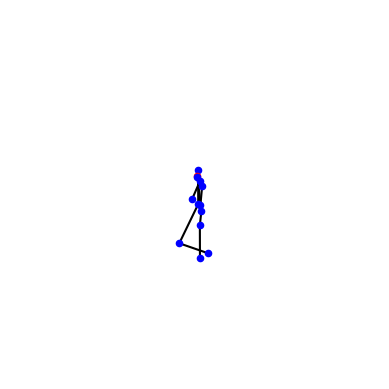

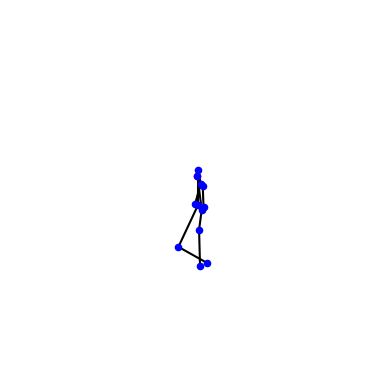

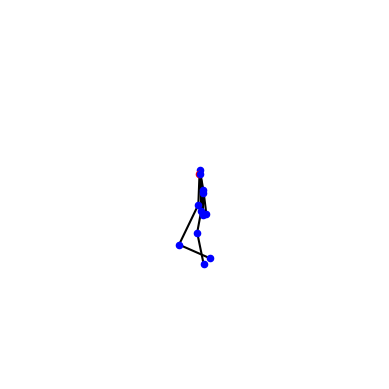

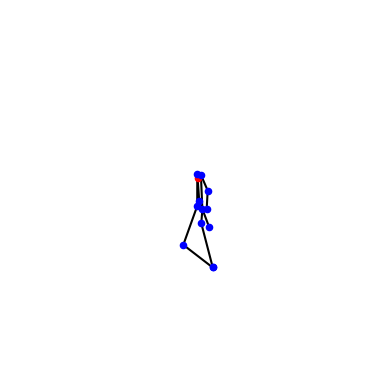

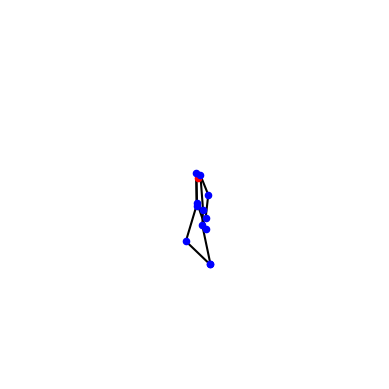

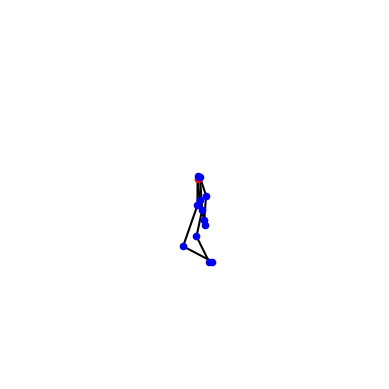

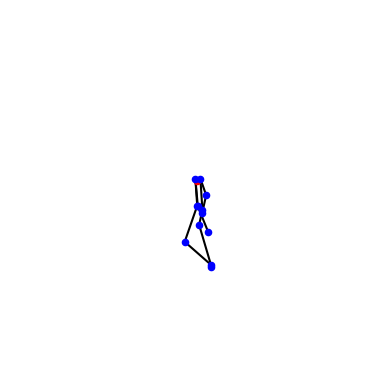

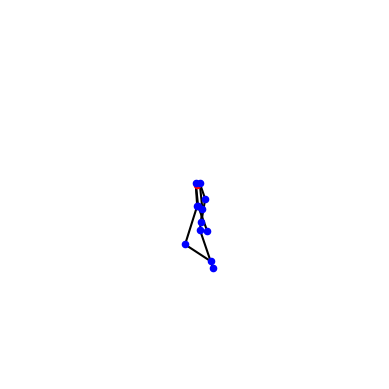

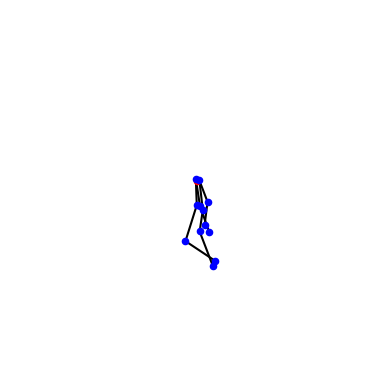

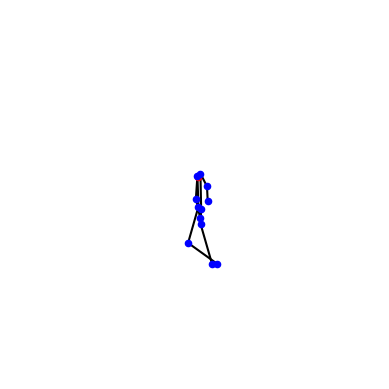

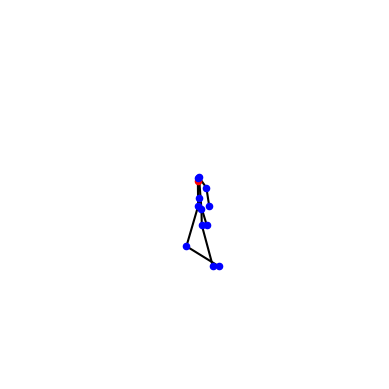

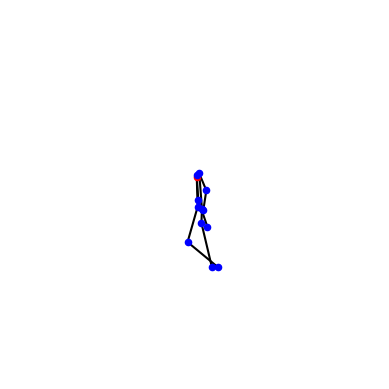

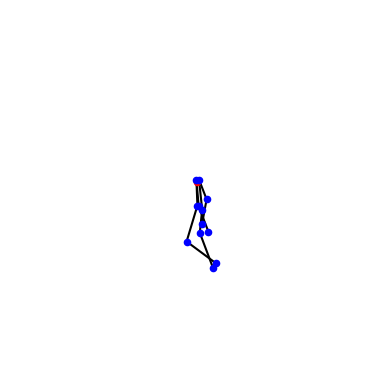

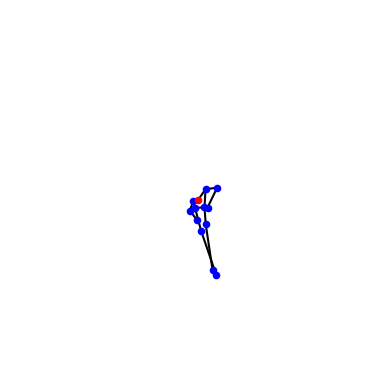

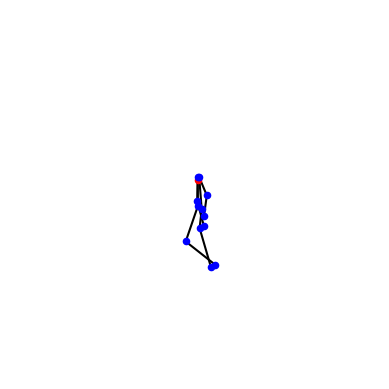

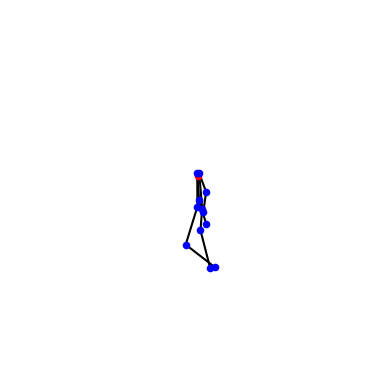

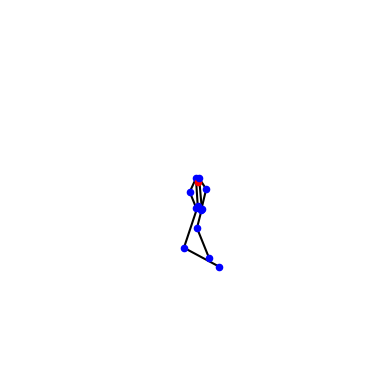

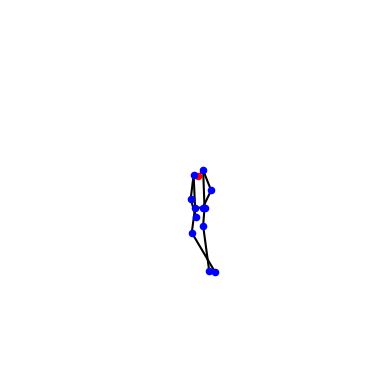

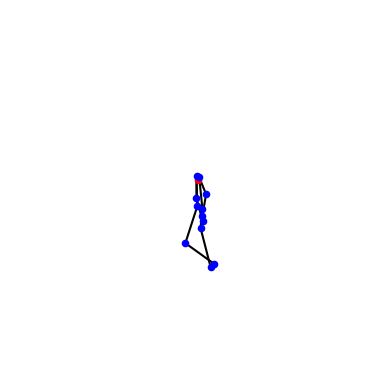

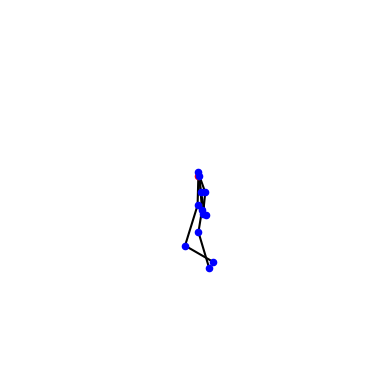

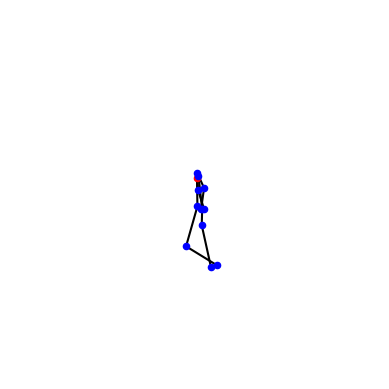

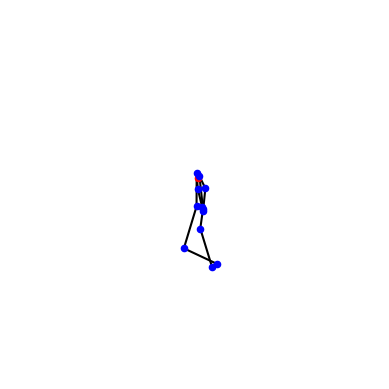

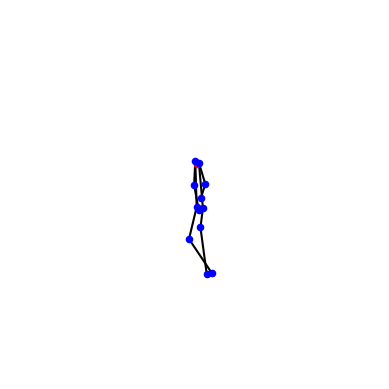

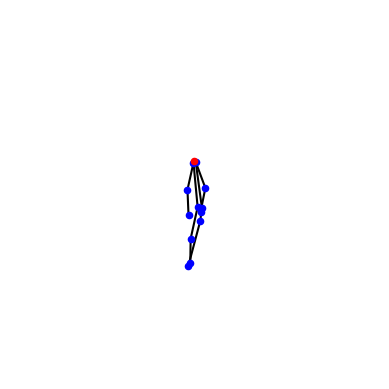

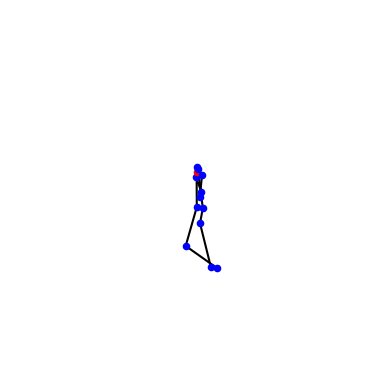

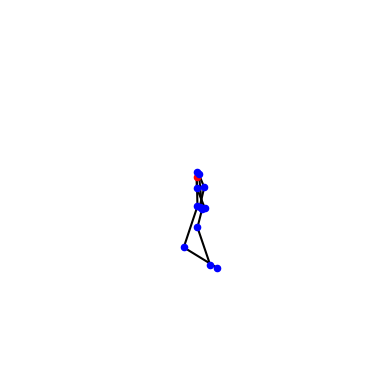

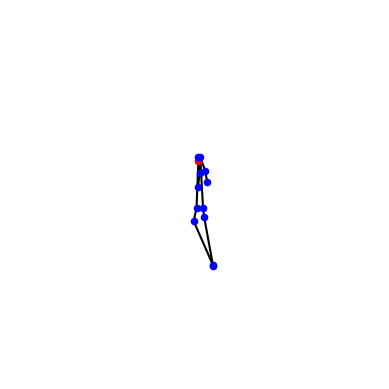

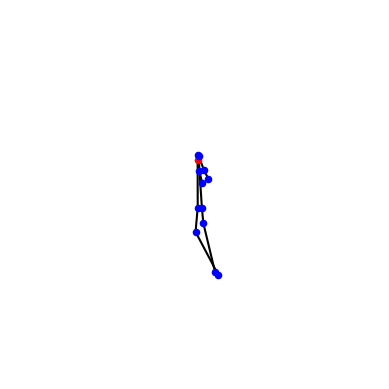

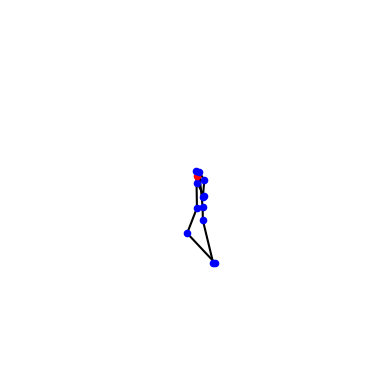

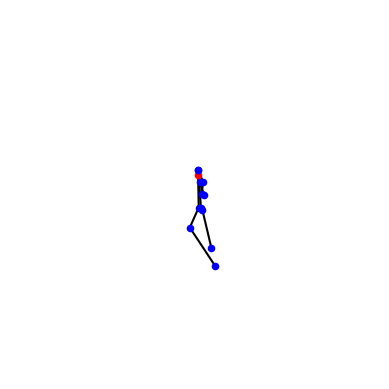

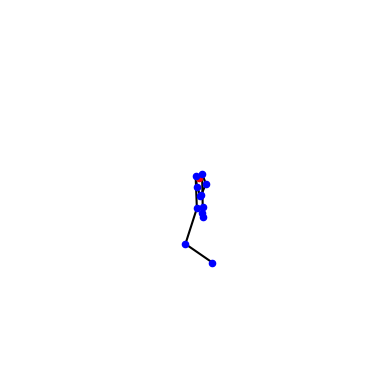

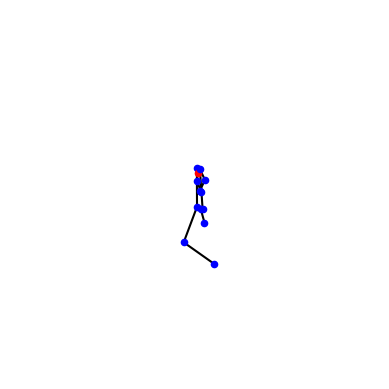

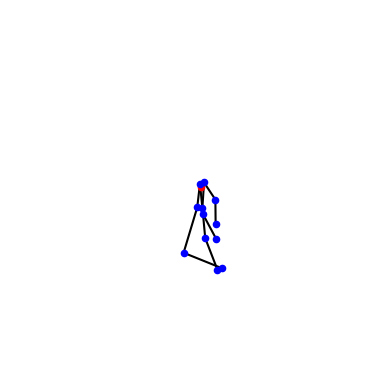

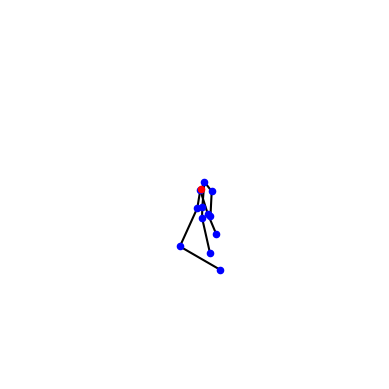

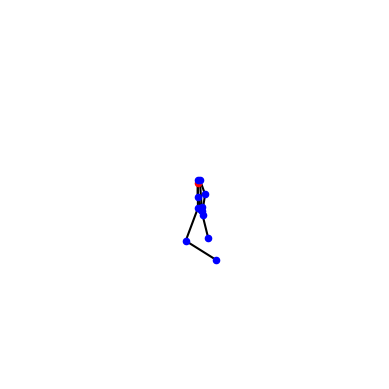

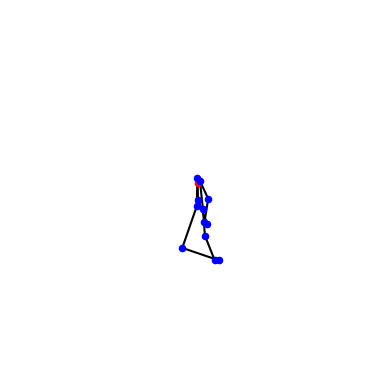

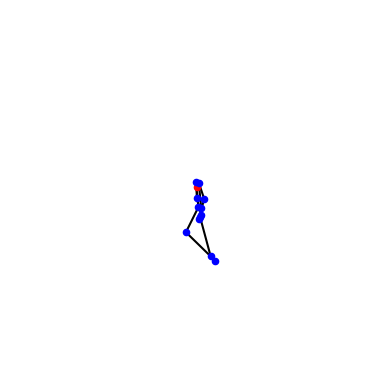

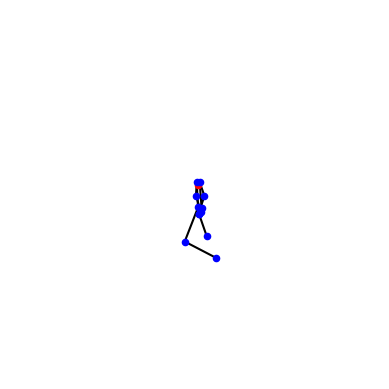

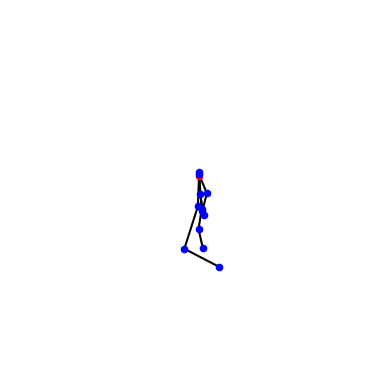

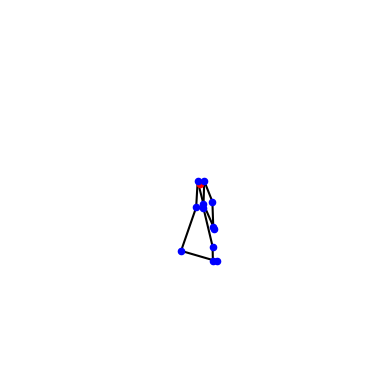

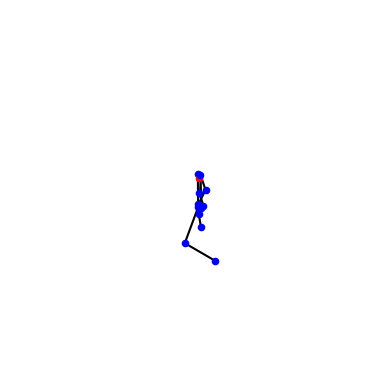

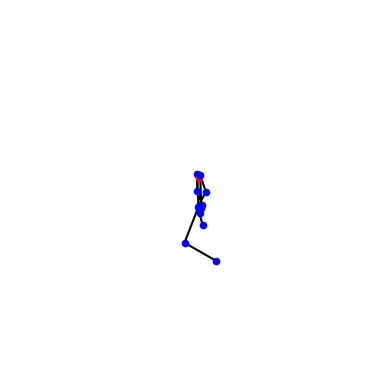

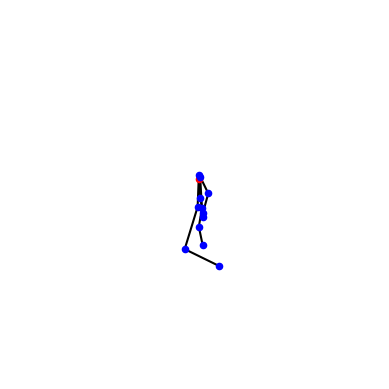

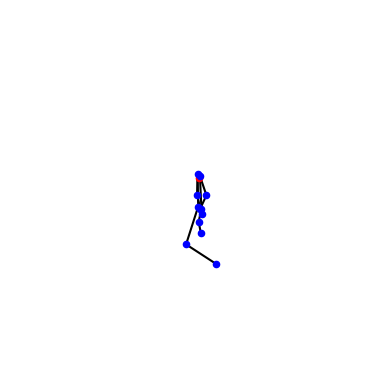

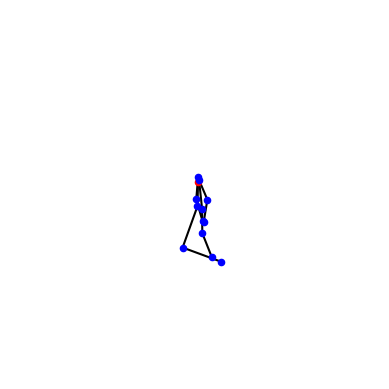

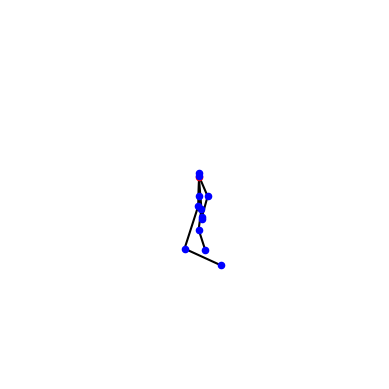

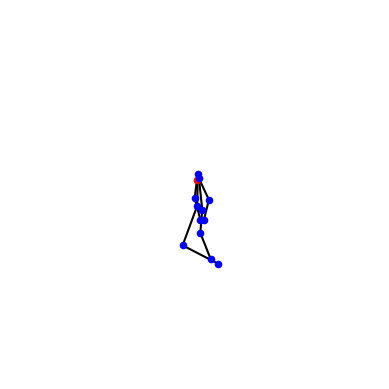

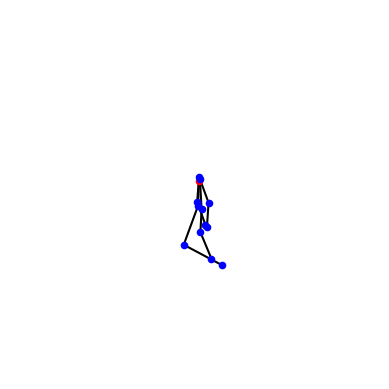

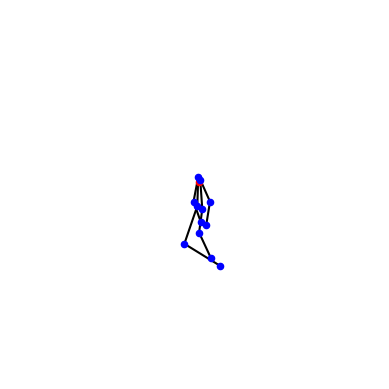

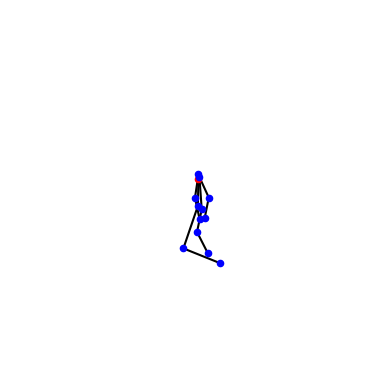

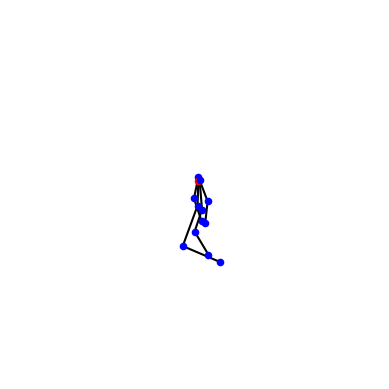

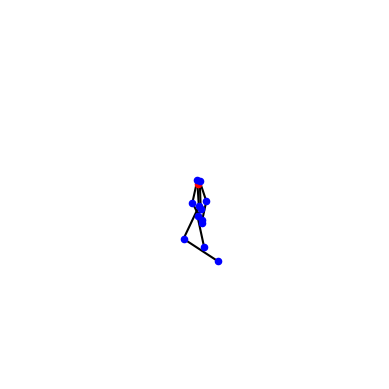

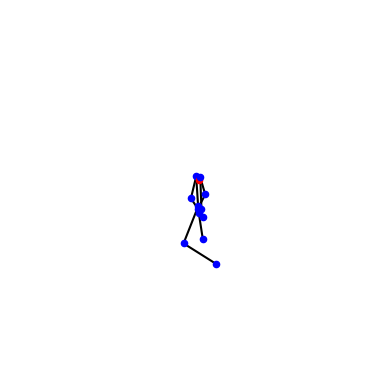

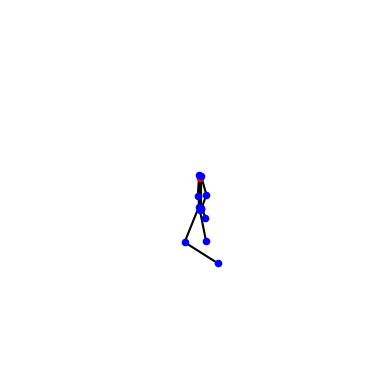

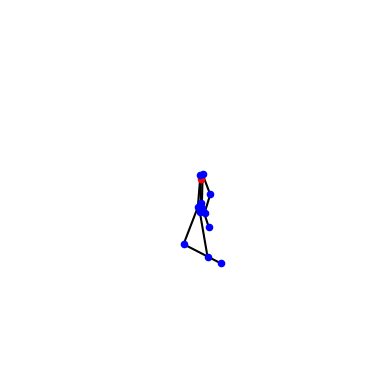

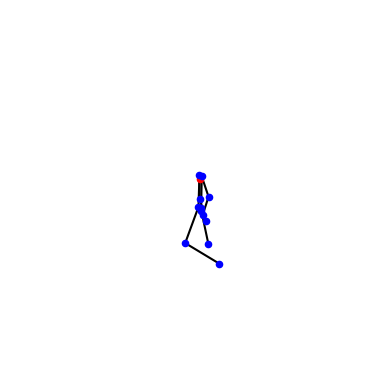

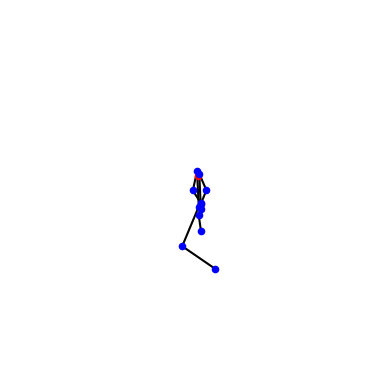

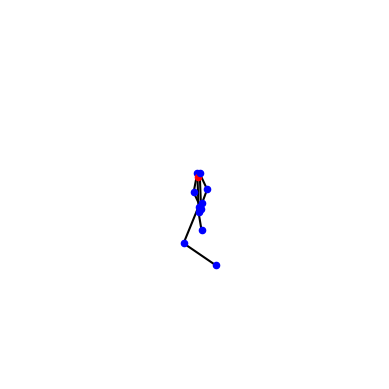

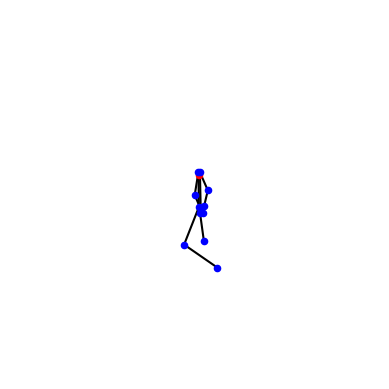

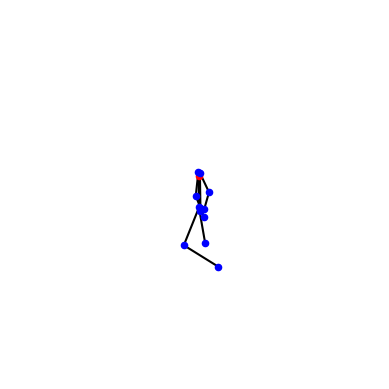

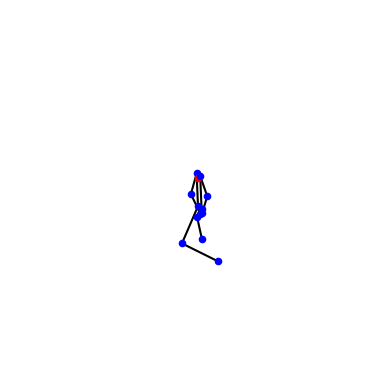

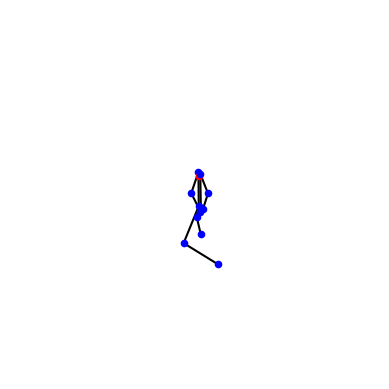

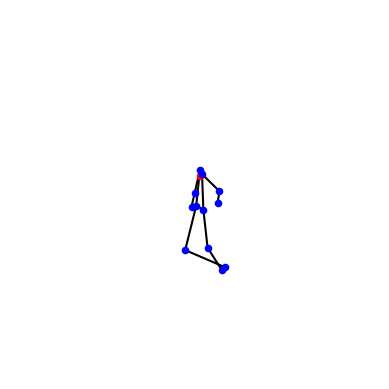

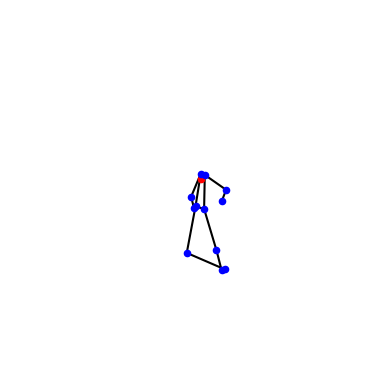

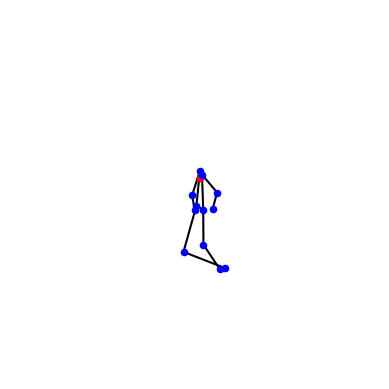

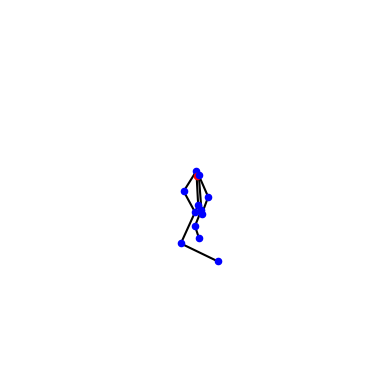

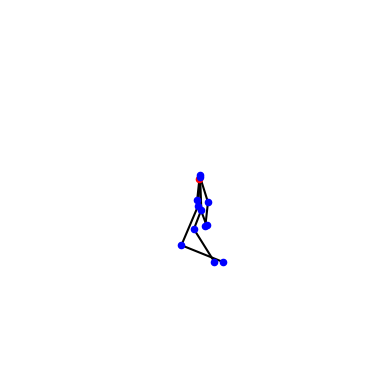

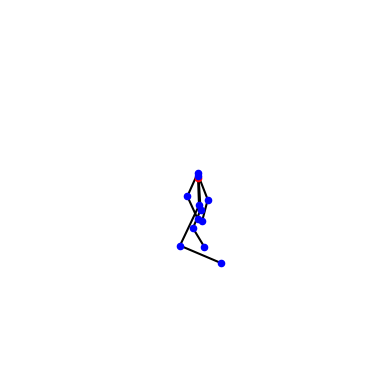

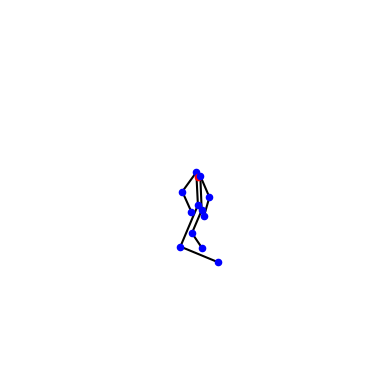

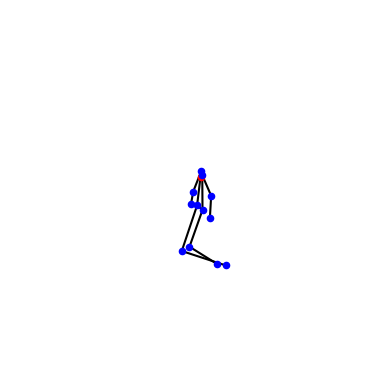

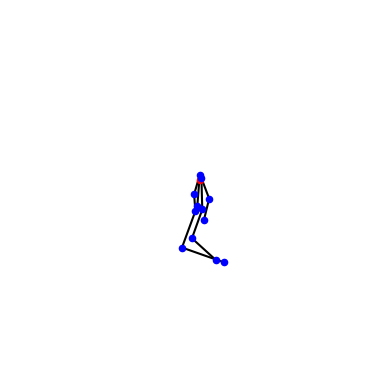

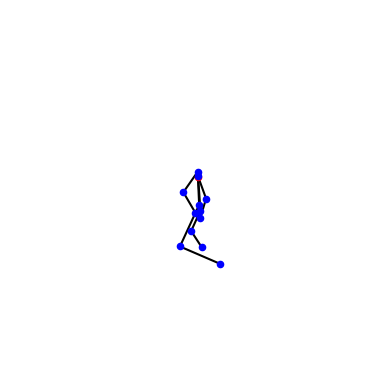

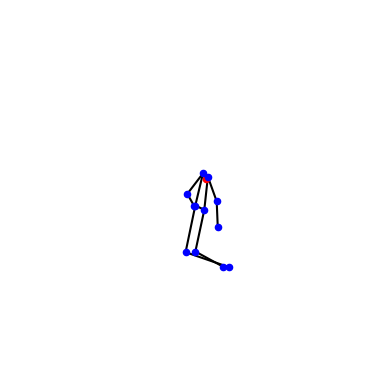

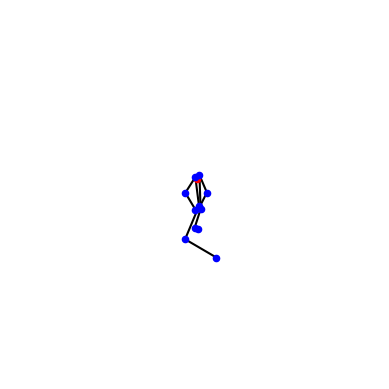

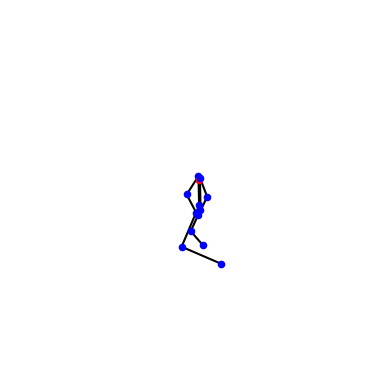

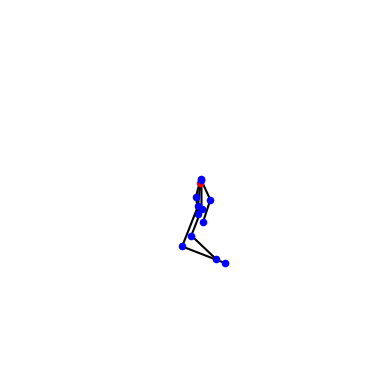

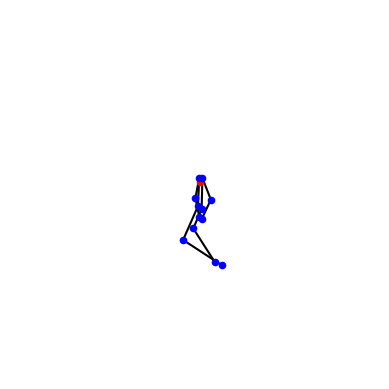

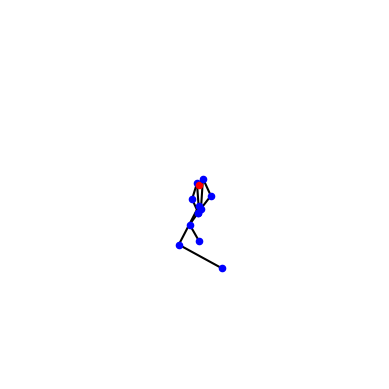

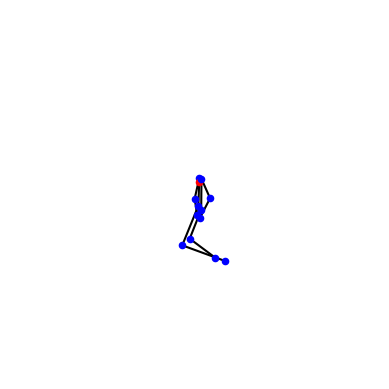

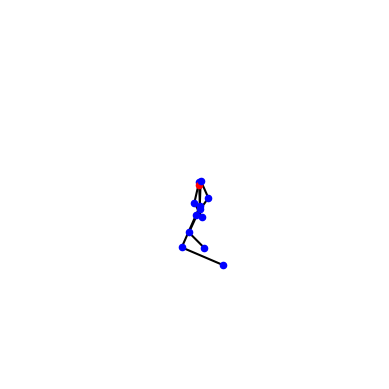

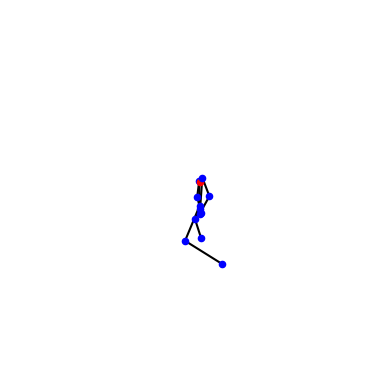

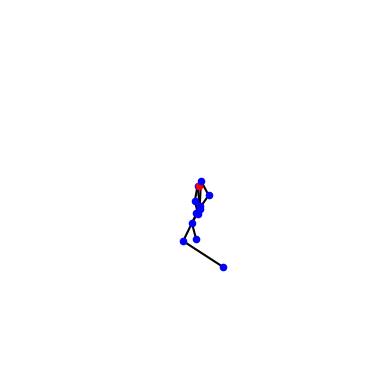

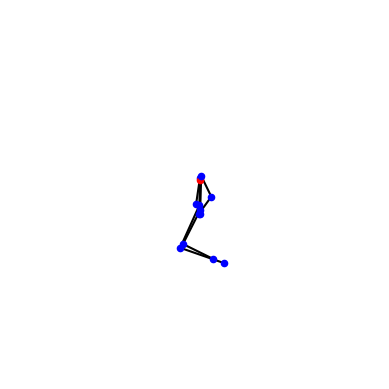

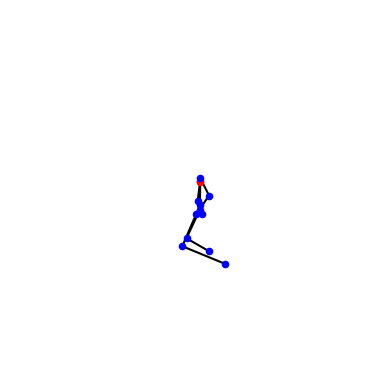

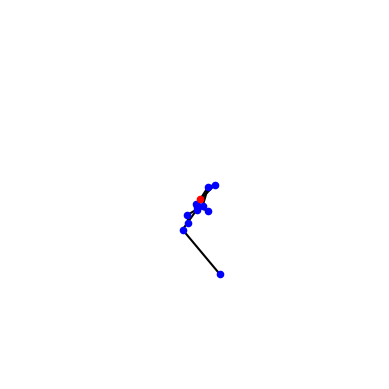

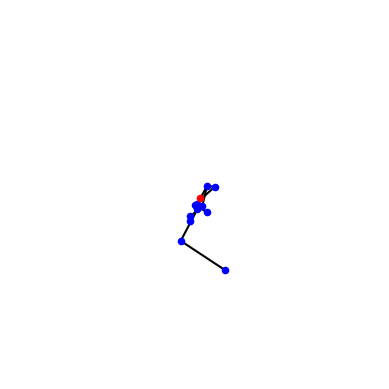

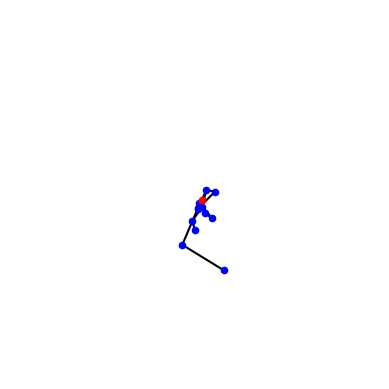

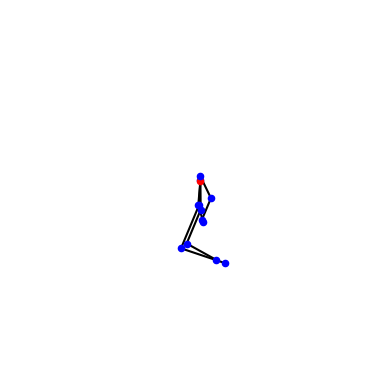

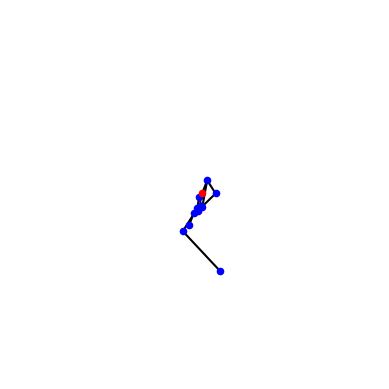

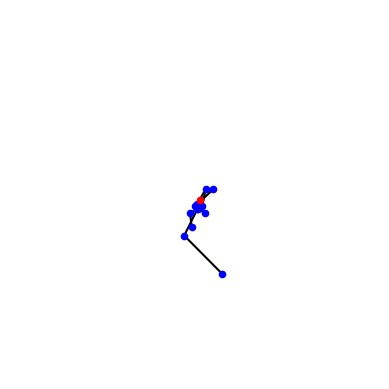

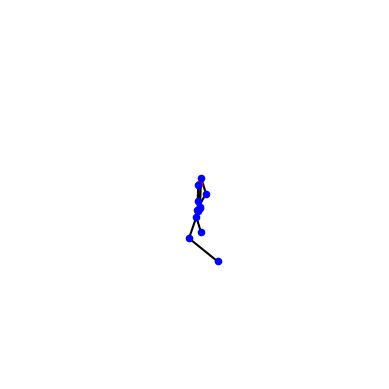

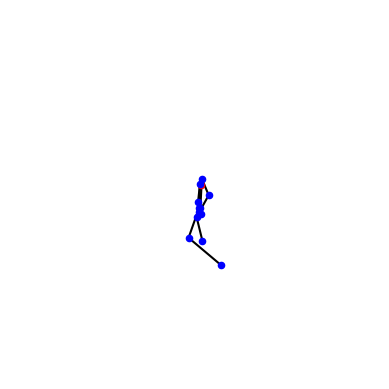

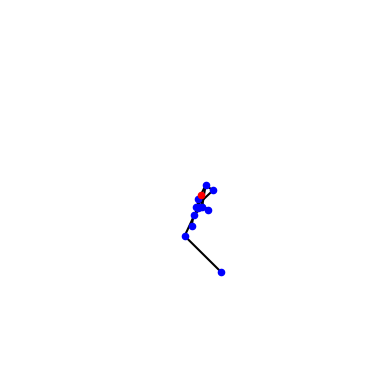

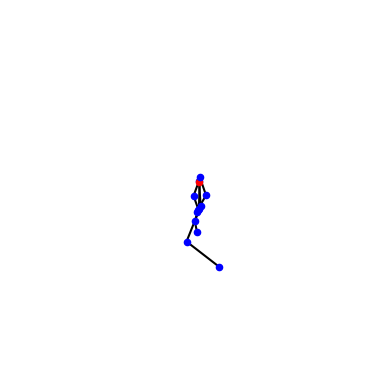

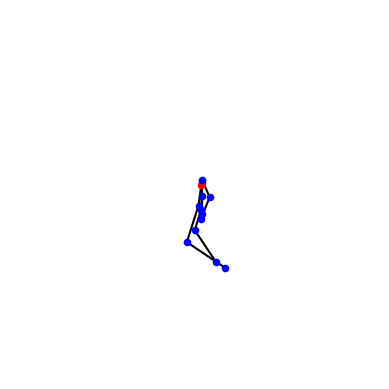

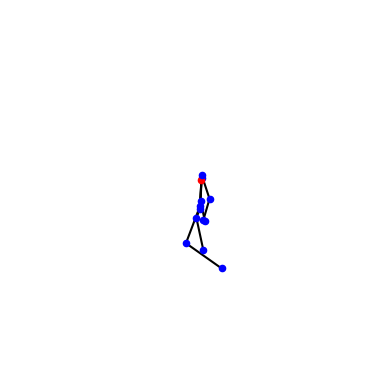

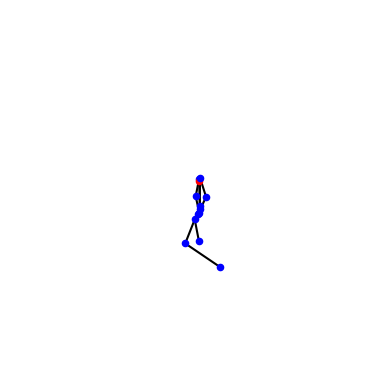

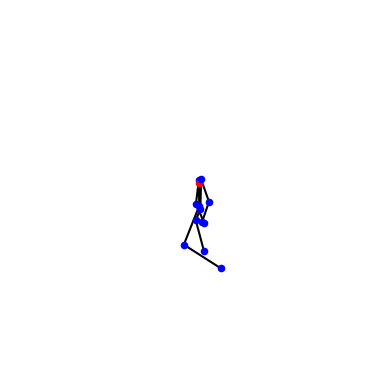

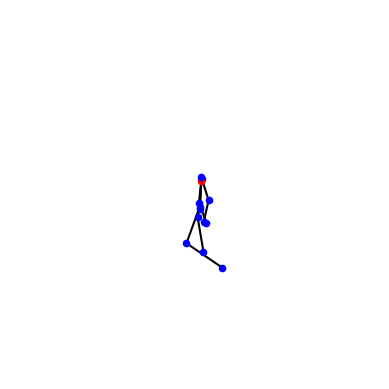

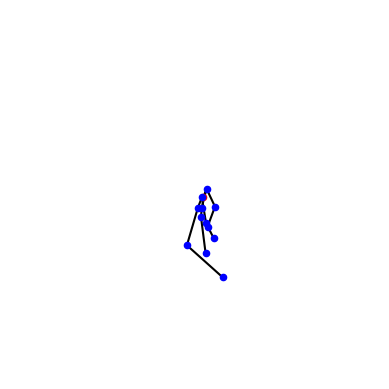

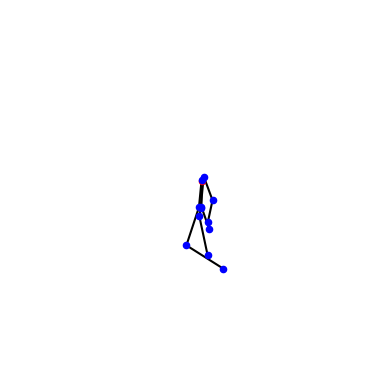

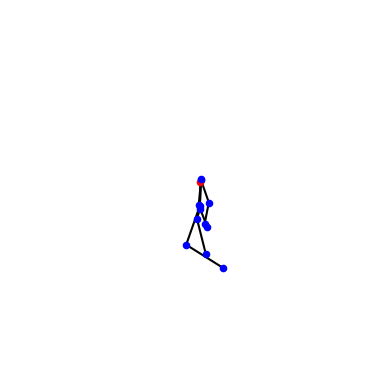

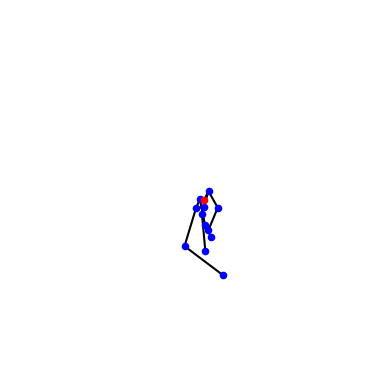

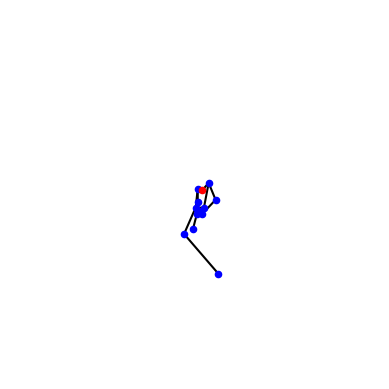

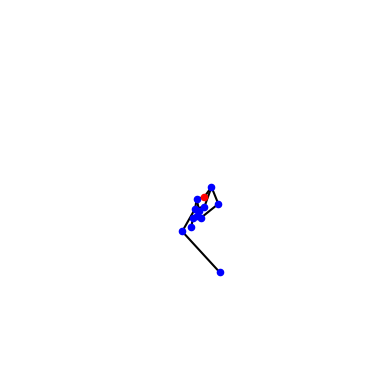

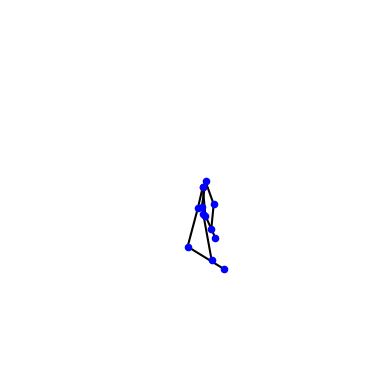

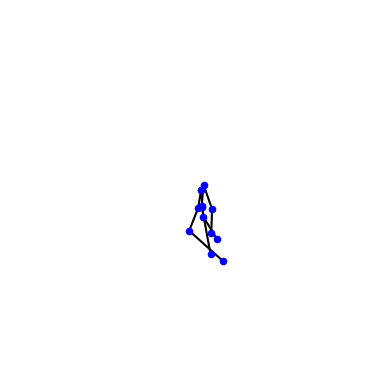

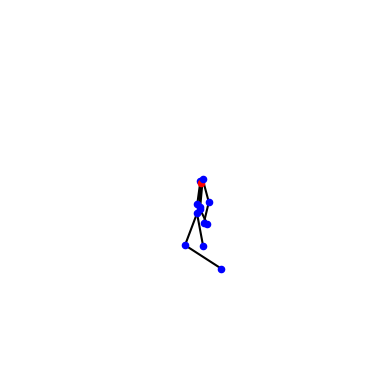

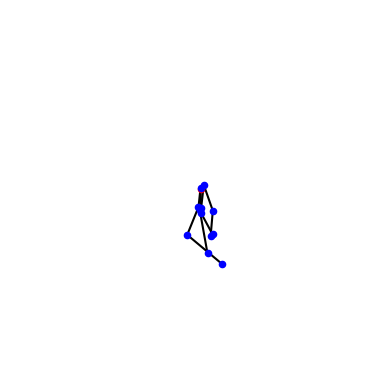

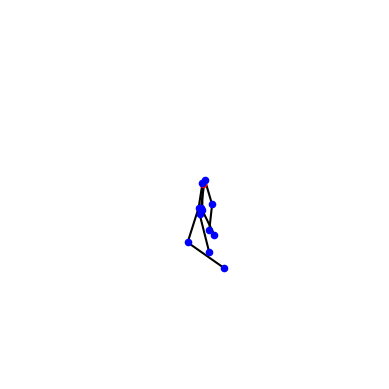

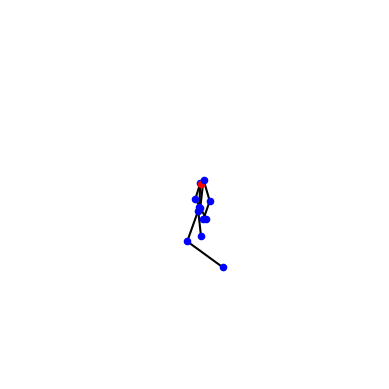

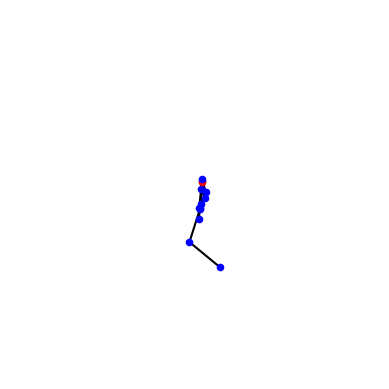

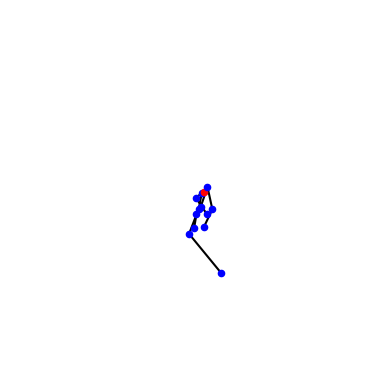

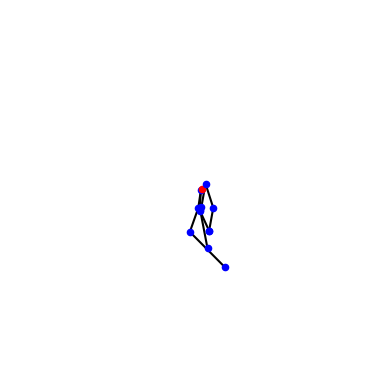

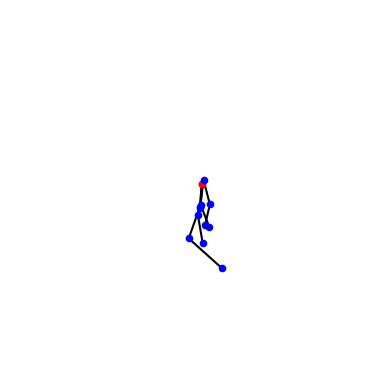

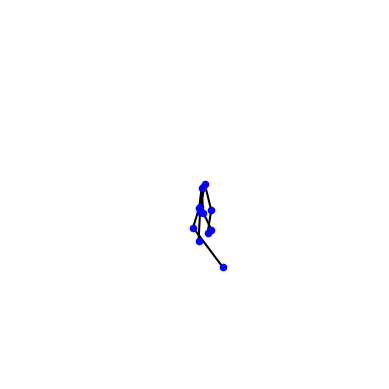

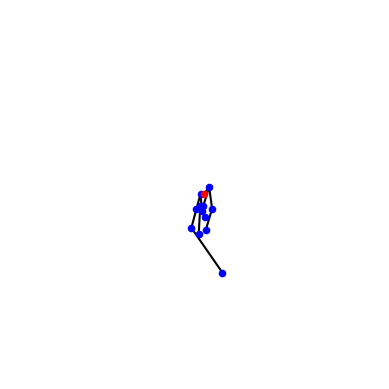

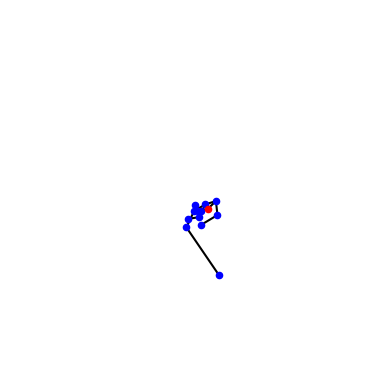

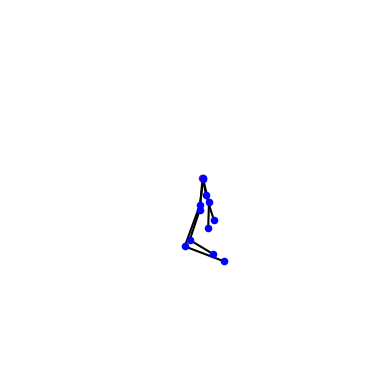

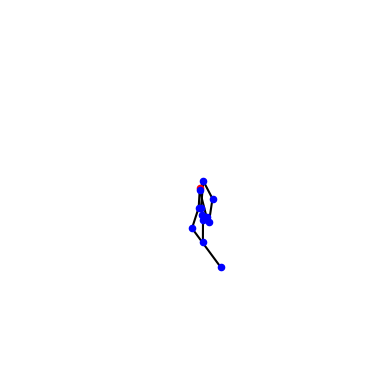

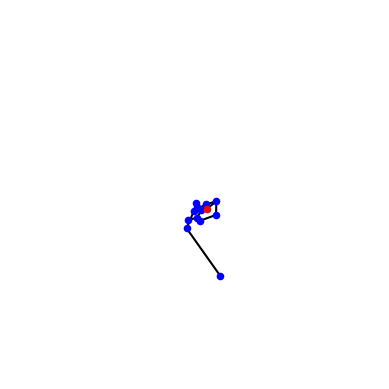

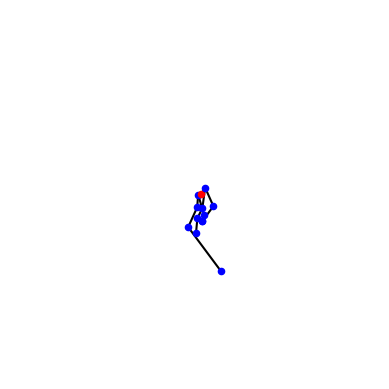

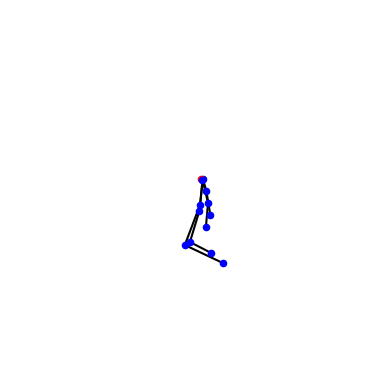

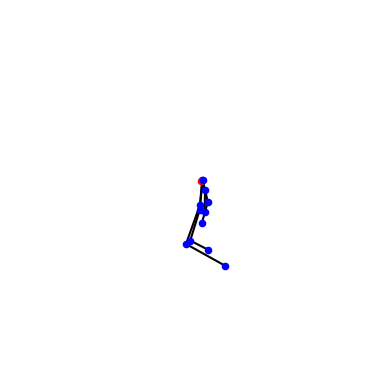

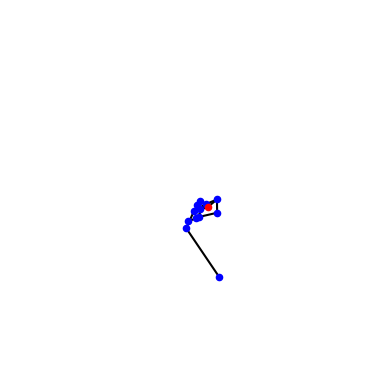

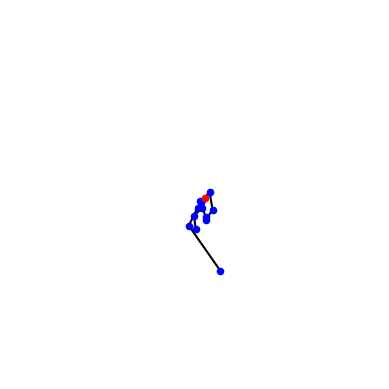

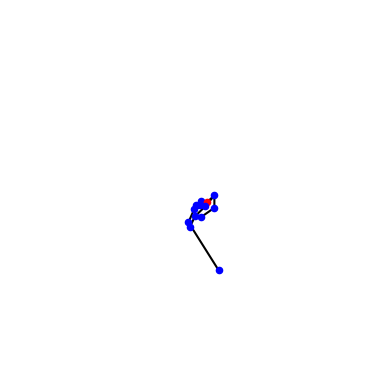

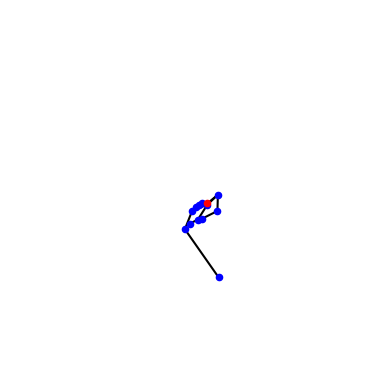

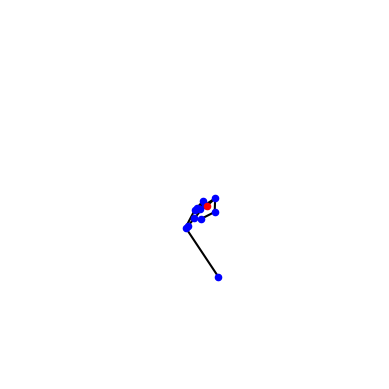

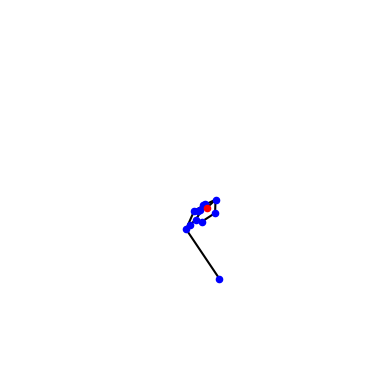

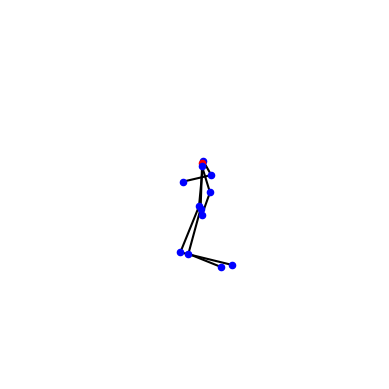

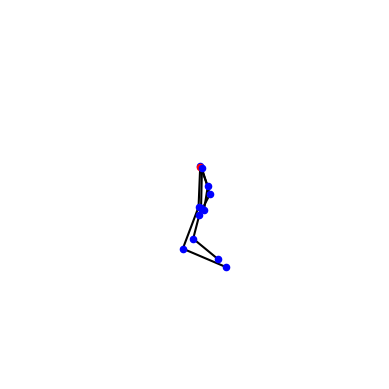

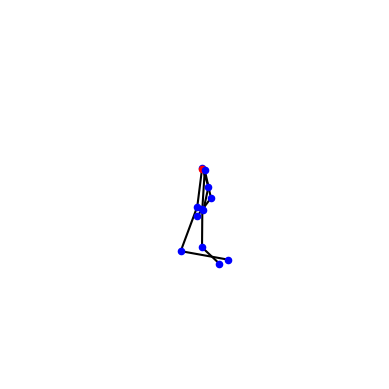

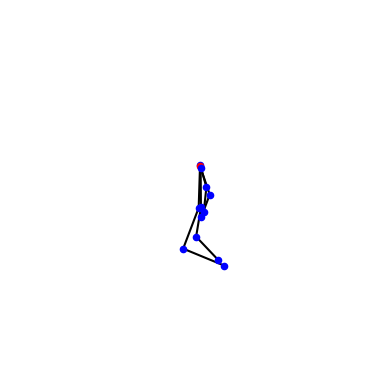

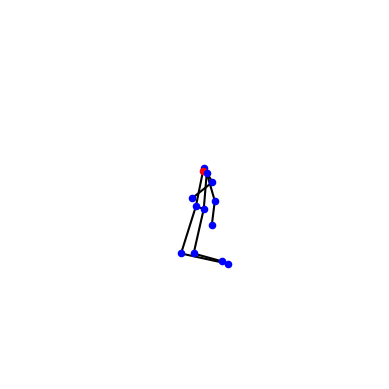

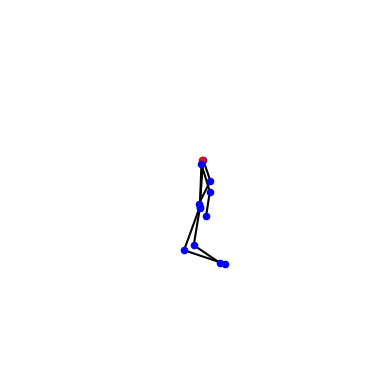

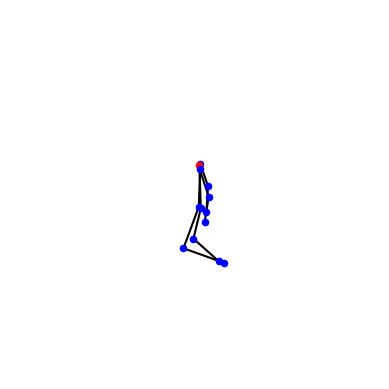

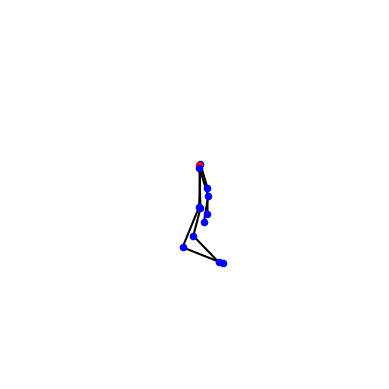

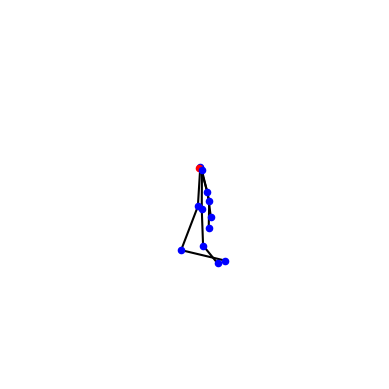

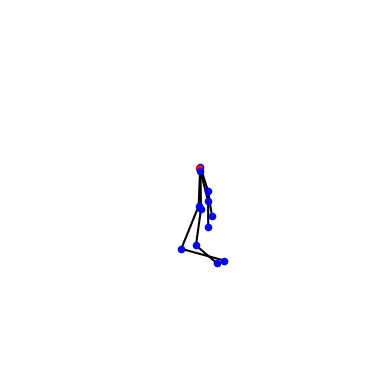

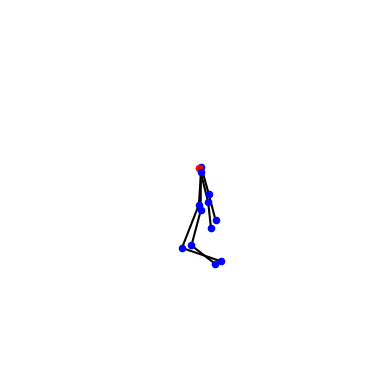

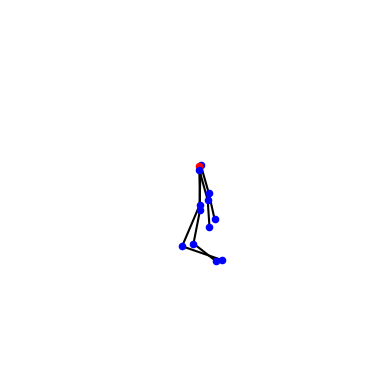

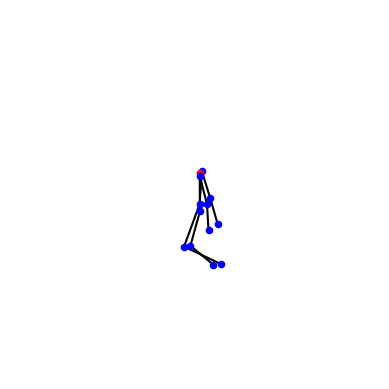

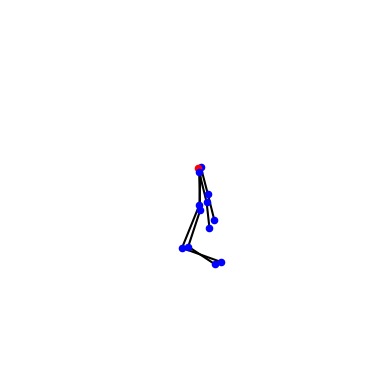

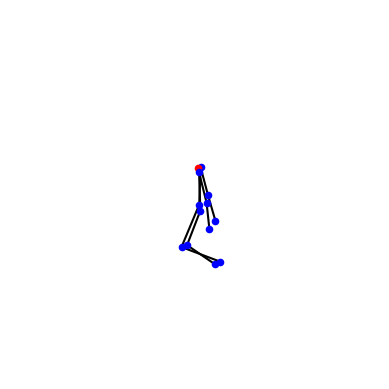

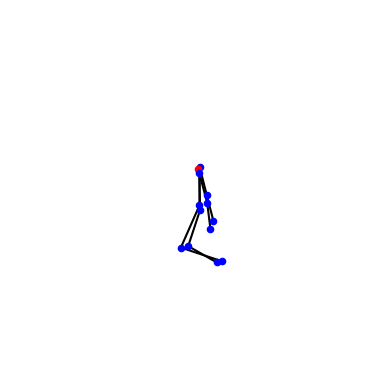

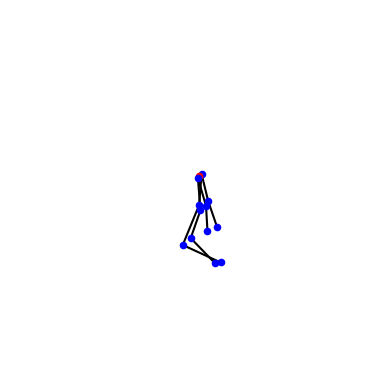

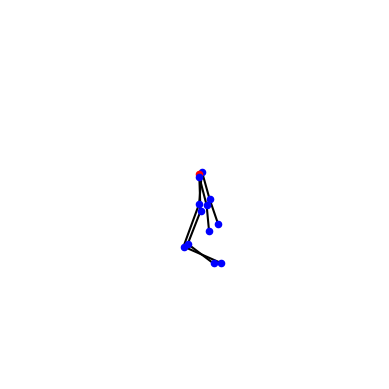

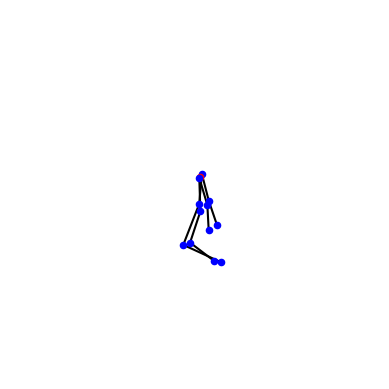

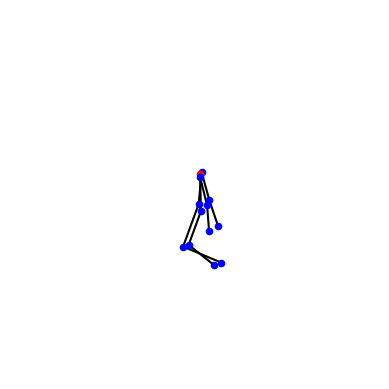

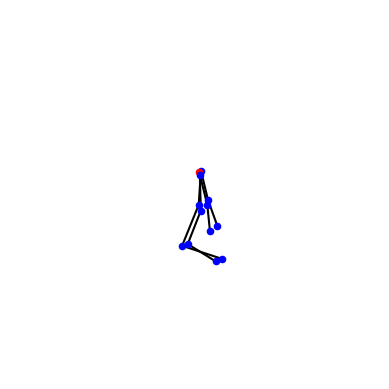

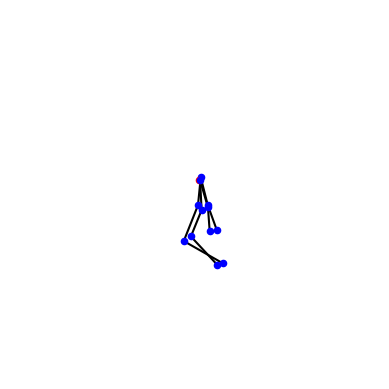

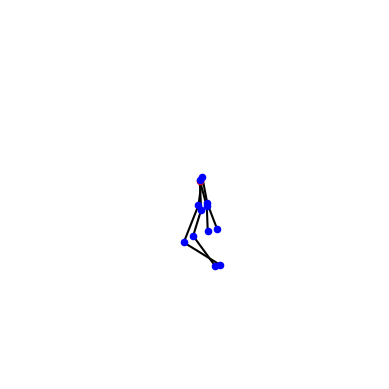

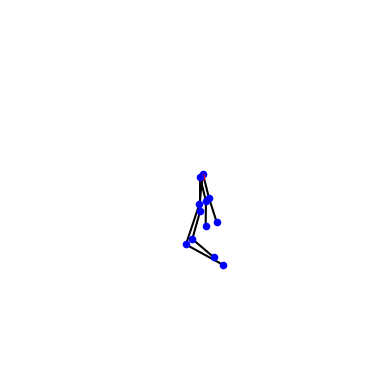

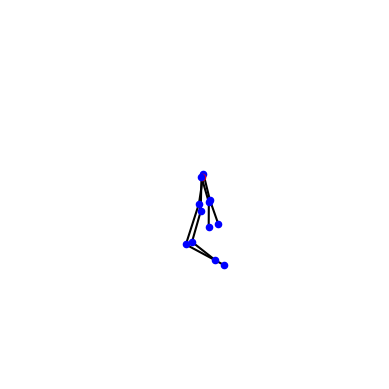

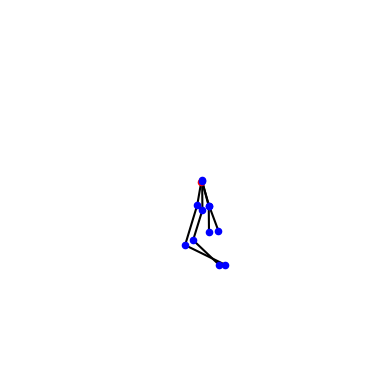

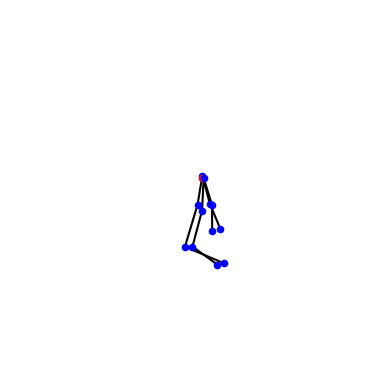

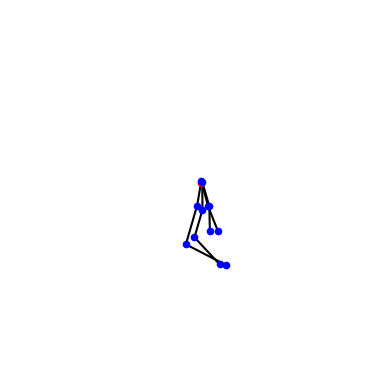

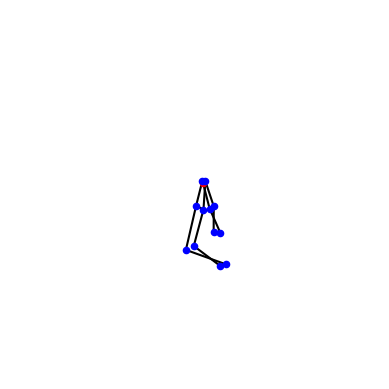

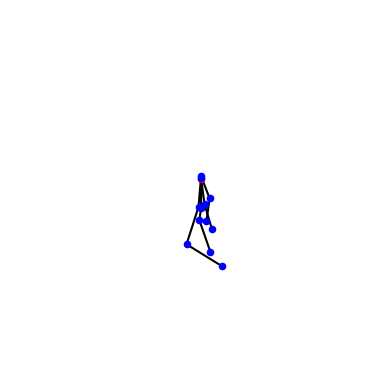

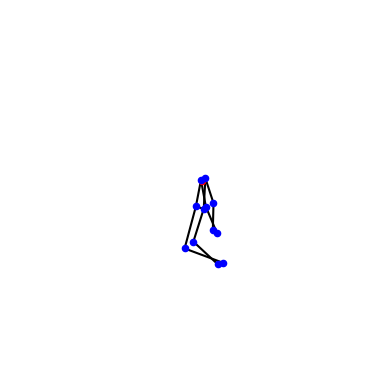

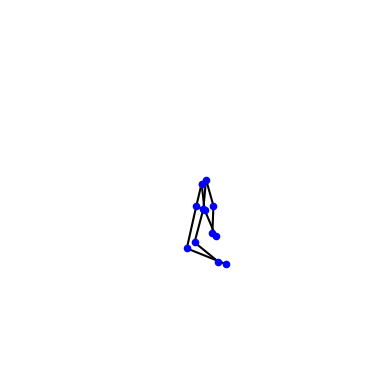

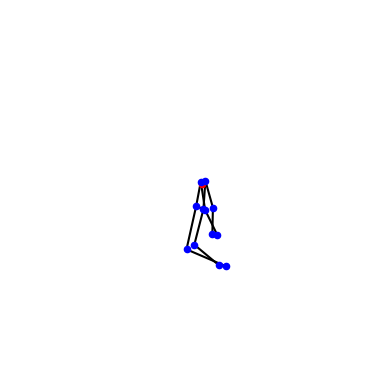

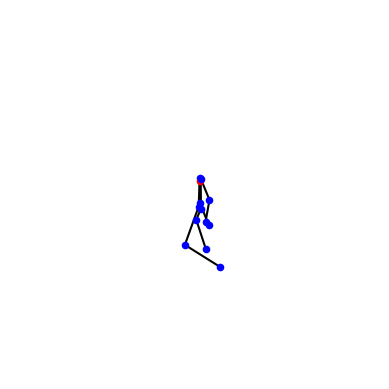

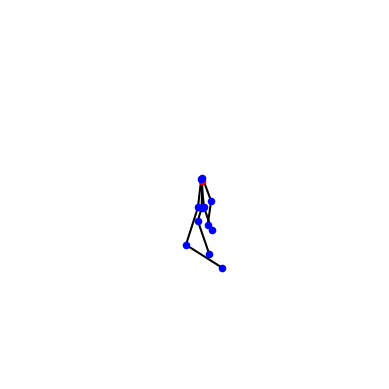

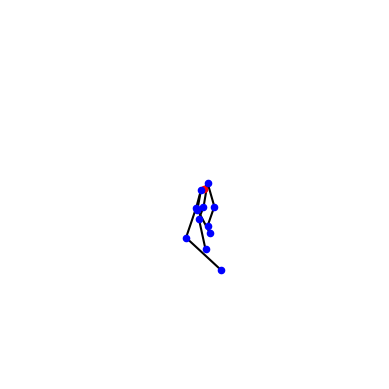

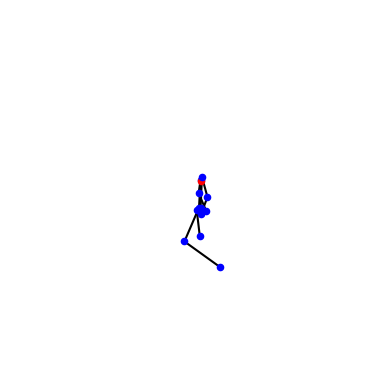

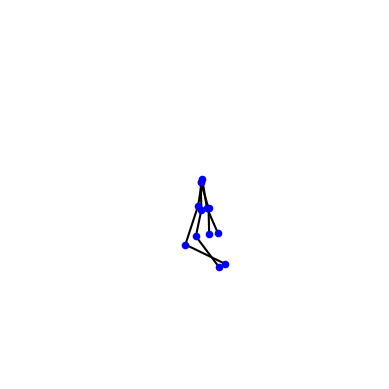

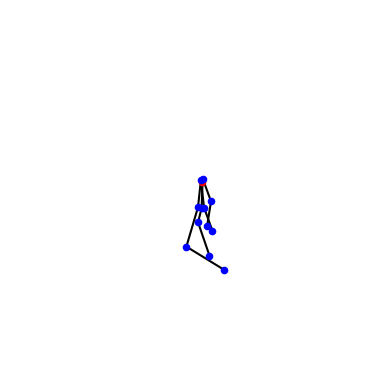

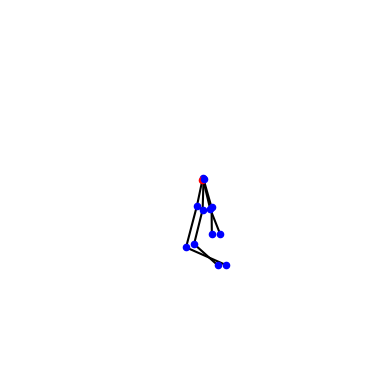

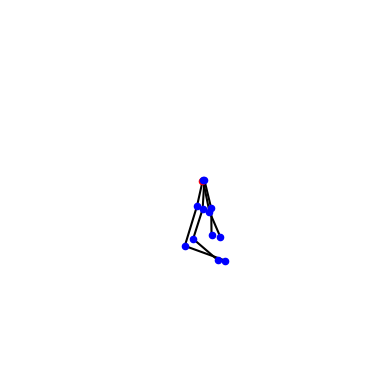

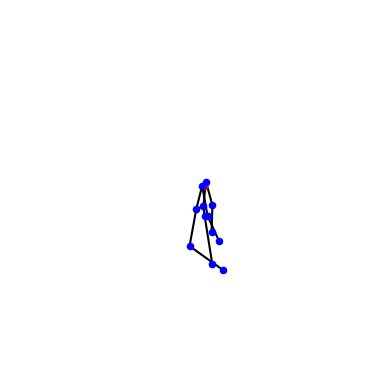

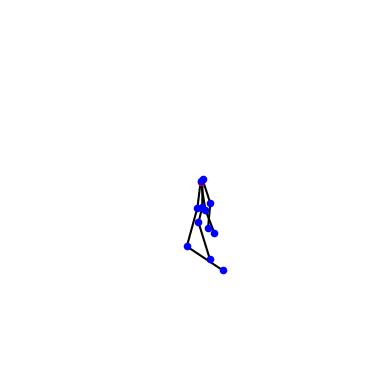

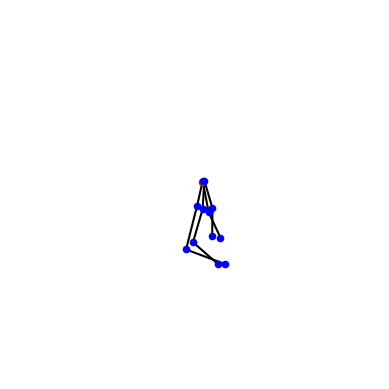

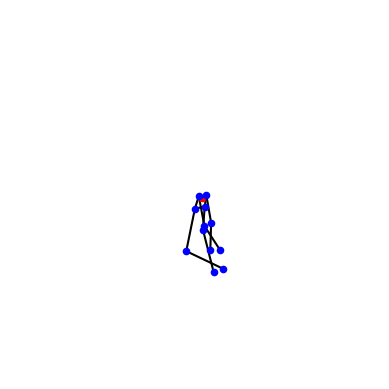

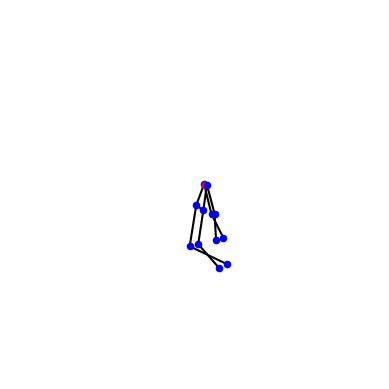

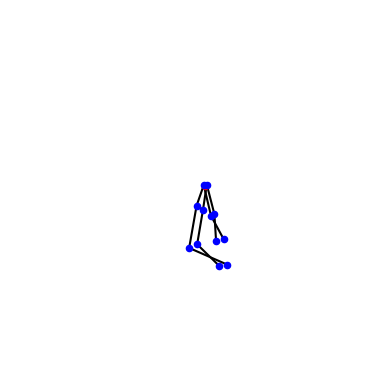

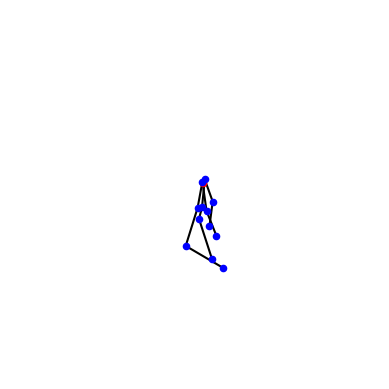

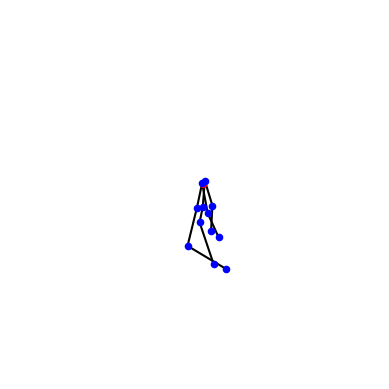

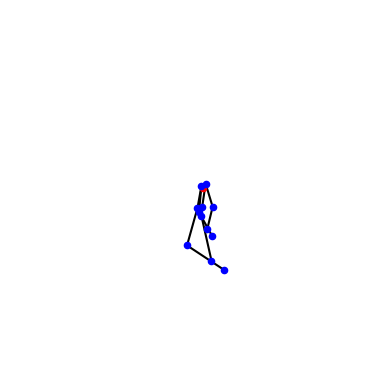

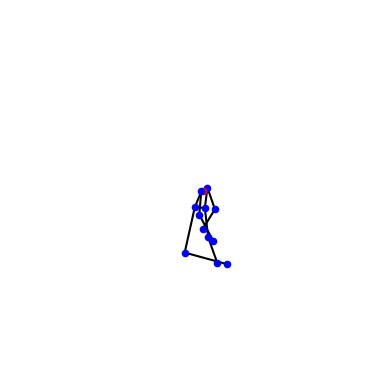

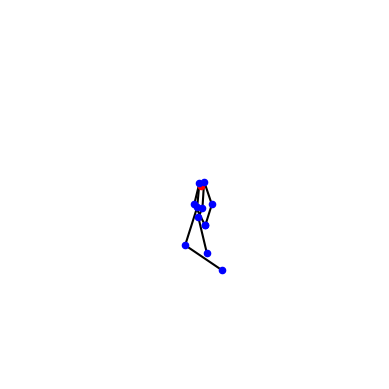

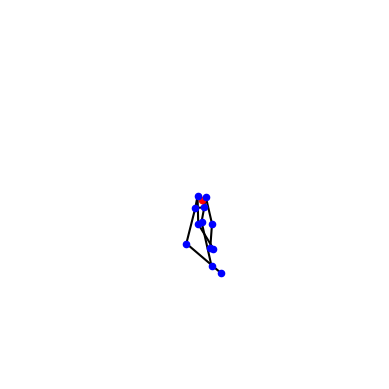

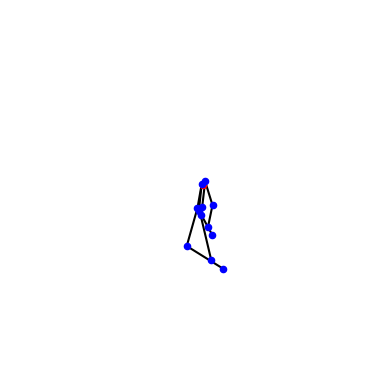

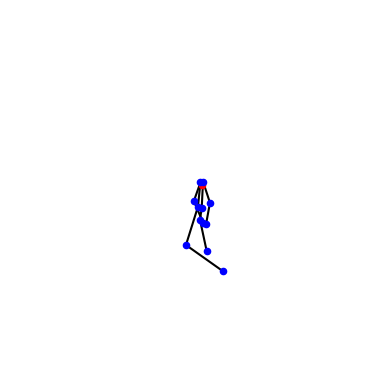

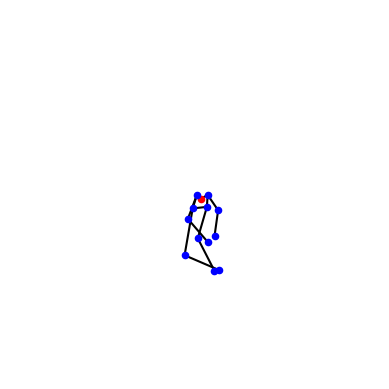

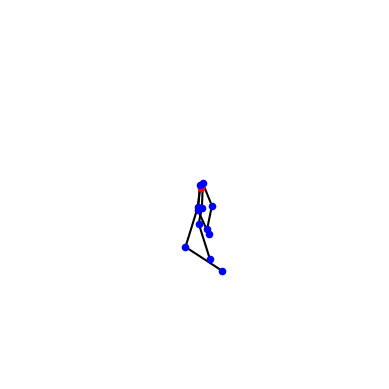

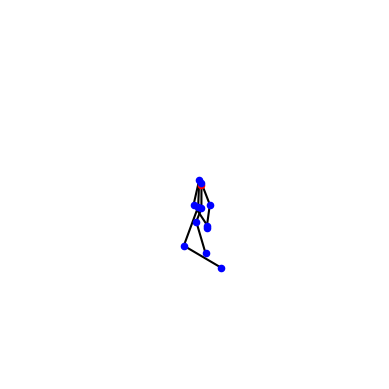

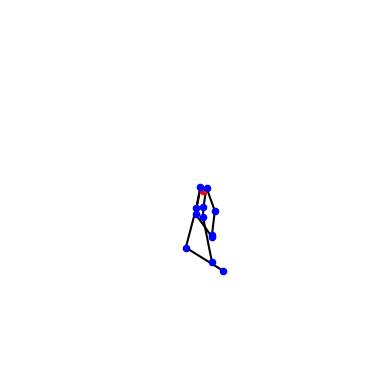

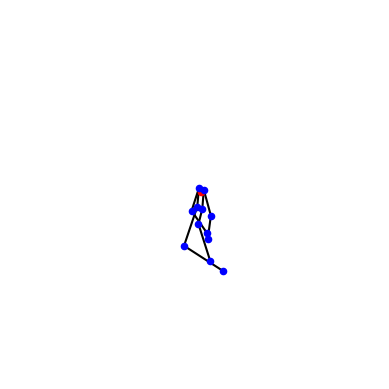

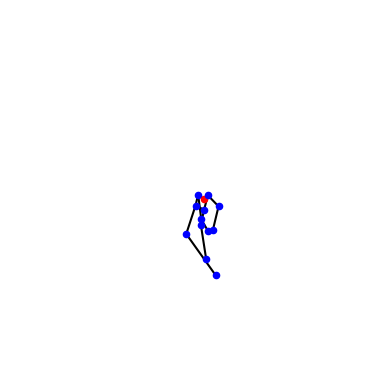

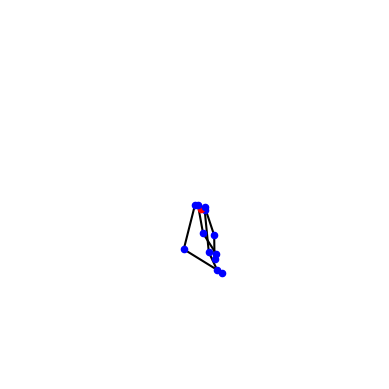

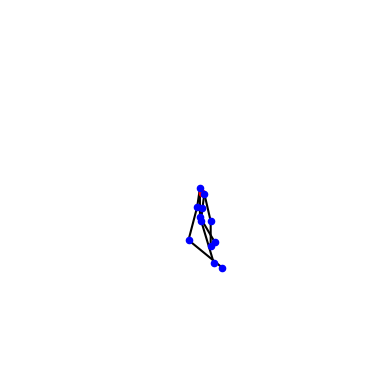

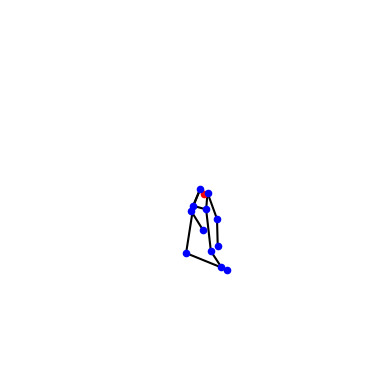

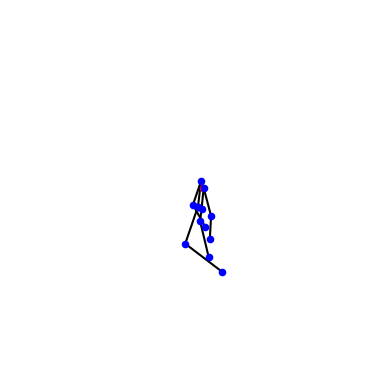

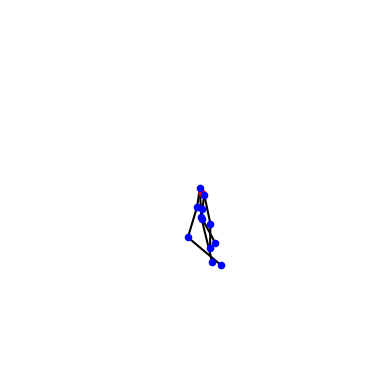

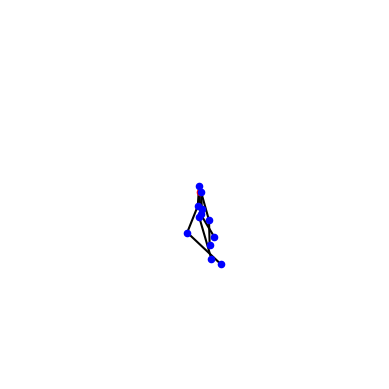

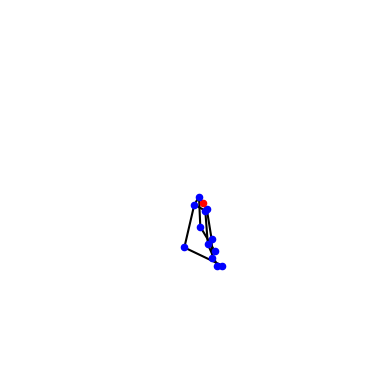

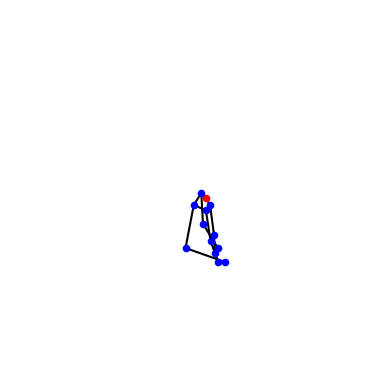

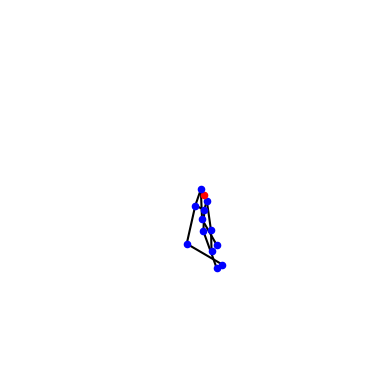

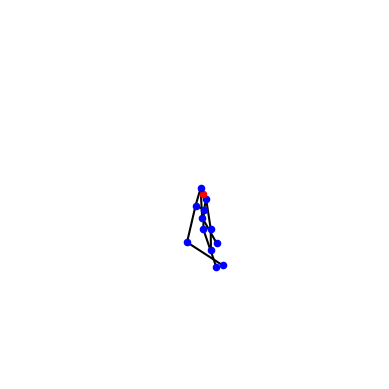

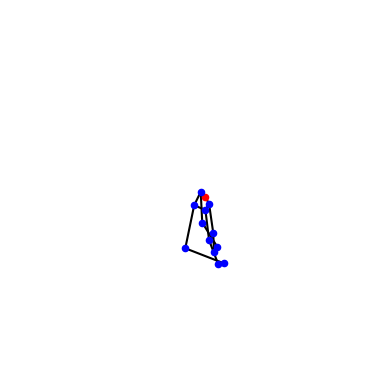

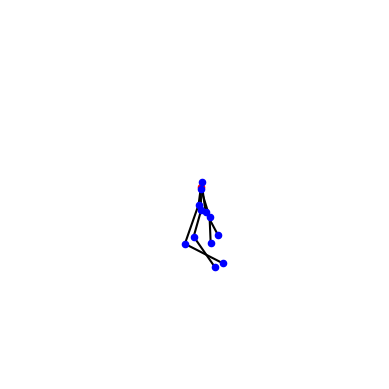

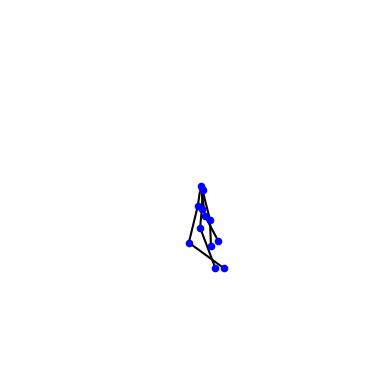

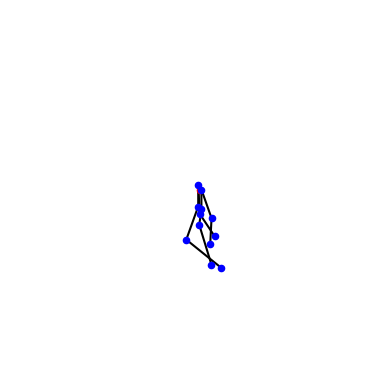

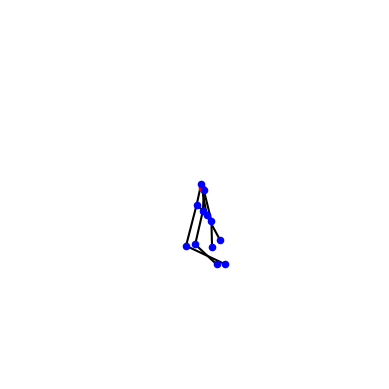

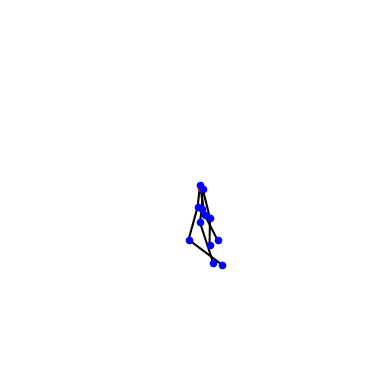

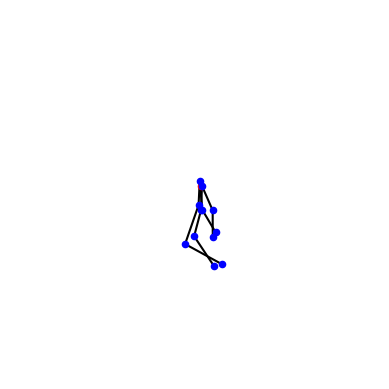

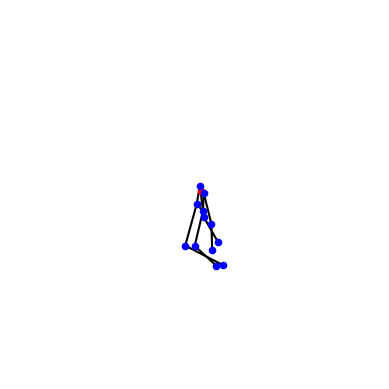

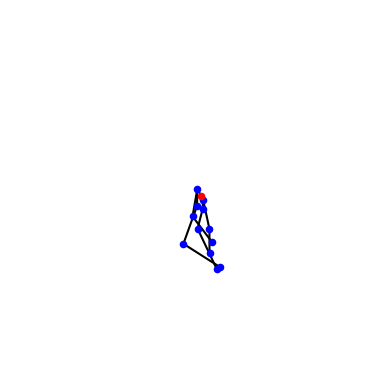

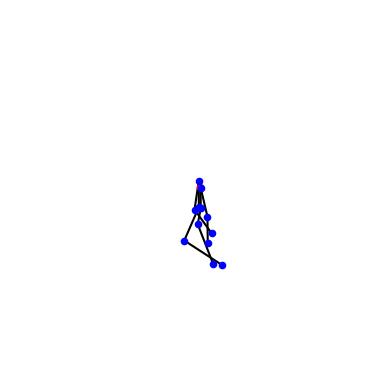

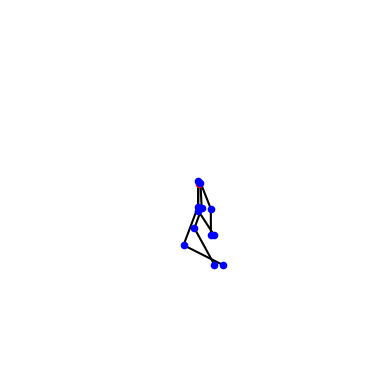

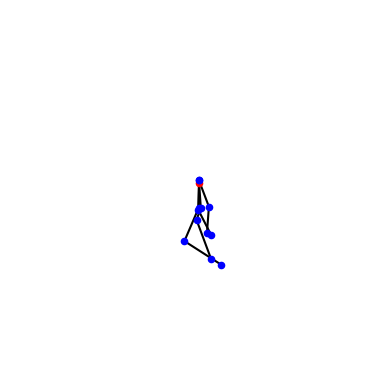

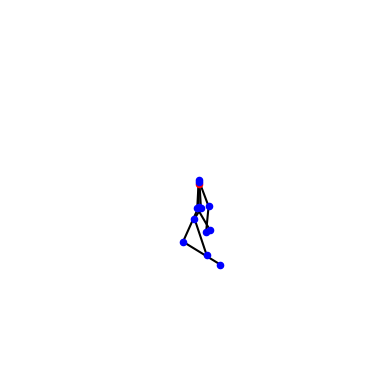

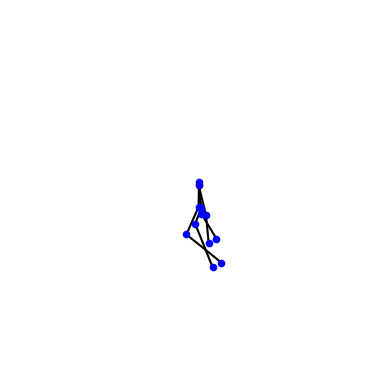

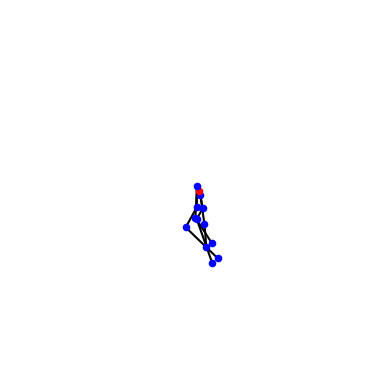

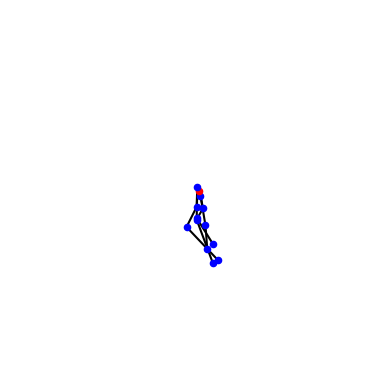

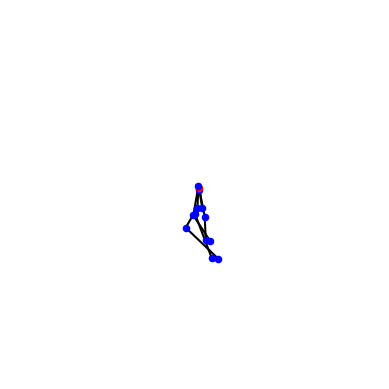

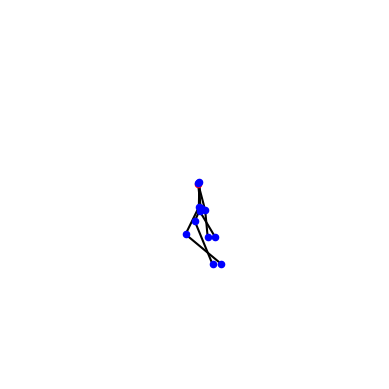

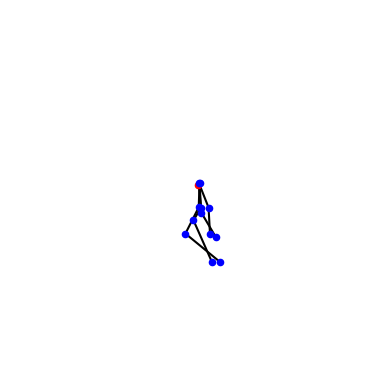

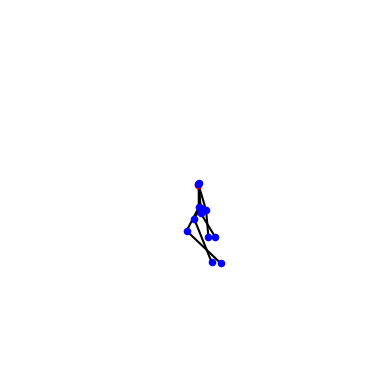

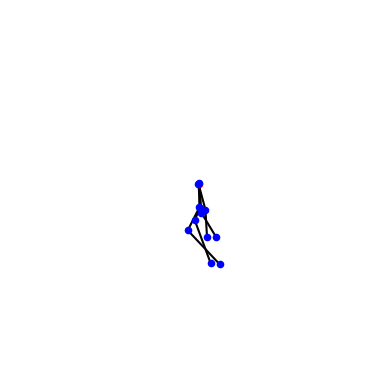

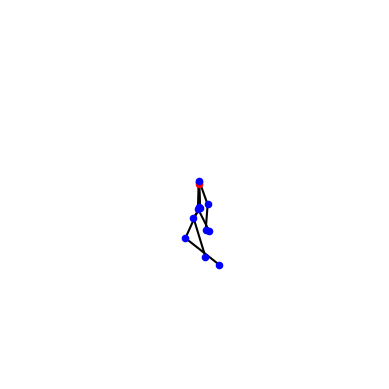

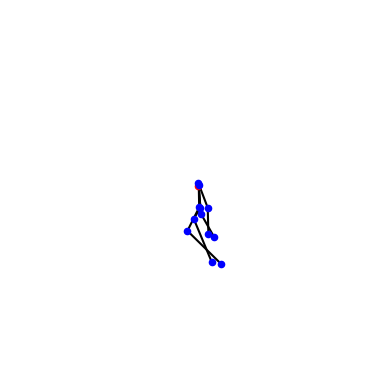

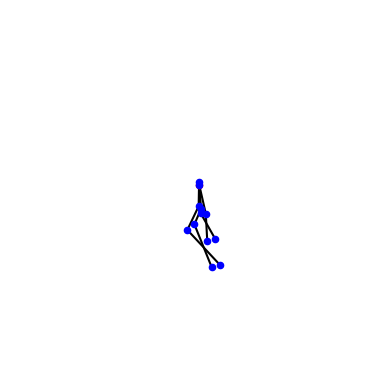

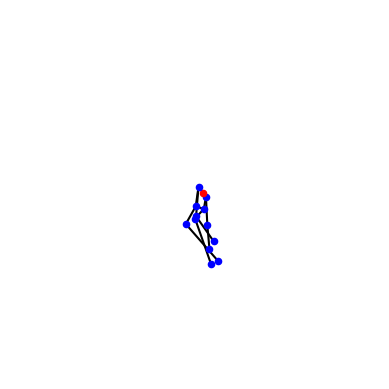

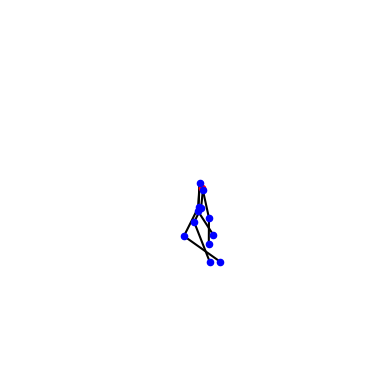

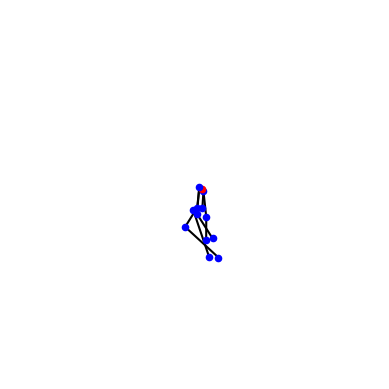

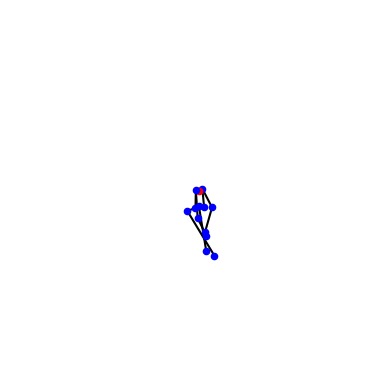

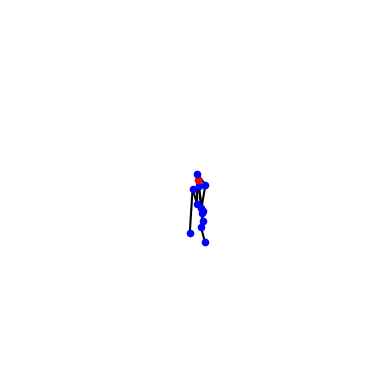

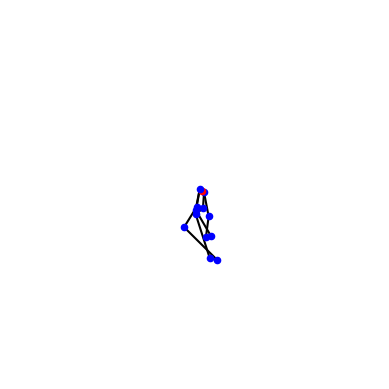

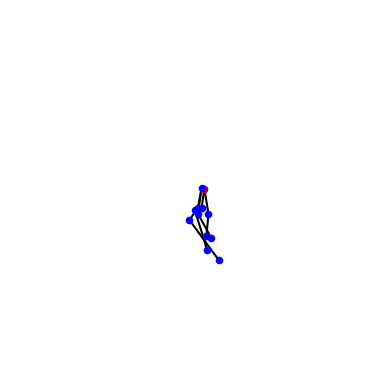

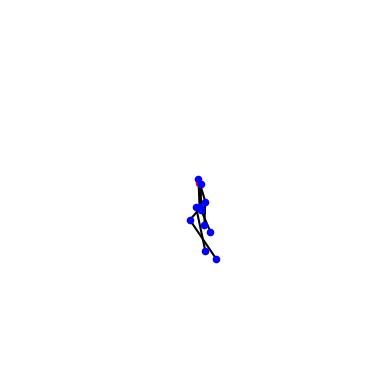

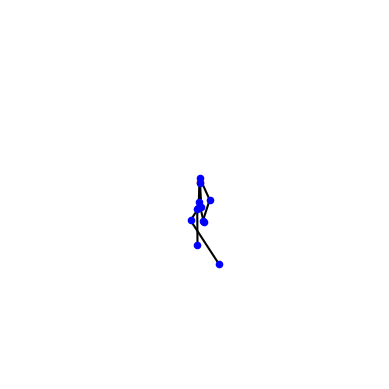

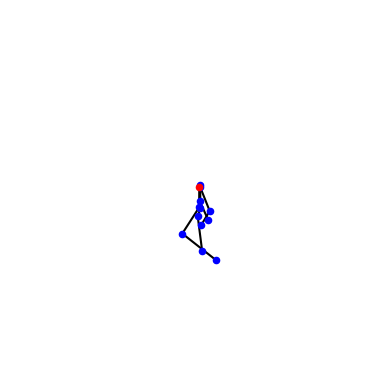

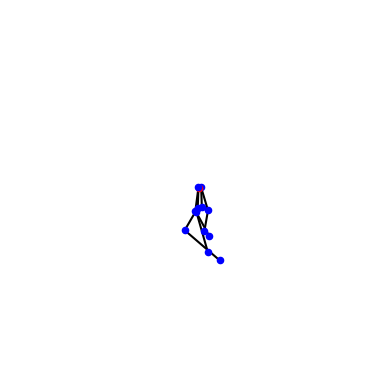

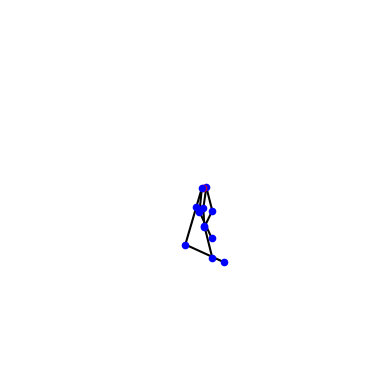

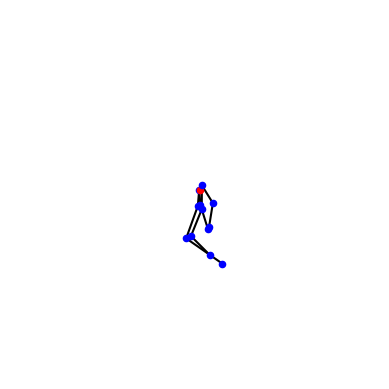

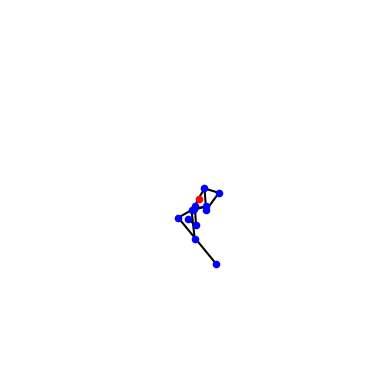

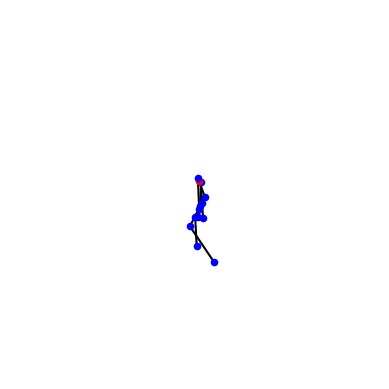

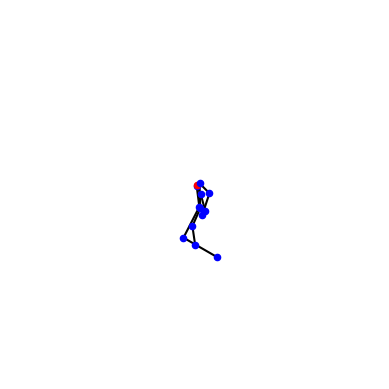

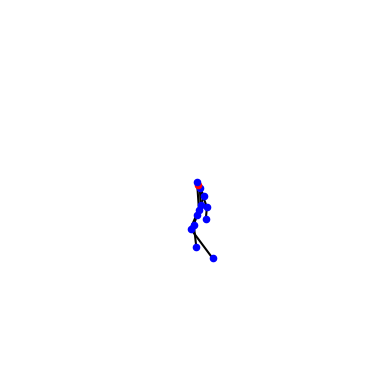

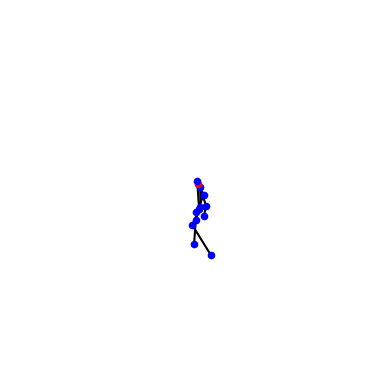

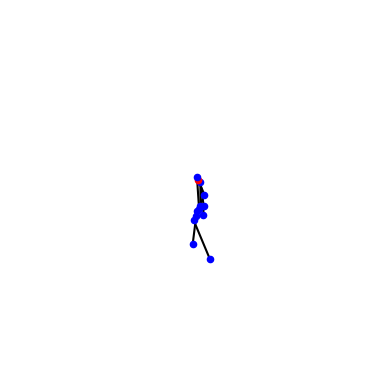

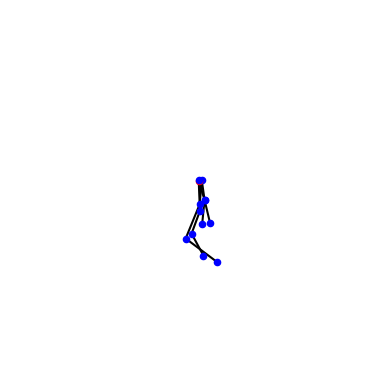

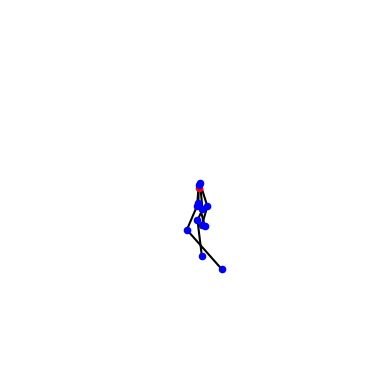

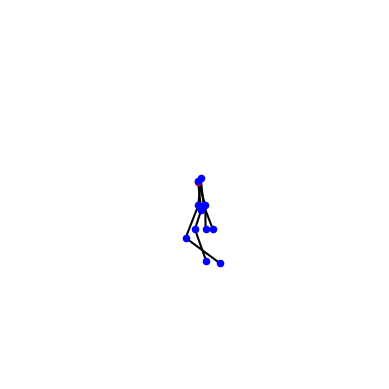

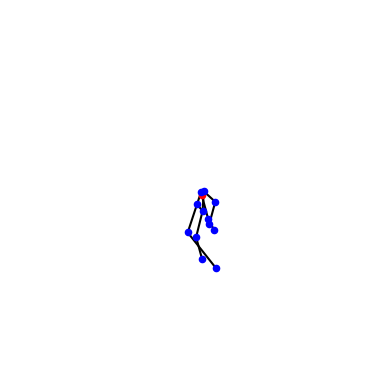

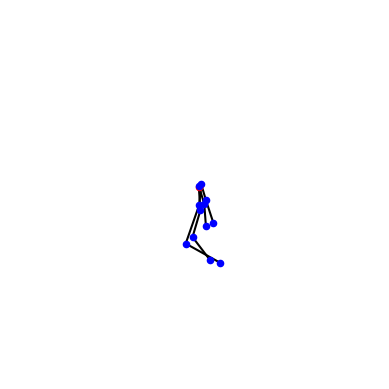

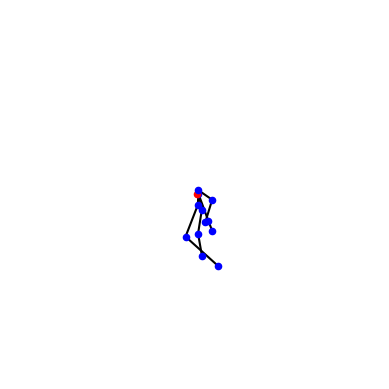

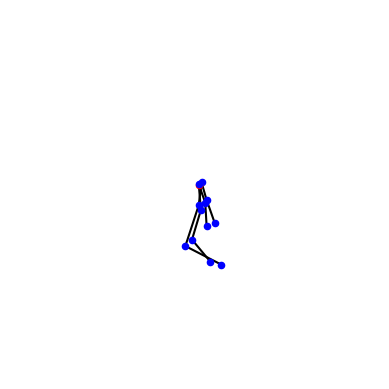

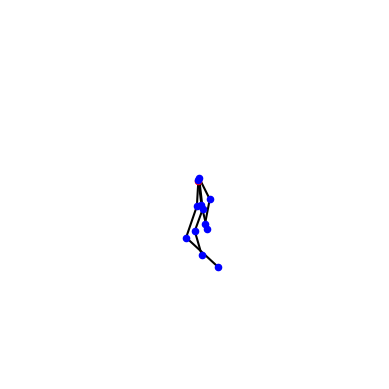

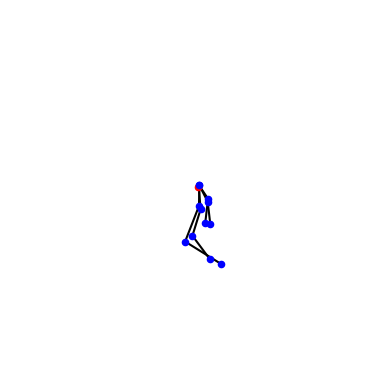

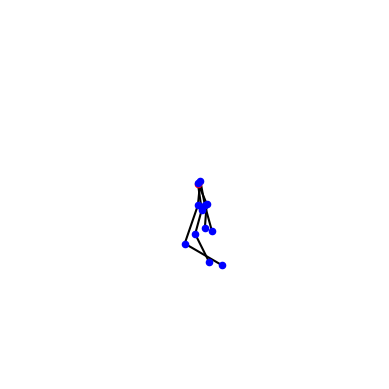

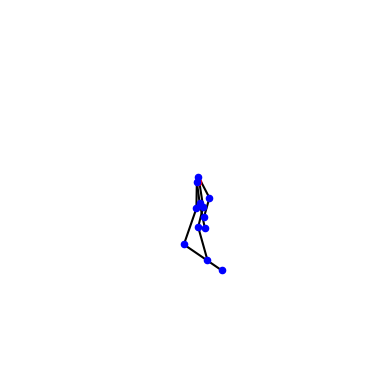

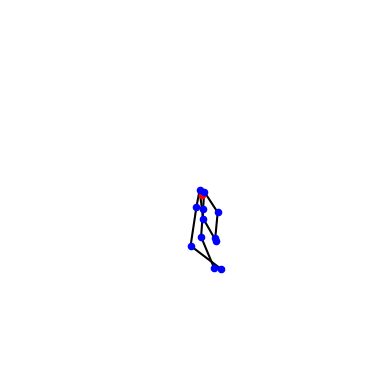

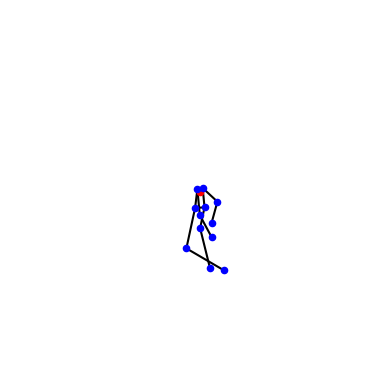

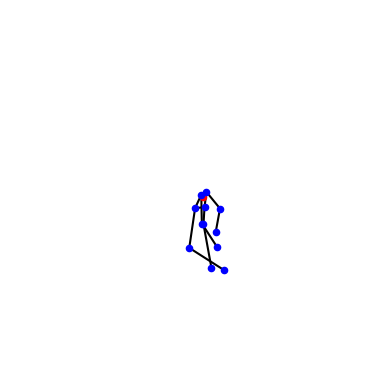

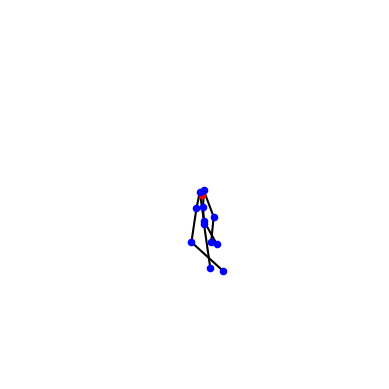

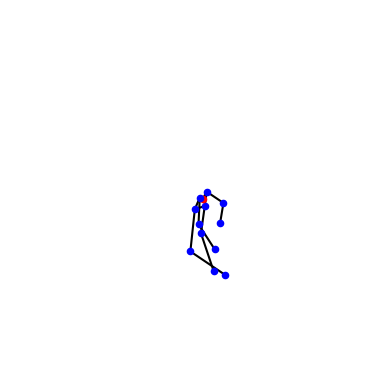

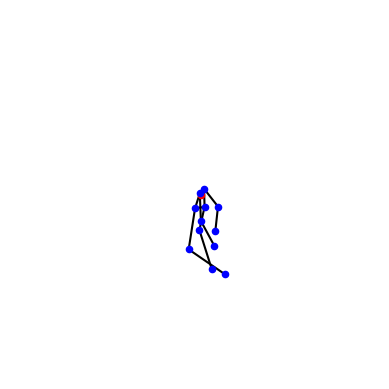

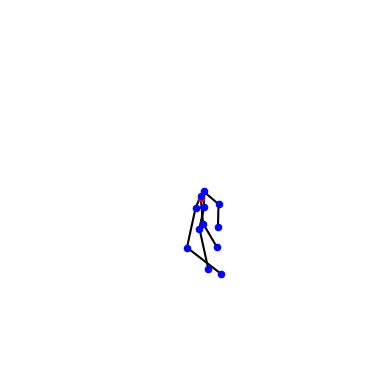

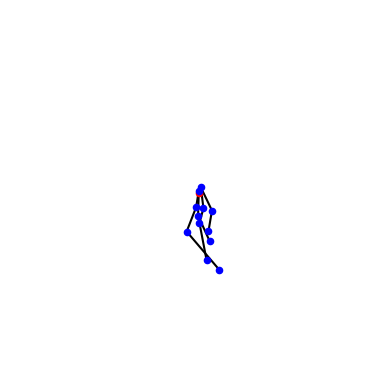

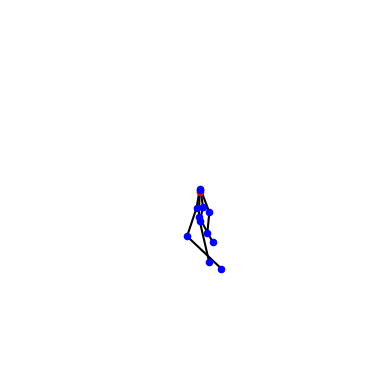

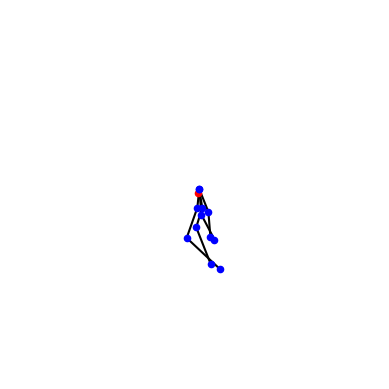

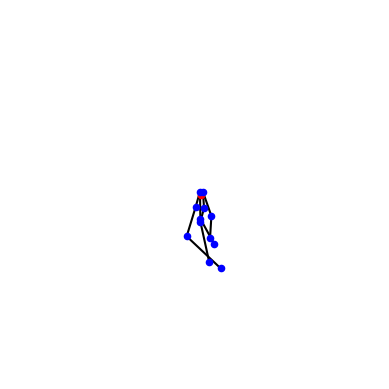

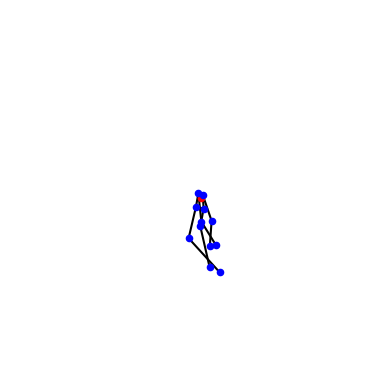

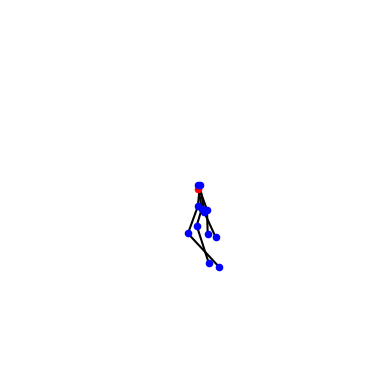

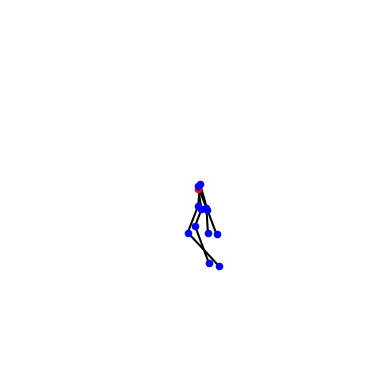

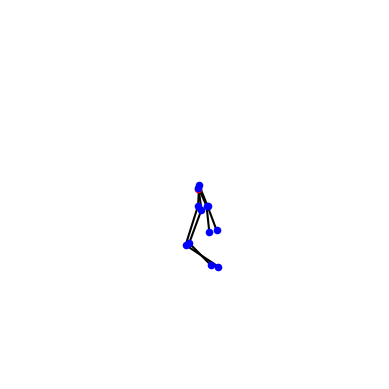

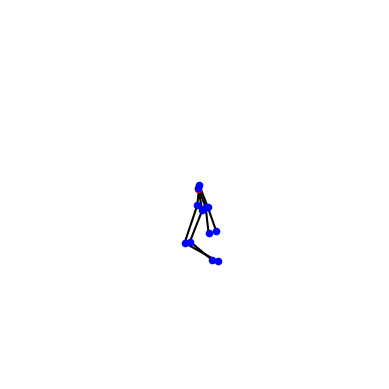

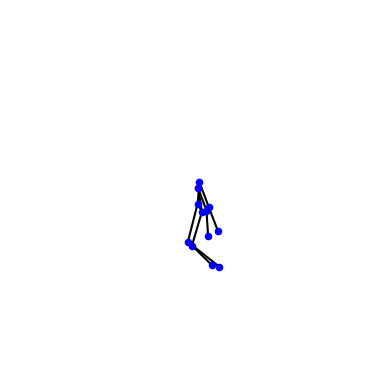

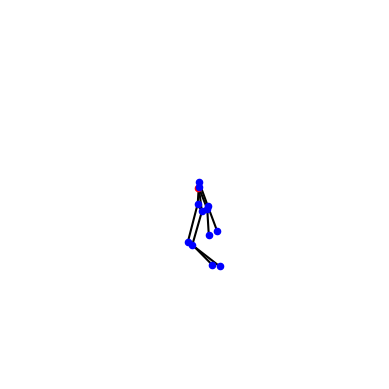

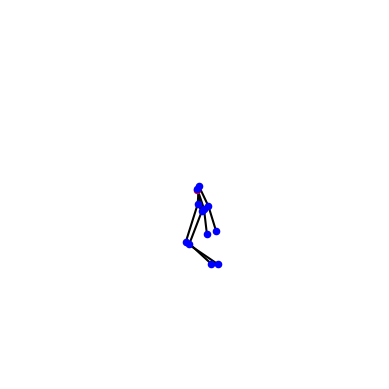

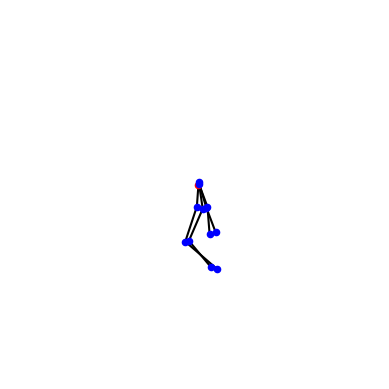

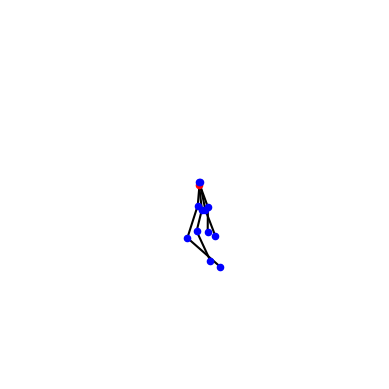

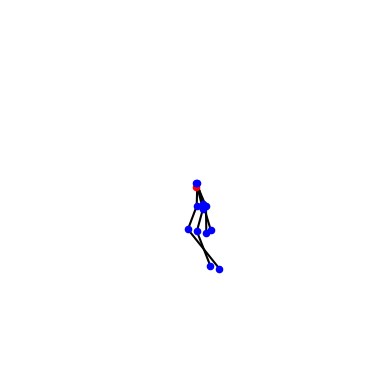

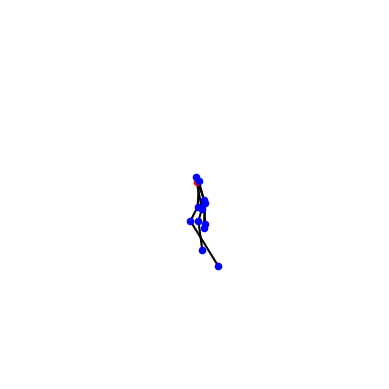

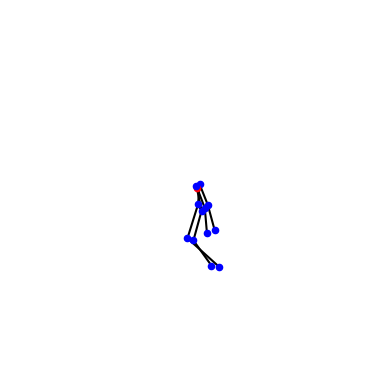

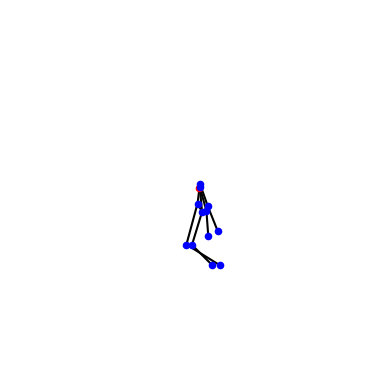

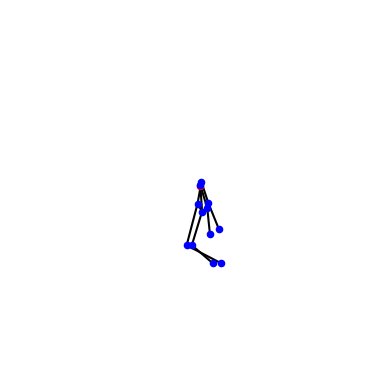

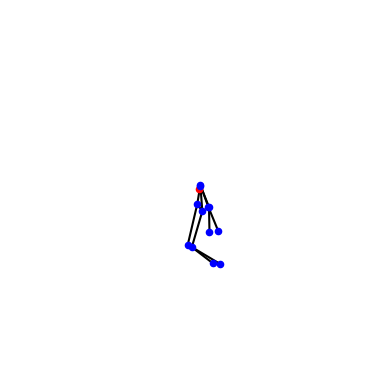

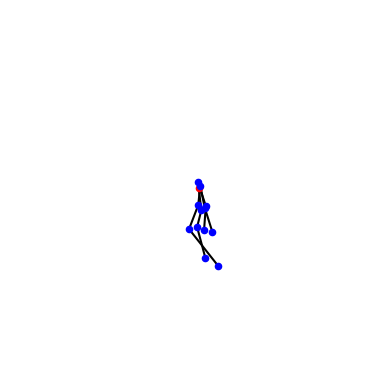

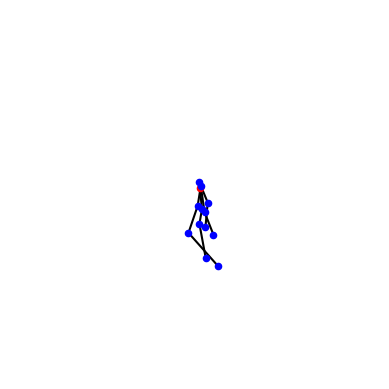

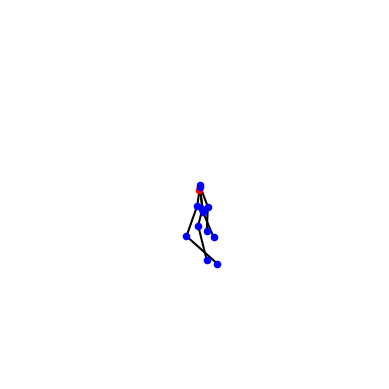

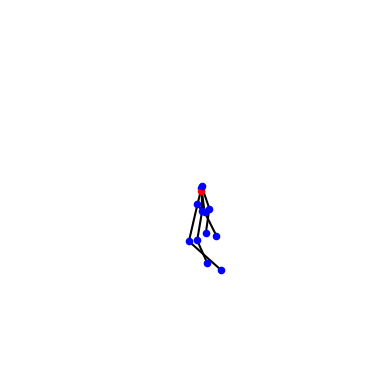

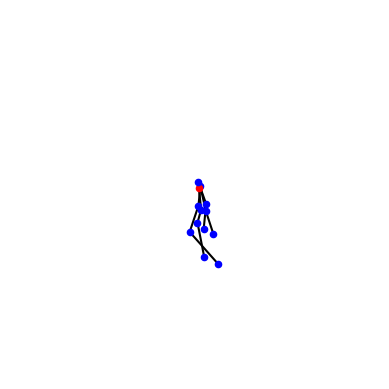

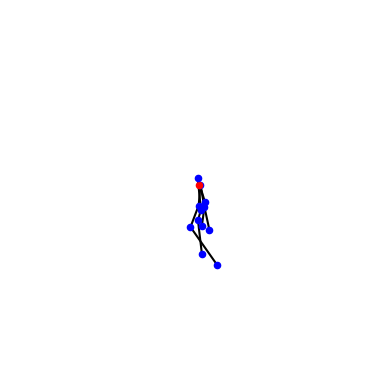

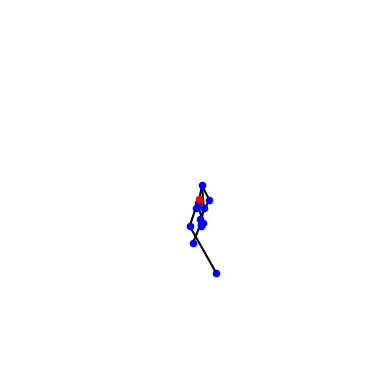

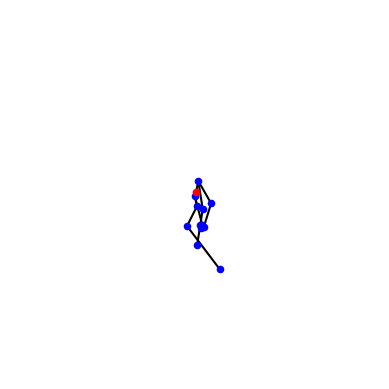

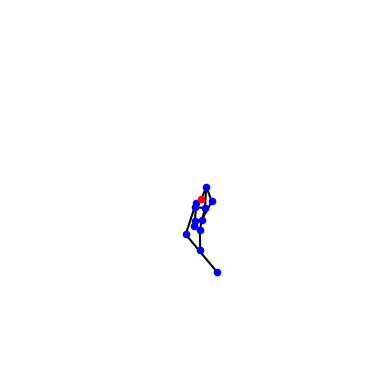

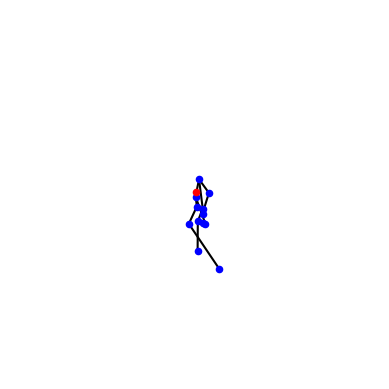

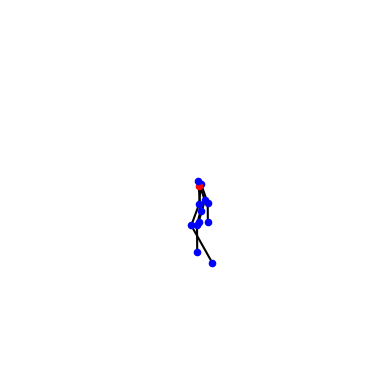

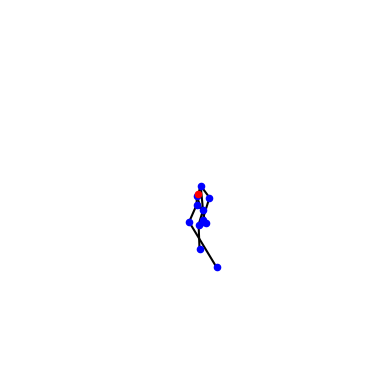

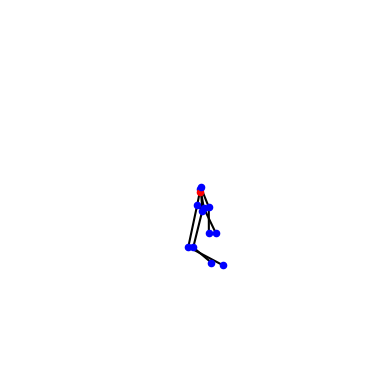

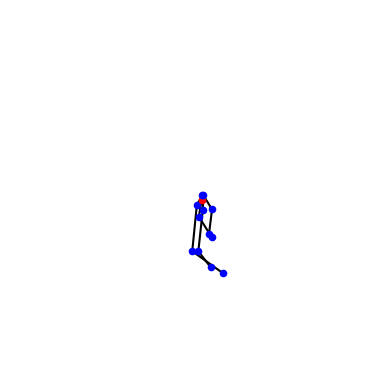

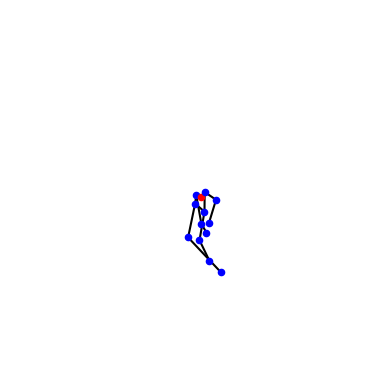

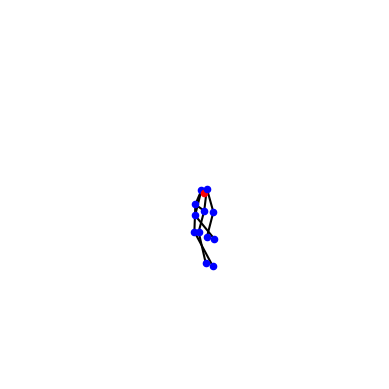

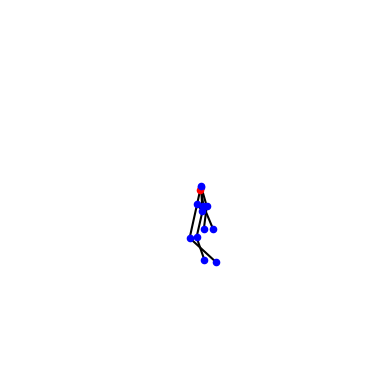

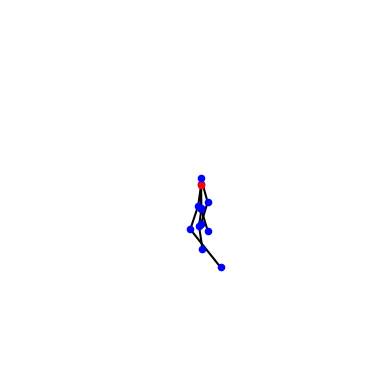

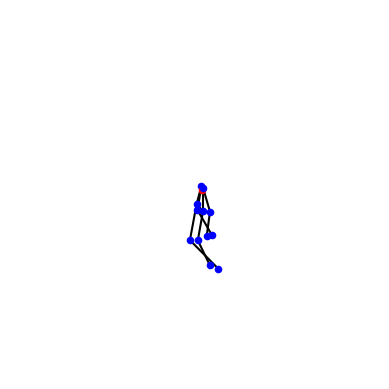

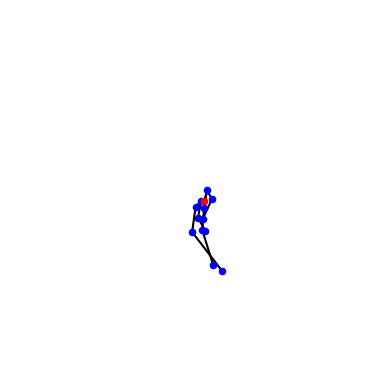

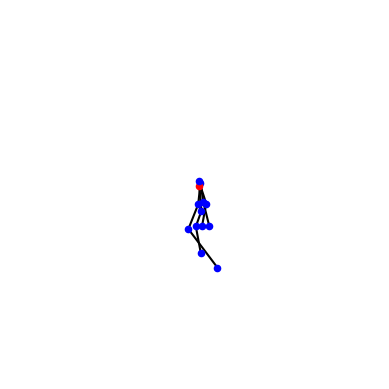

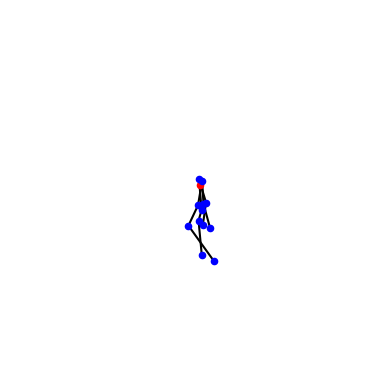

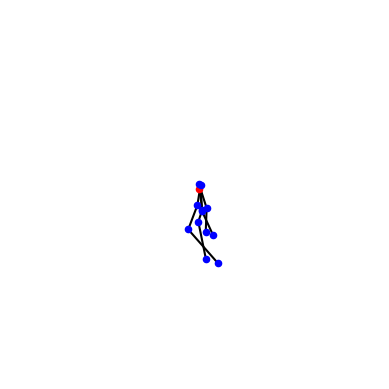

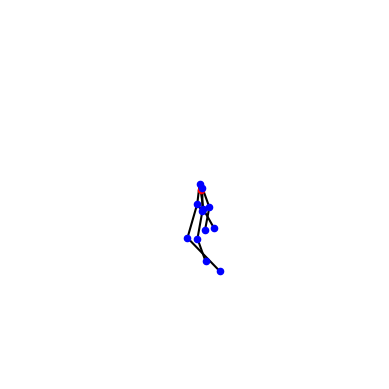

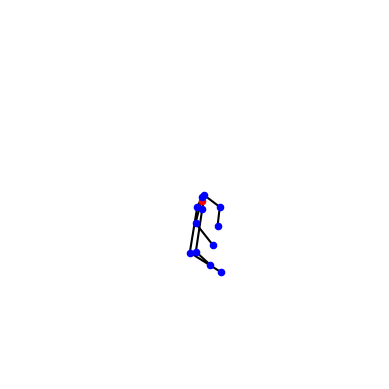

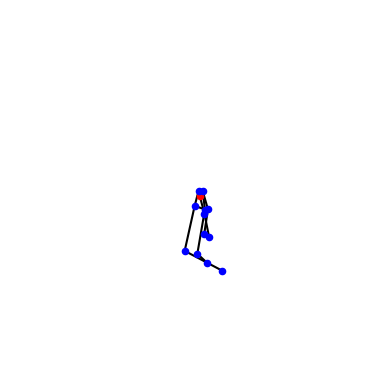

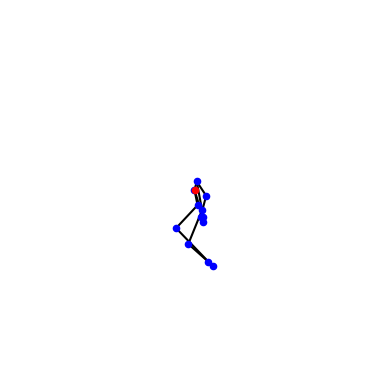

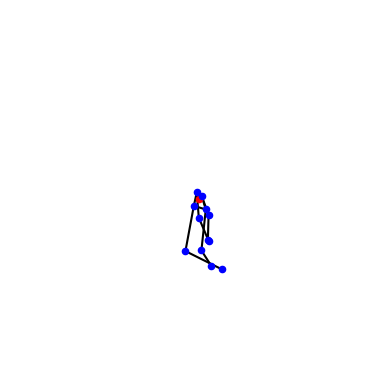

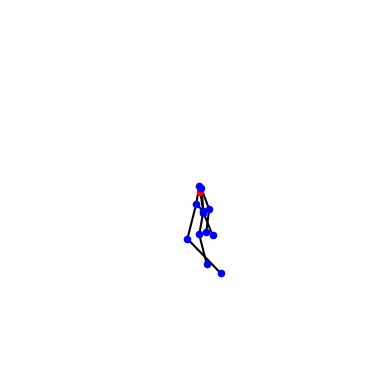

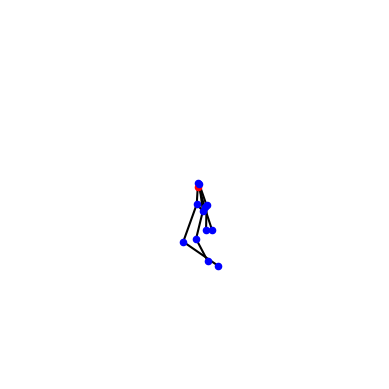

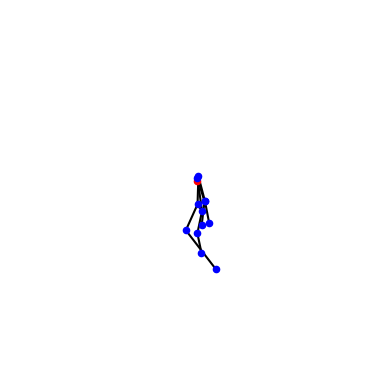

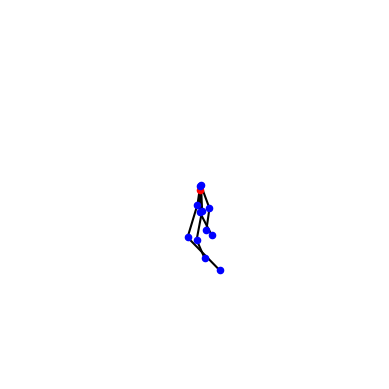

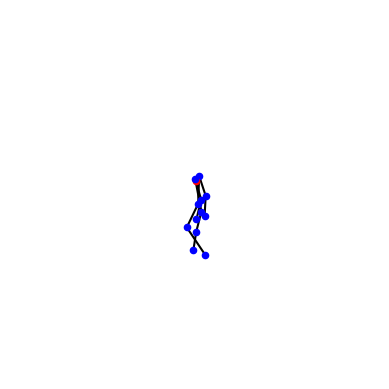

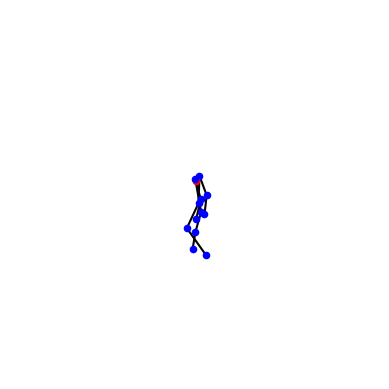

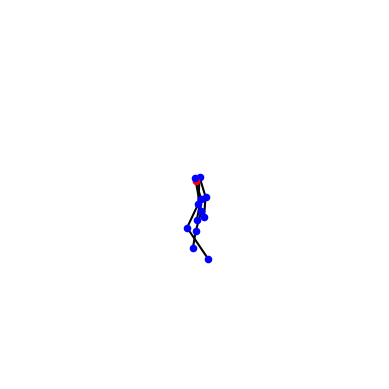

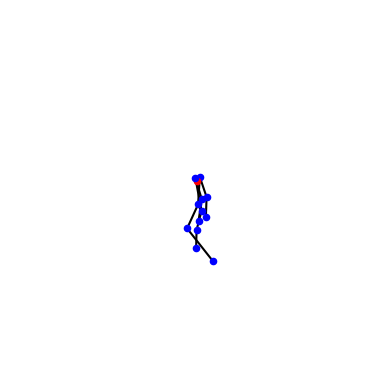

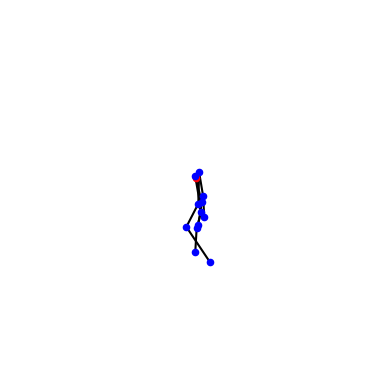

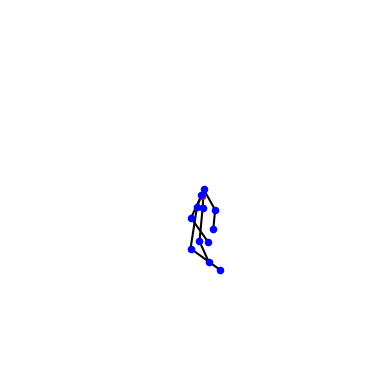

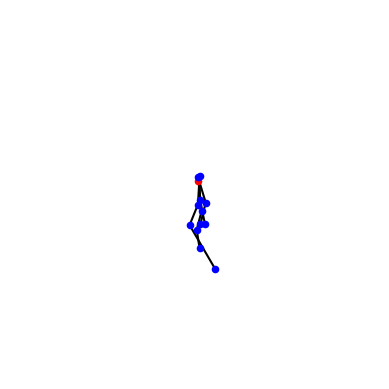

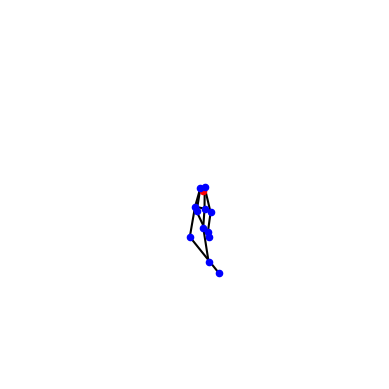

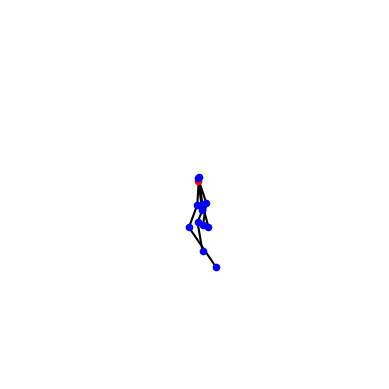

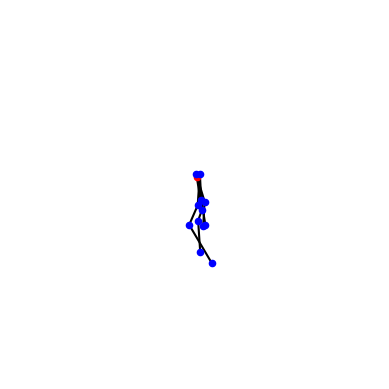

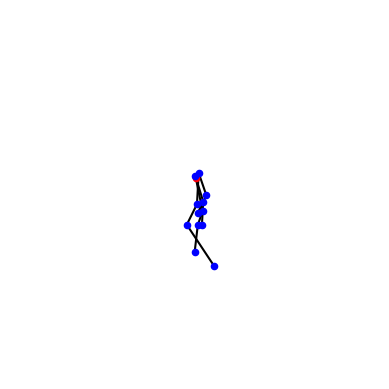

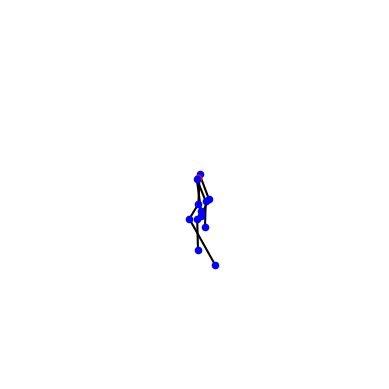

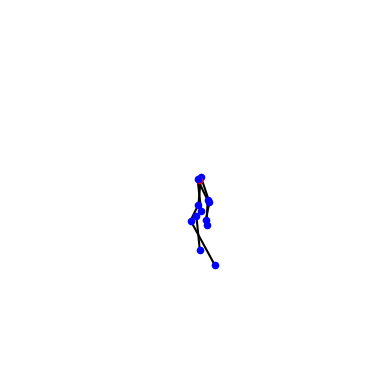

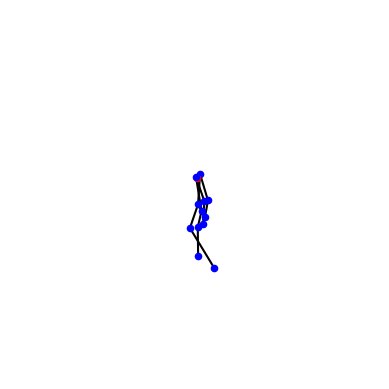

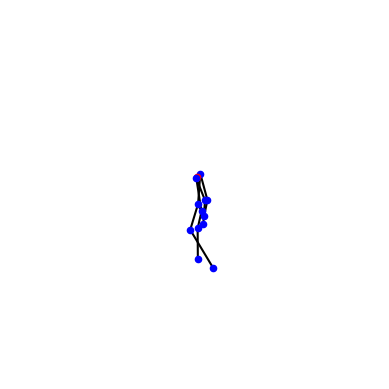

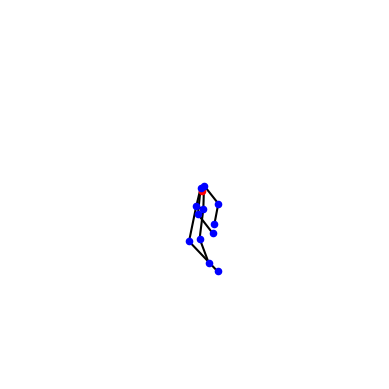

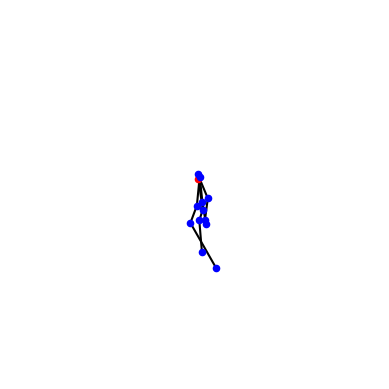

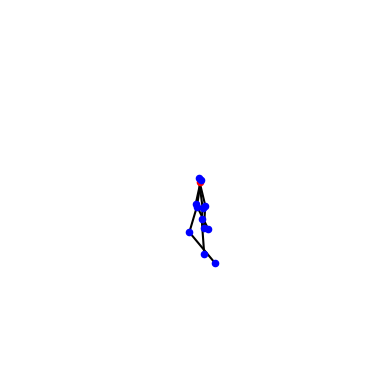

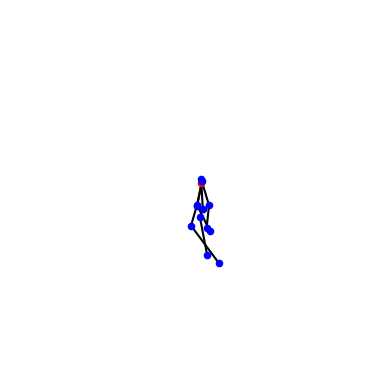

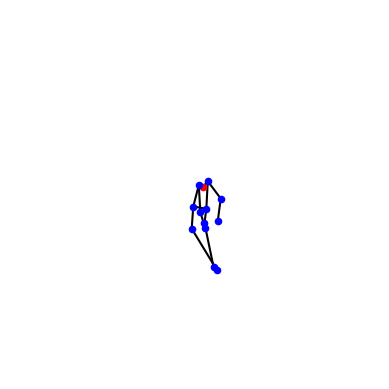

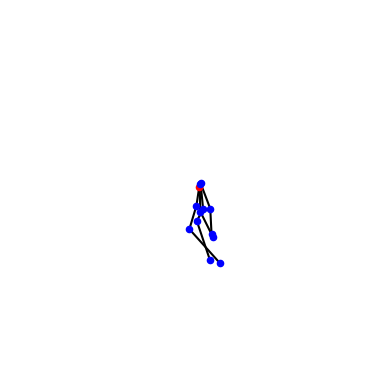

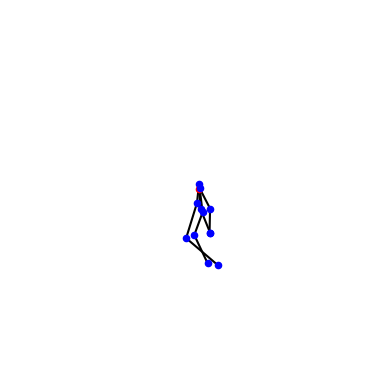

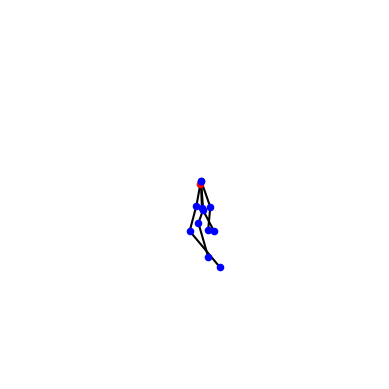

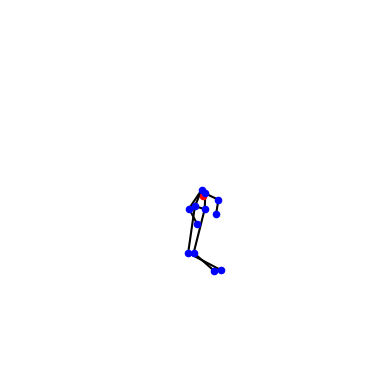

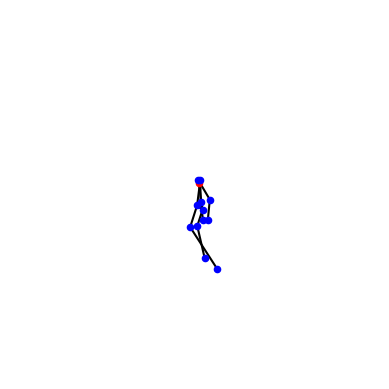

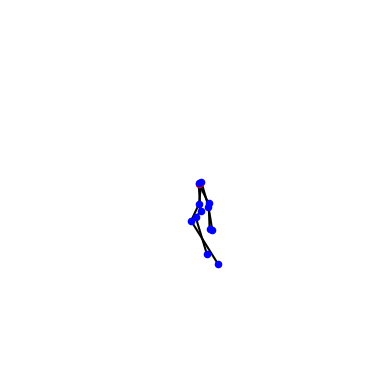

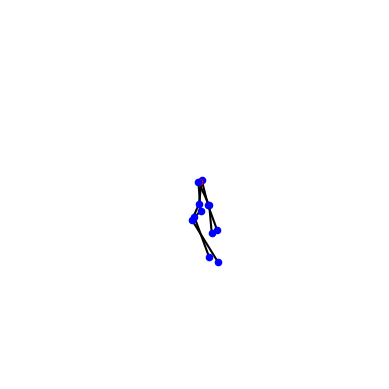

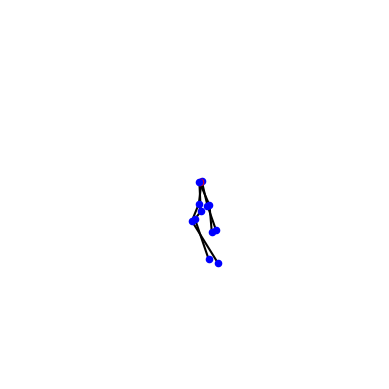

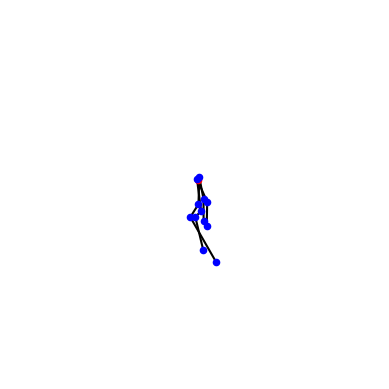

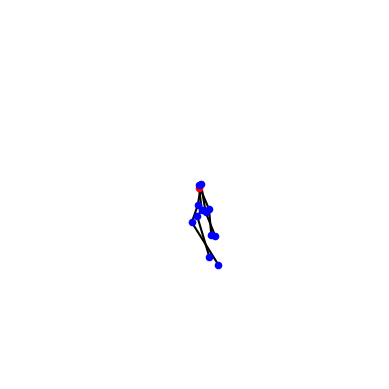

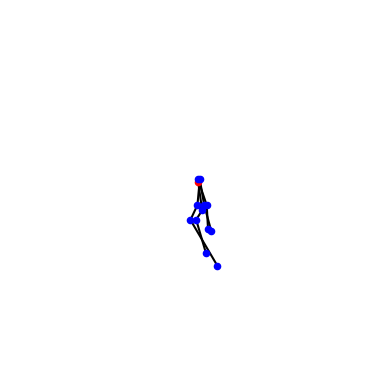

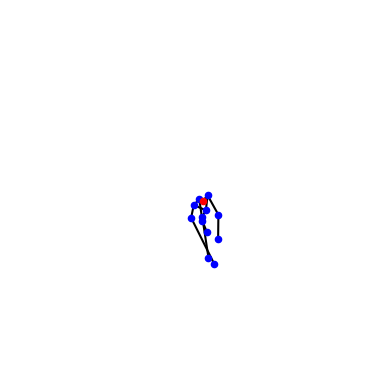

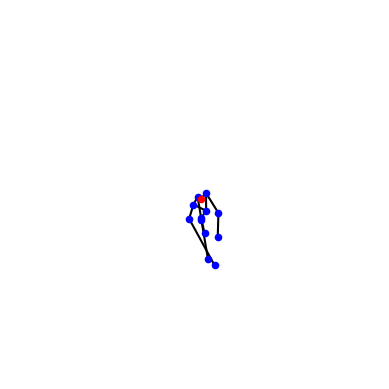

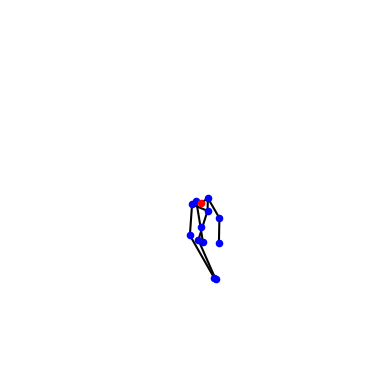

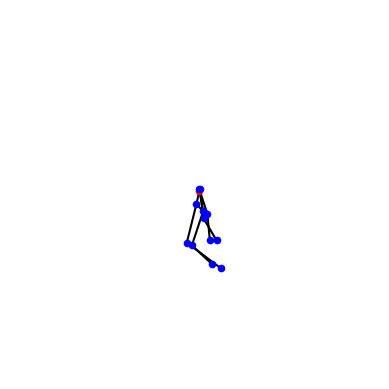

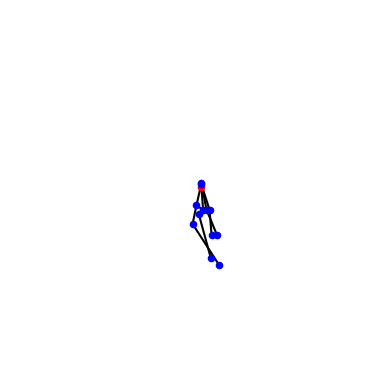

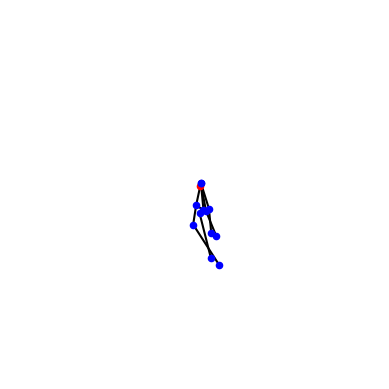

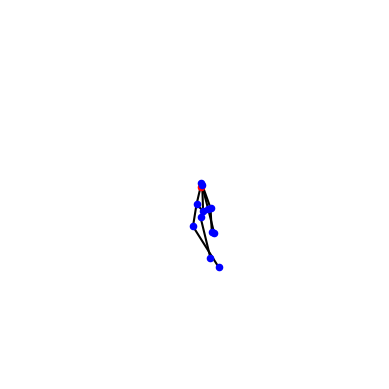

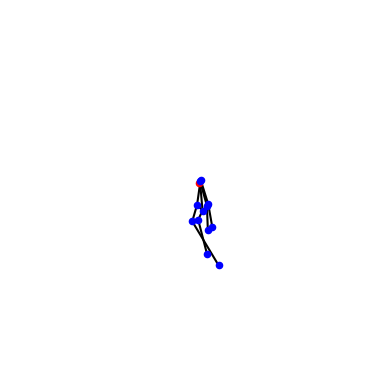

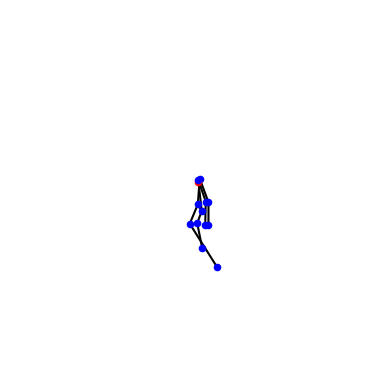

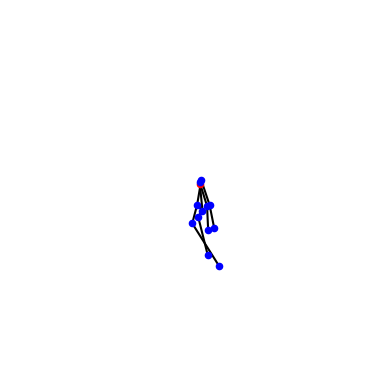

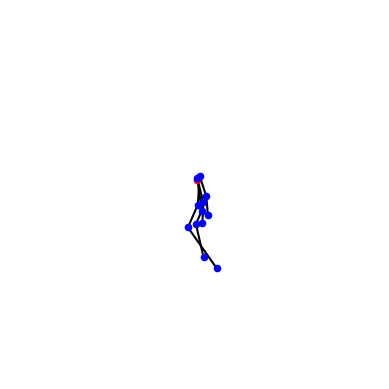

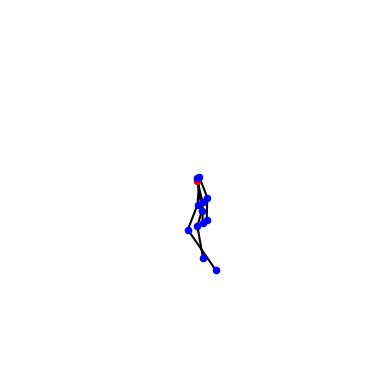

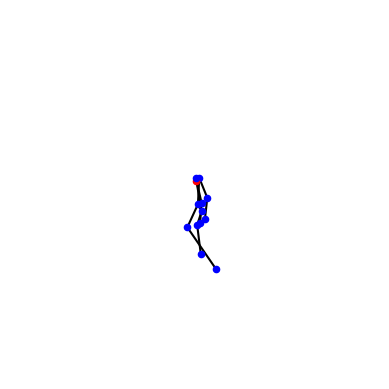

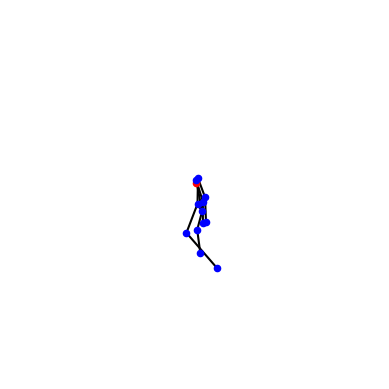

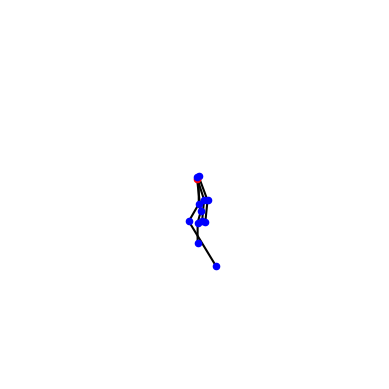

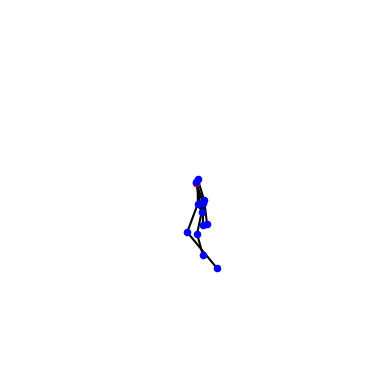

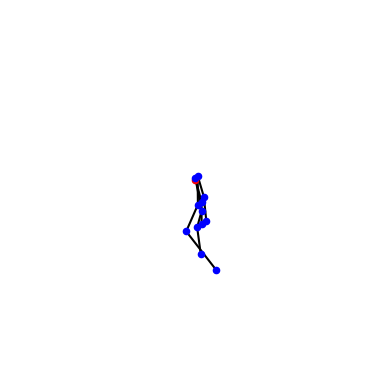

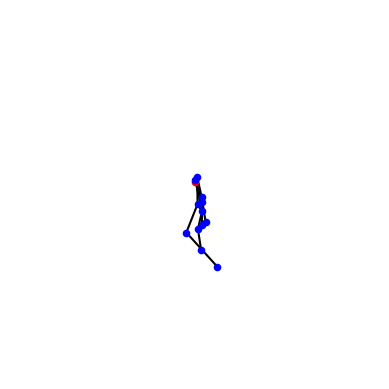

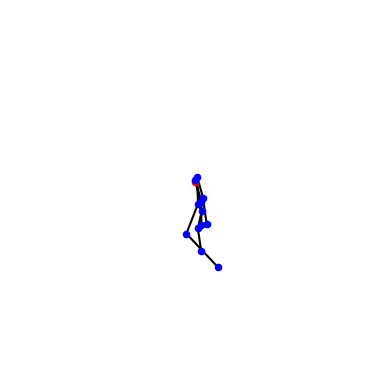

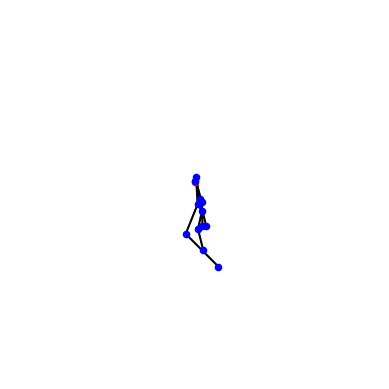

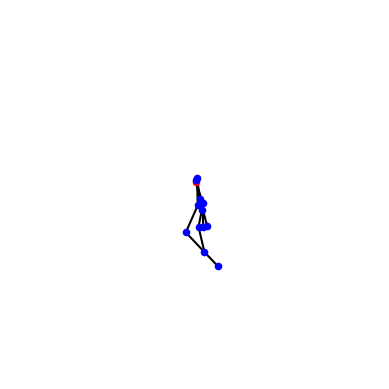

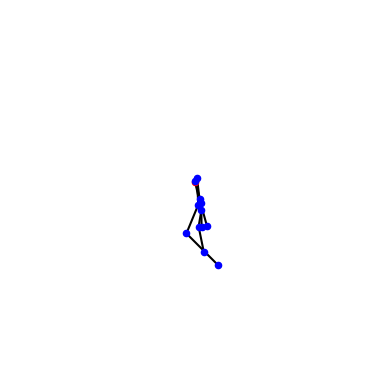

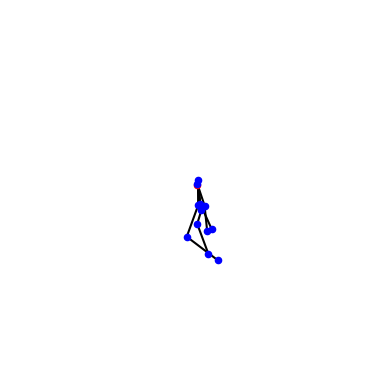

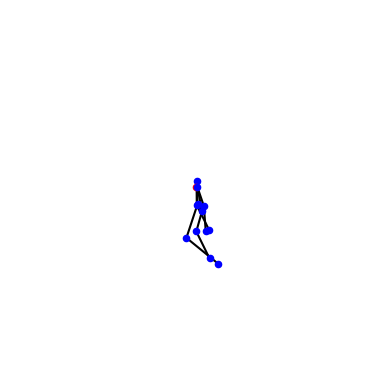

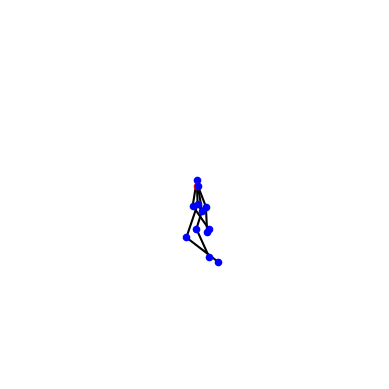

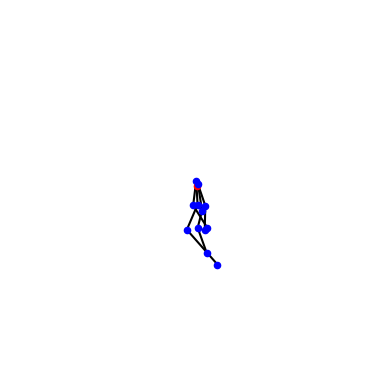

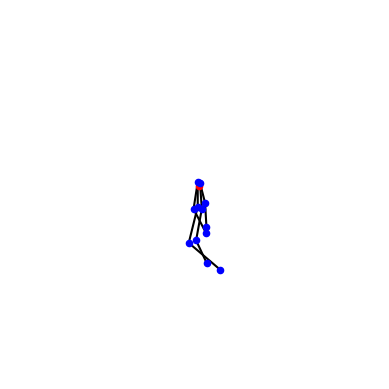

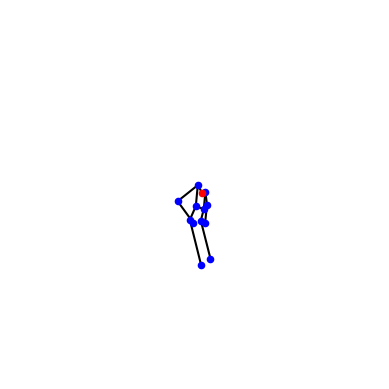

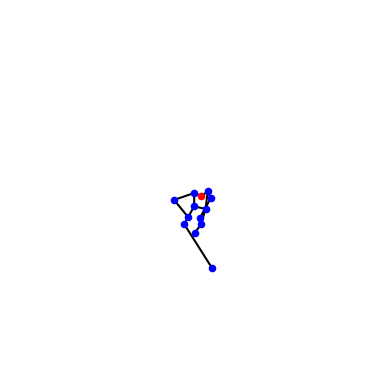

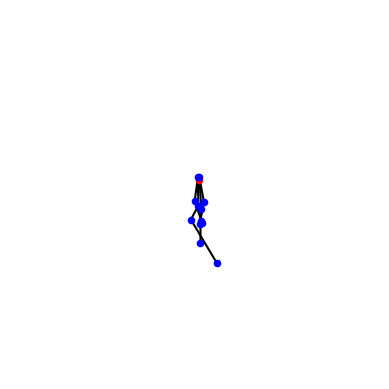

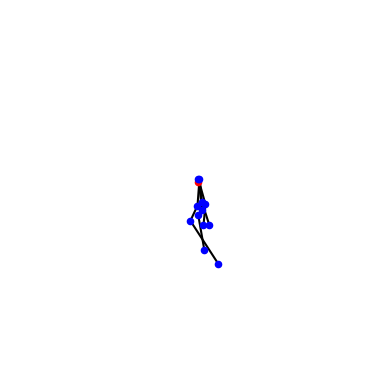

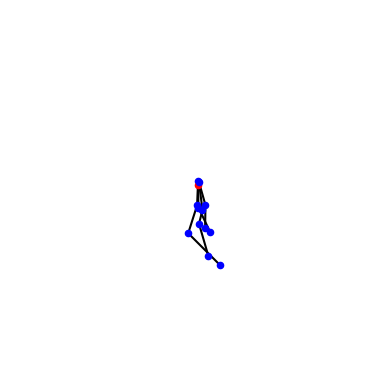

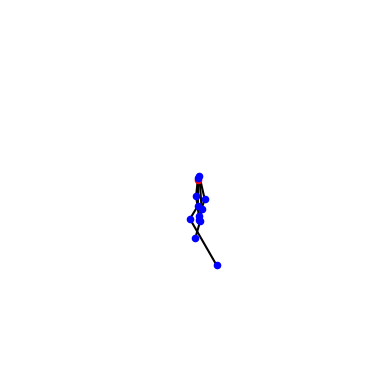

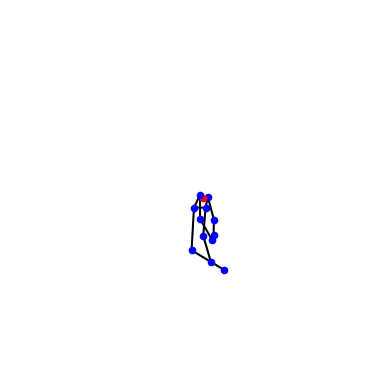

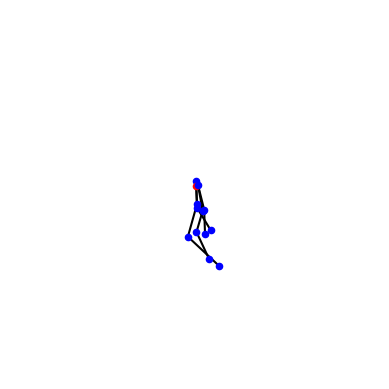

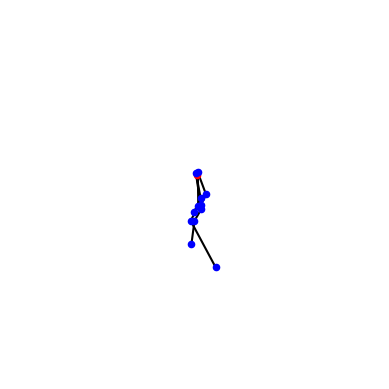

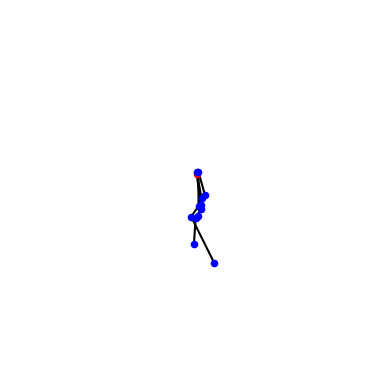

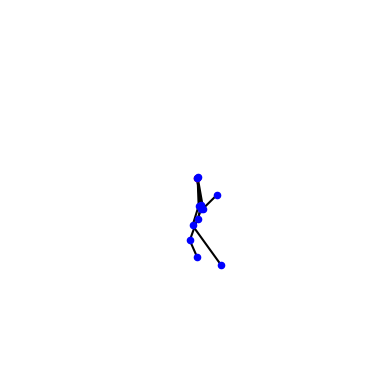

In [32]:
for o, vals in enumerate(output_keypoints_3d):
    time = o

    # The rotation quaternion
    rot = [0.1407056450843811, -0.1500701755285263, -0.755240797996521, 0.6223280429840088]

    # Convert the quaternion to a rotation matrix
    R = quaternion_to_matrix(rot)

    # Rotate the points
    vals_rot = vals.dot(R.T)

    to_skeleton = [8, 14, 15, 16, 11, 12, 13, 1, 2, 3, 0, 4, 5, 6, 0]
    cctv_skeleton = []
    for p in to_skeleton:
        cctv_skeleton.append(vals_rot[p].tolist())
        
    heatmap_sequence = ["Neck", "Right_shoulder", "Right_elbow", "Right_wrist", "Left_shoulder", "Left_elbow",
                            "Left_wrist", "Right_hip", "Right_knee", "Right_ankle", "Right_foot", "Left_hip",
                            "Left_knee", "Left_ankle", "Left_foot"]

    sk_dict = dict(zip(heatmap_sequence,cctv_skeleton))
    # print("sk_dict",sk_dict)

    lines = [(0, 1), (0, 4), (1, 2), (2, 3), (4, 5), (5, 6), (1, 7), (4, 11), 
     (7, 8), (8, 9), (9, 10), (11, 12), (12, 13), (13, 14), (7, 11)]

    dict_lines={}
    for i,j in lines:
        x1, y1, z1 = cctv_skeleton[i]
        x2, y2, z2 = cctv_skeleton[j]
        dict_lines['%s to %s'%(heatmap_sequence[i], heatmap_sequence[j])] = {'start_point' : [x1, y1, z1], 'end_point' :[x2, y2, z2]}
    # dict_lines

    dict_lines = {key_line:{k: list(map(float,v)) for k,v in v_line.items()} for key_line, v_line in dict_lines.items()}
    # json.dump(dict_lines, codecs.open(json_line_filename, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    i=0;  n=0

    for x,y,z in cctv_skeleton:
        if i == n:
            ax.scatter3D(x,y,z, color='r' )# 3D scatter plot)
        elif i== 10 or i==14:
            i +=1
            continue
        else:
            ax.scatter3D(x,y,z,color='b')
        i +=1

    lines = [(0, 1), (0, 4), (1, 2), (2, 3), (4, 5), (5, 6), (1, 7), (4, 11), 
             (7, 8), (8, 9), (9, 10), (11, 12), (12, 13), (13, 14), (7, 11)]
    for i,j in lines:
        x1, y1, z1 = cctv_skeleton[i]
        x2, y2, z2 = cctv_skeleton[j]
        if j in [10,14]:
            continue
        ax.plot([x1, x2], [y1, y2], [z1, z2], 'k-')  # 'b-'는 파란색 실선을 의미합니다.

    ax.set_xlim(-1,1);   ax.set_ylim(-1,1);   ax.set_zlim(-0.6,1)
    ax.set_axis_off()
    # ax.invert_zaxis()

    plt.grid(False)

    # if time >= falldown_time:
    #     falldown_angle += 5
    #     print("fall")
    # if falldown_angle >= 90:
    #     falldown_angle = 90
    # ax.view_init(elev=10, azim=-50, roll=falldown_angle )
    ax.invert_yaxis()
    fig.savefig(f"{out_filename}{o}.png")
    plt.show()
    

In [33]:
import cv2
import os

images = [img for img in os.listdir(out_path) if img.endswith(".png")]
images = sorted(images, key=extract_number)

###### 연속적인 png 파일을 mp4로 MAKE ######
frame = cv2.imread(os.path.join(out_path, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'DIVX'), 25, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(out_path, image)))

cv2.destroyAllWindows()
video.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
